# MODELO PREDICTIVO DE DESERCIÓN ESTUDIANTIL DE EDUCACIÓN PREESCOLAR, BÁSICA Y MEDIA EN EL MUNICIPIO DE MEDELLÍN

### Presentador por:
Celger Paola Chamat Torres  
Universidad de Antioquia

## Información del Dataset

Se cuenta con un Dataset con la información de matrícula de estudiantes de Educación Preescolar, Básica y Media de colegios del Municipio de Medellín. Se requiere desearrollar un modelo predicto de deserción estudiantil que permita clasificar en desertores y no desertores a dichos estudiantes.

### Importación de librerías

En la etapa inicial, es necesario importar todas las librerías gráficas y computacionales para la ejecución del modelo.

In [1]:
#Instalación de SweetVIZ para la visualización descriptiva de los datos
!pip install sweetviz

In [2]:
#Instalación de TensorFlow para modelos con Redes Neuronales
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, date
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline

# Estilos de las gráfica
plt.style.use('bmh') #makes plots look pretty

# SweetVIZ
import sweetviz as sv

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Sklearn
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.metrics import recall_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
# TensorFlow
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import utils 

In [4]:
from platform import python_version

print(python_version())

3.8.8


## Análisis descriptivo

### Carga de la base de datos

Se realiza la lectura de la base de datos principal del proyecto, la cual contiene la información preliminar de matrícula en el municipio de Medellín, esta lectura será asignada a la variable "df_simat".  

Es importante mencionar que el notebook público no podrá ser ejecutado dado a la confidencialidad de la información y las licencias de uso implicadas en la adquisición de los conjuntos de datos.

In [5]:
#df_simat=pd.read_csv("BD_anexo_sisben_2019.csv",sep=',')

In [6]:
print(f'El Dataset df_simat cuenta con un total de {df_simat.shape[0]} registros y {df_simat.shape[1]} variables características.')

El Dataset df_simat cuenta con un total de 234017 registros y 61 variables características.


### Identificación de variables

Se realiza una primera exploración de todas las variables características que contiene el dataset df_simat, así como visualización de variables nulas o no nulas y el tipo de dato de cada columna.

In [7]:
df_simat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234017 entries, 0 to 234016
Data columns (total 61 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 234017 non-null  int64  
 1   MUN_CODIGO            234017 non-null  float64
 2   CODIGO_DANE           234017 non-null  float64
 3   CODIGO_DANE_SEDE      234017 non-null  float64
 4   CONS_SEDE             234017 non-null  float64
 5   sede                  234017 non-null  float64
 6   prestacion_servicio   234017 non-null  object 
 7   EXP_DEPTO             233199 non-null  float64
 8   EXP_MUN               233199 non-null  float64
 9   RES_DEPTO             234017 non-null  float64
 10  RES_MUN               234017 non-null  float64
 11  ESTRATO               234017 non-null  float64
 12  SISBEN                188308 non-null  float64
 13  NAC_DEPTO             233241 non-null  float64
 14  NAC_MUN               233241 non-null  float64
 15  

Se puede analizar que las variables con mayor cantidad de valores nulos son: DPTO_EXP, MUN_EXP, VAL_DES_PERIODO1, VAL_DES_PERIODO2 y NUM_CONVENIO. Debido a que la cantidad de registros nulos son superiores al 85% de los datos, se toma de decisión de depurarlo. Además de las anteriores, se elimina la variable INTERNADO por cantidad de registros nulos y la poca relevancia en el proceso.

In [8]:
df_simat.drop(['DPTO_EXP','MUN_EXP','VAL_DES_PERIODO1','VAL_DES_PERIODO2','NUM_CONVENIO','INTERNADO'], 
              axis=1, inplace=True)

Se realiza un recorrido por las columnas del Dataset para capturar aquellas con registros distintos a tipo numérico.

In [9]:
cols_categoricas = [i for i in df_simat.columns if not i in df_simat._get_numeric_data()]
print (cols_categoricas)

['prestacion_servicio', 'GENERO', 'PROVIENE_SECTOR_PRIV', 'PROVIENE_OTRO_MUN', 'GRUPO', 'SUBSIDIADO', 'REPITENTE', 'NUEVO', 'CAB_FAMILIA', 'BEN_MAD_FLIA', 'BEN_VET_FP', 'BEN_HER_NAC', 'tipo_anexo_id']


Se realiza un recorrido por las columnas del DataFrame para capturar aquellas con registros de tipo numérico.

In [10]:
cols_numericas = [i for i in df_simat.columns if i in df_simat._get_numeric_data()]
print (cols_numericas)

['index', 'MUN_CODIGO', 'CODIGO_DANE', 'CODIGO_DANE_SEDE', 'CONS_SEDE', 'sede', 'EXP_DEPTO', 'EXP_MUN', 'RES_DEPTO', 'RES_MUN', 'ESTRATO', 'SISBEN', 'NAC_DEPTO', 'NAC_MUN', 'POB_VICT_CONF', 'TIPO_DISCAPACIDAD', 'CAP_EXC', 'ETNIA', 'RES', 'TIPO_JORNADA', 'CARACTER', 'ESPECIALIDAD', 'GRADO', 'METODOLOGIA', 'SIT_ACAD_ANO_ANT', 'CON_ALUM_ANO_ANT', 'FUE_RECU', 'ZON_ALU', 'men_per_id', 'APOYO_ACAD_ESP', 'CTE_ID_SRPA', 'CODIGO_PAIS_ORIGEN', 'ESTADO_DEFINITIVO', 'COMUNA_EST', 'EDAD', 'PUNTAJE', 'extranjero', 'telefono', 'computador', 'embaraza', 'percibe', 'ingresos_promedio']


In [11]:
df_simat['MUN_CODIGO'].unique()

array([1.])

## Visualización del comportamiento de las variables crudas

In [ ]:
my_report = sv.analyze(df_simat.iloc[:,1:])
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"


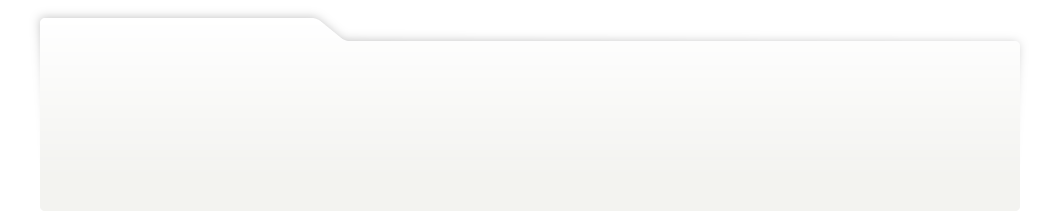
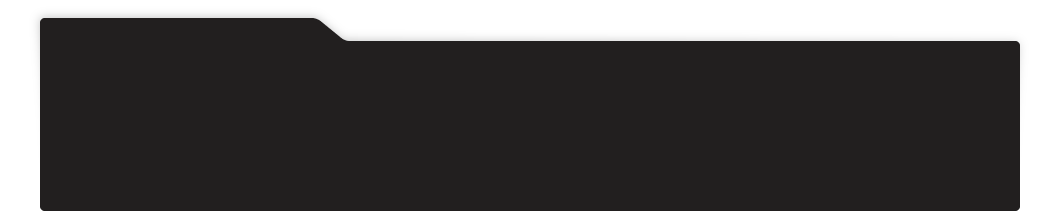
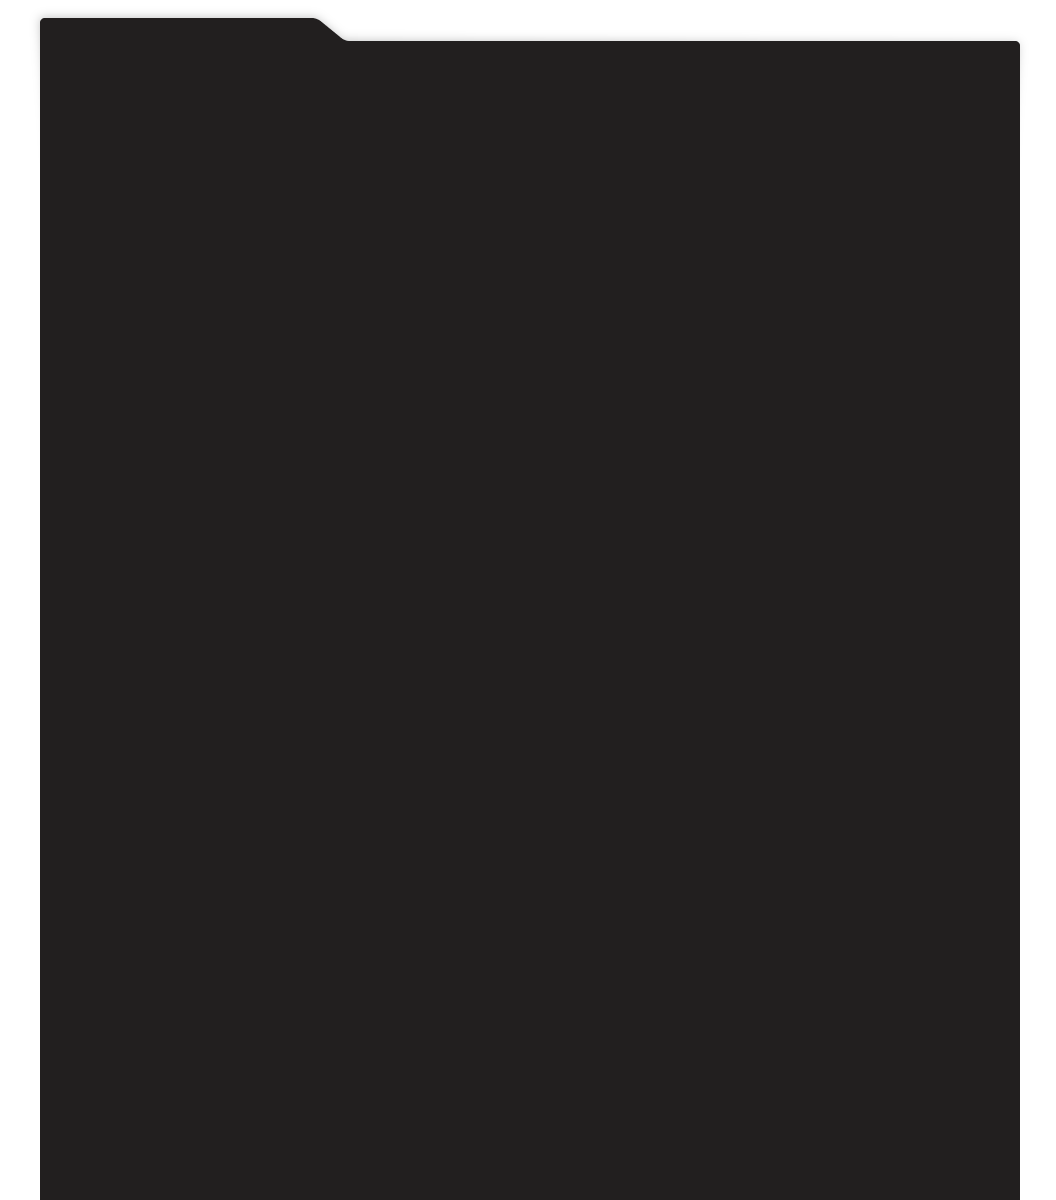
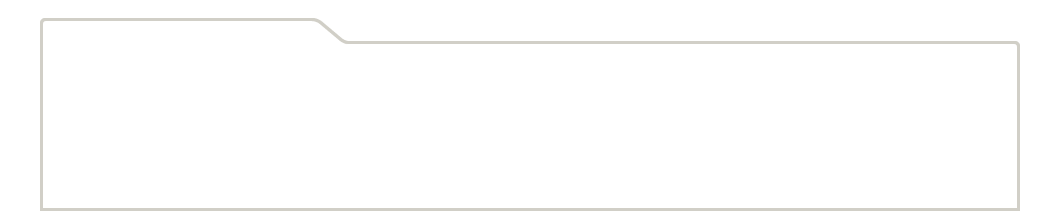
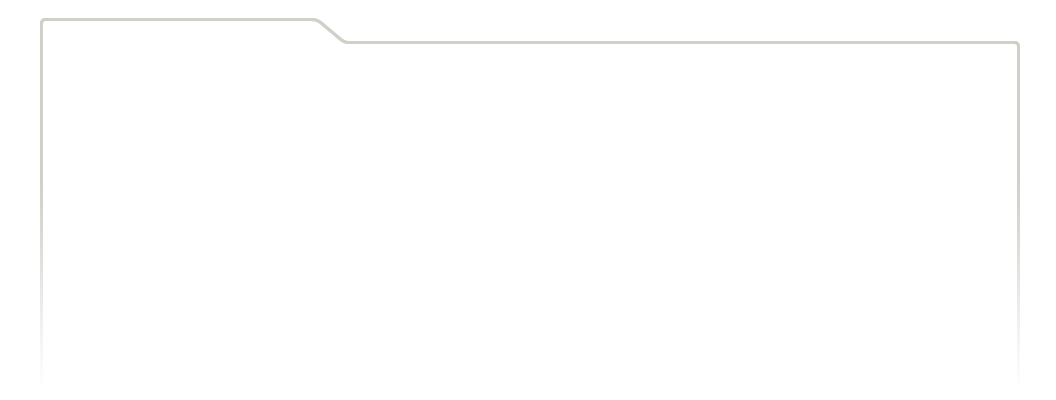
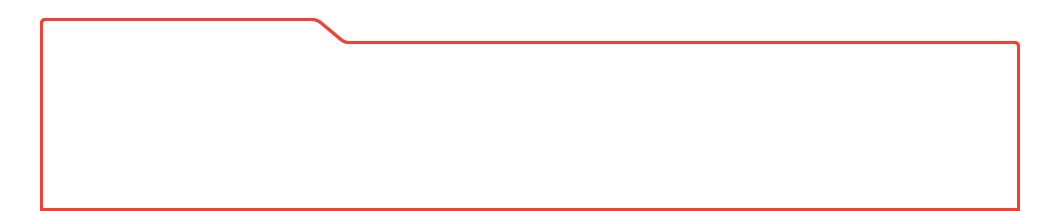
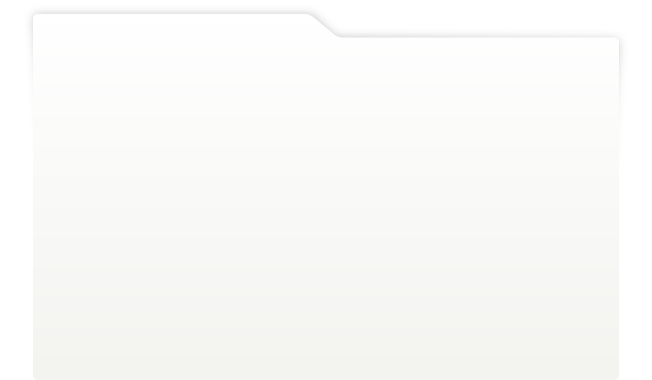
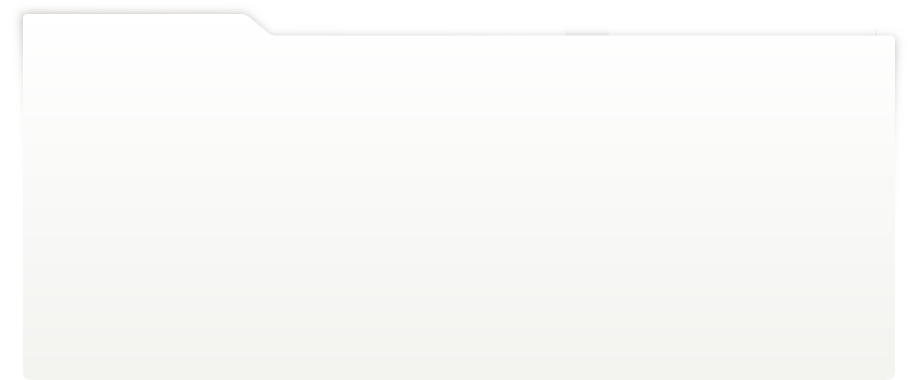
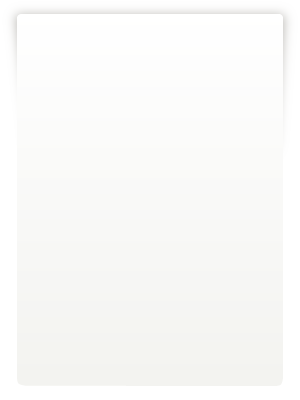
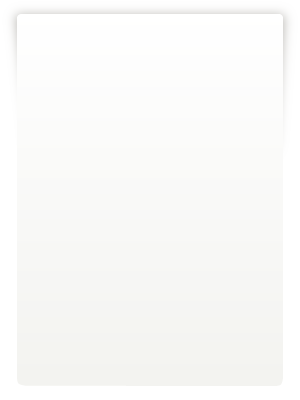
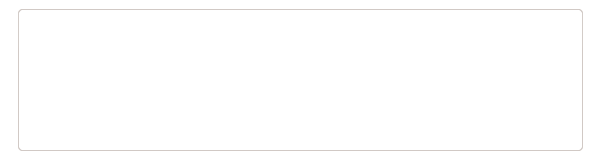
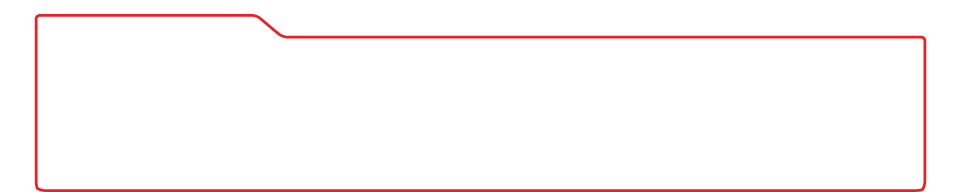
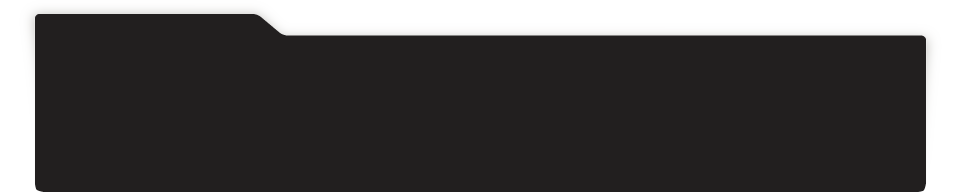
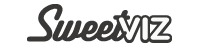
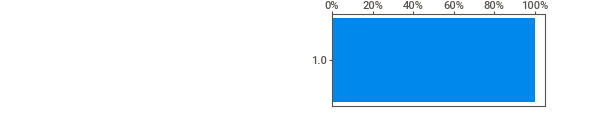
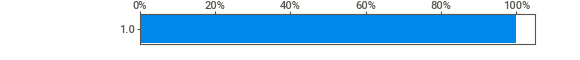
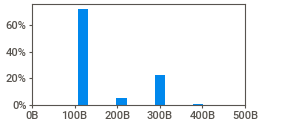
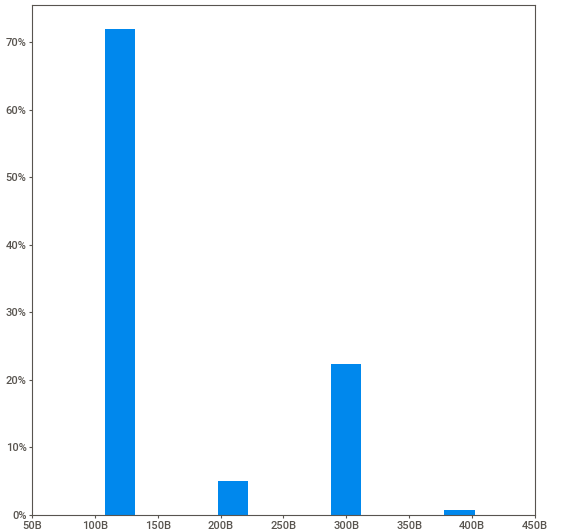
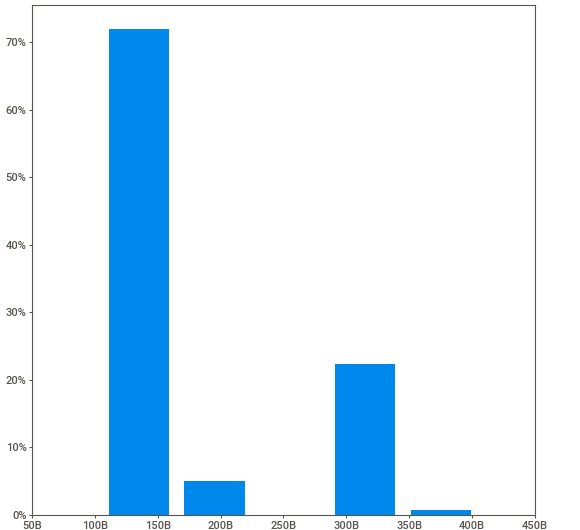
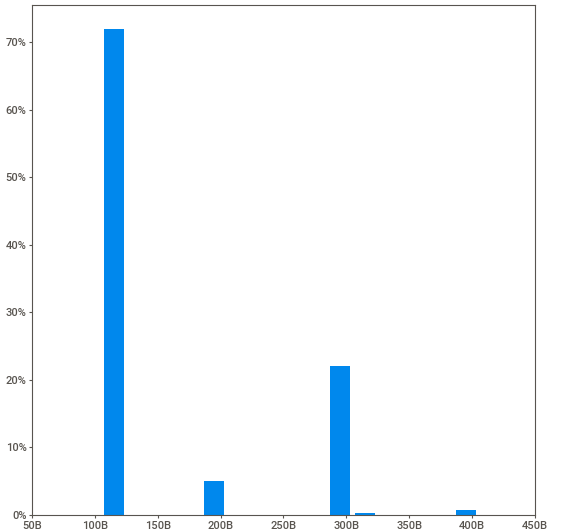
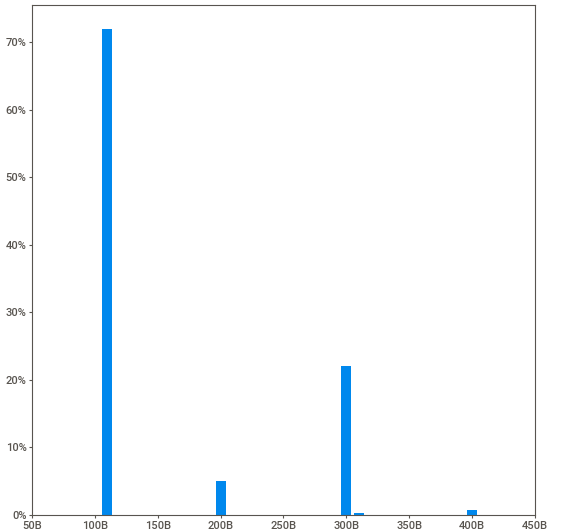
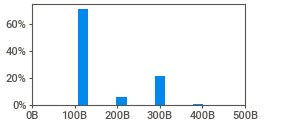
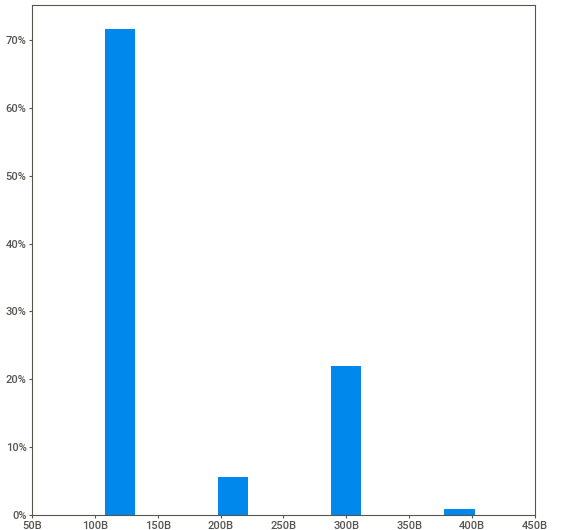
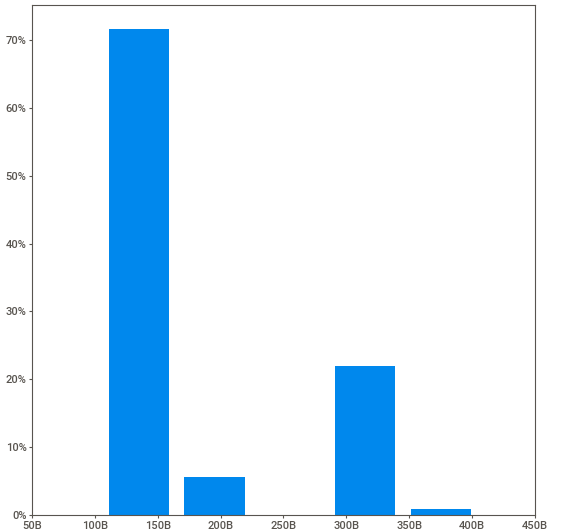
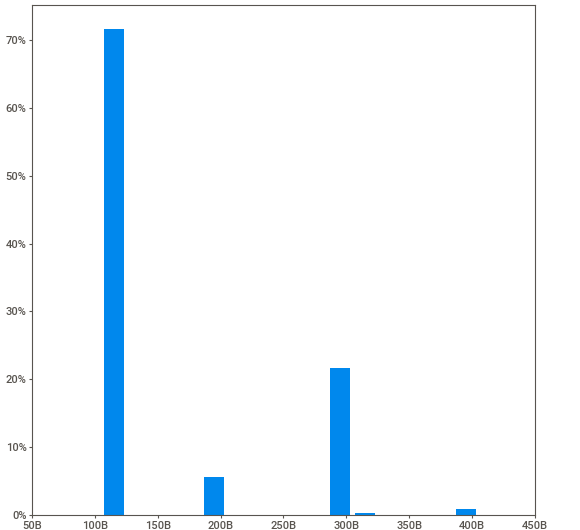
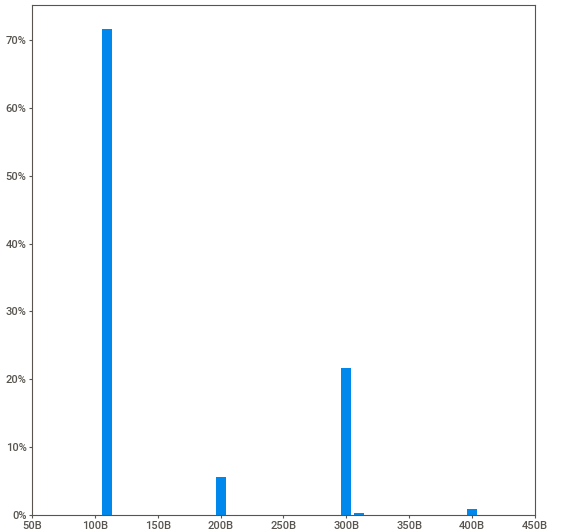
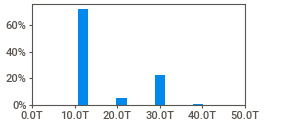
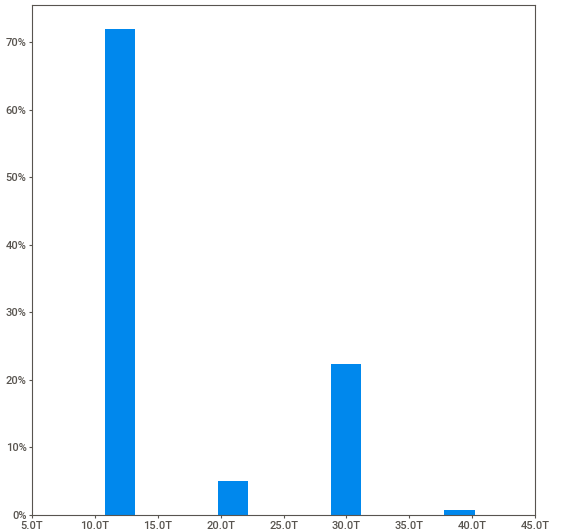
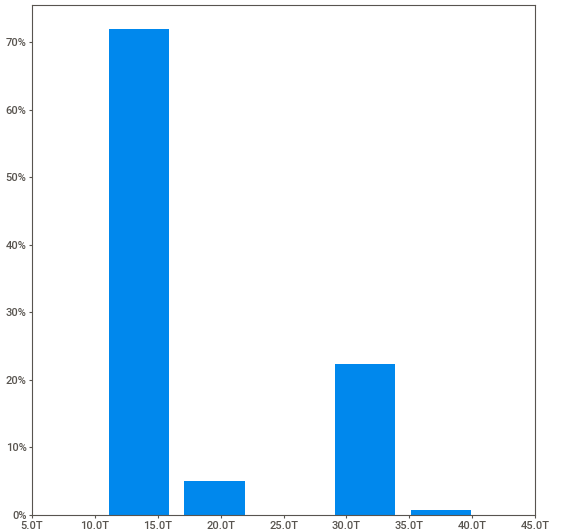
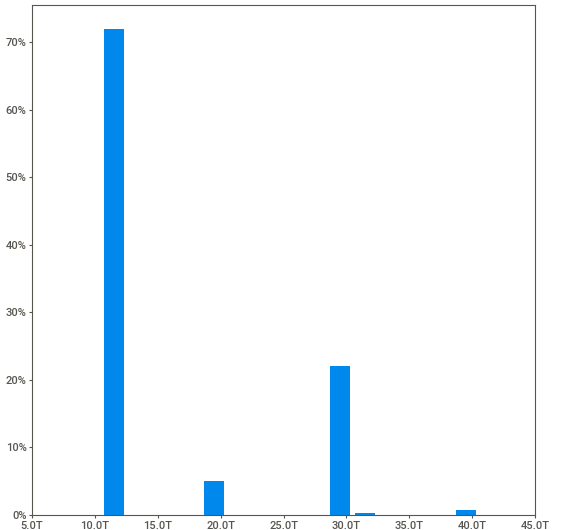
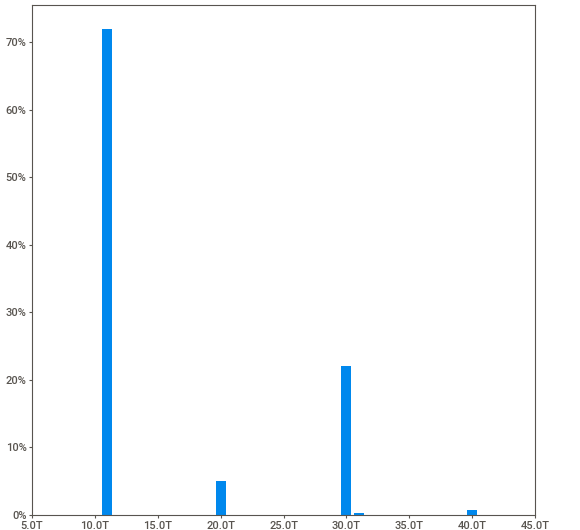
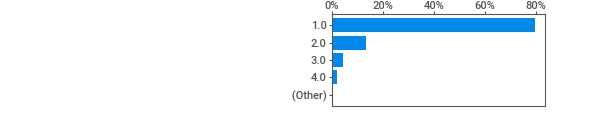
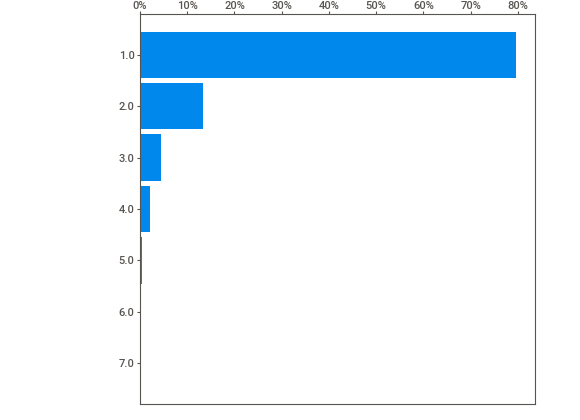
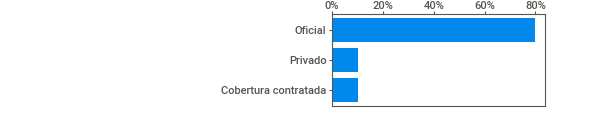
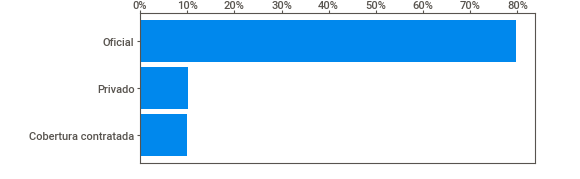
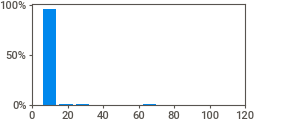
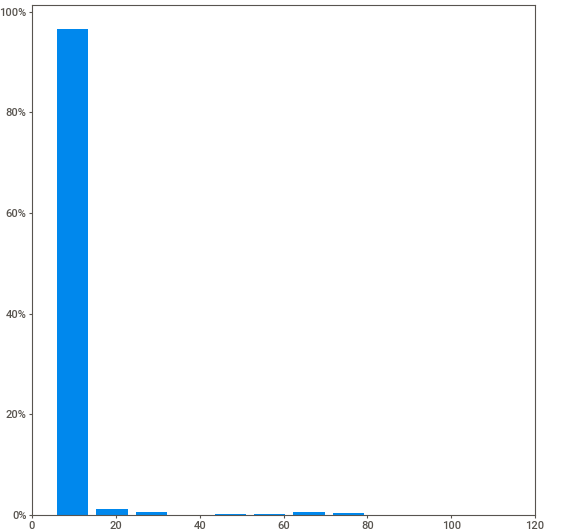
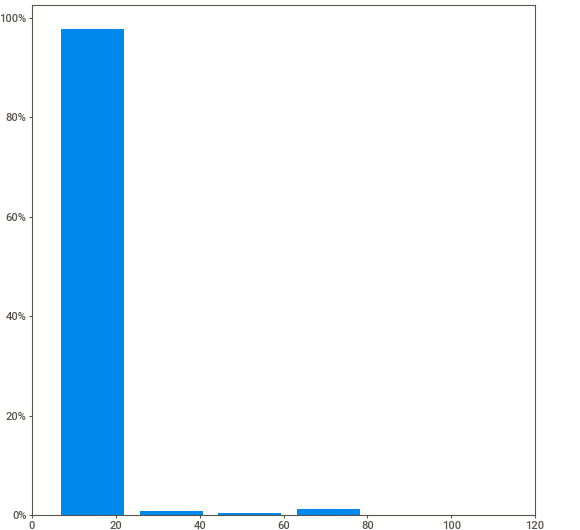
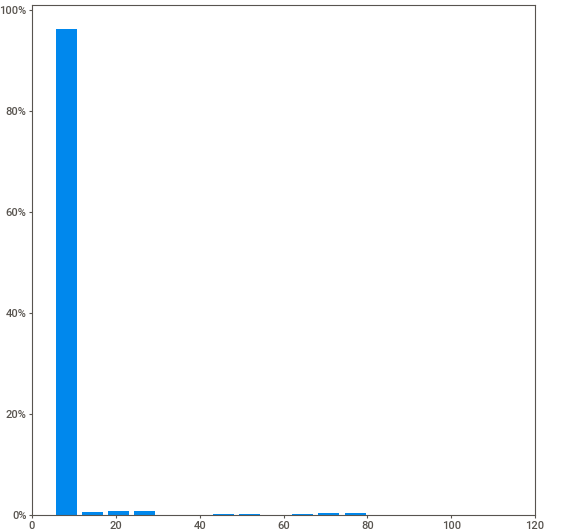
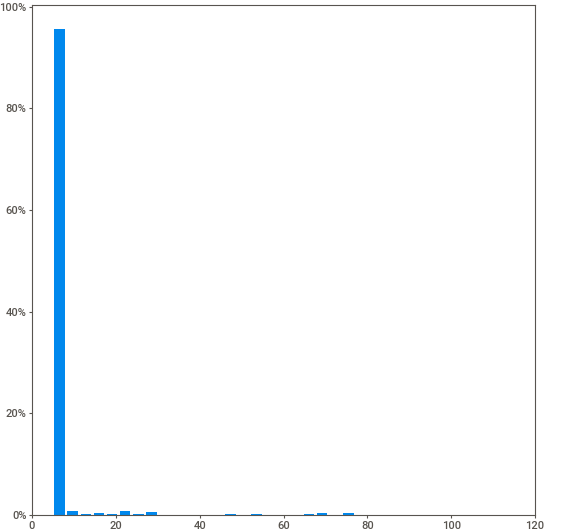
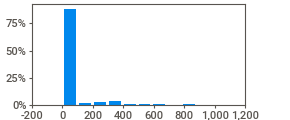
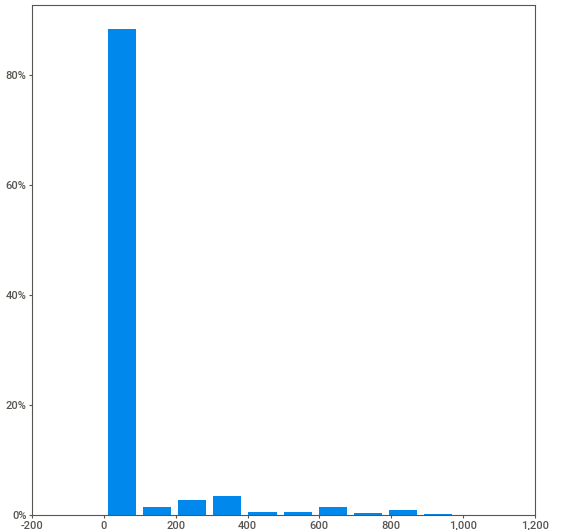
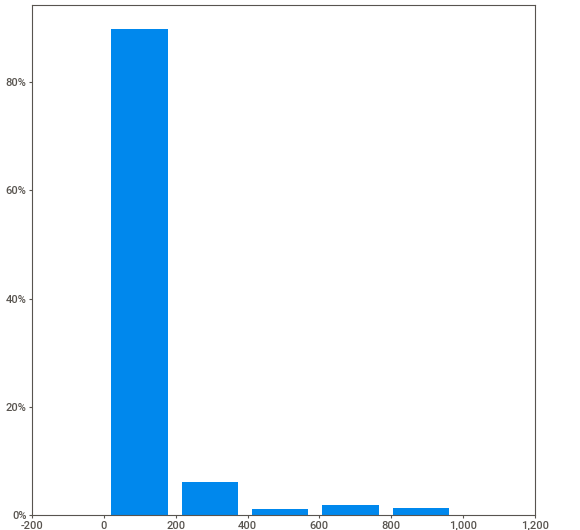
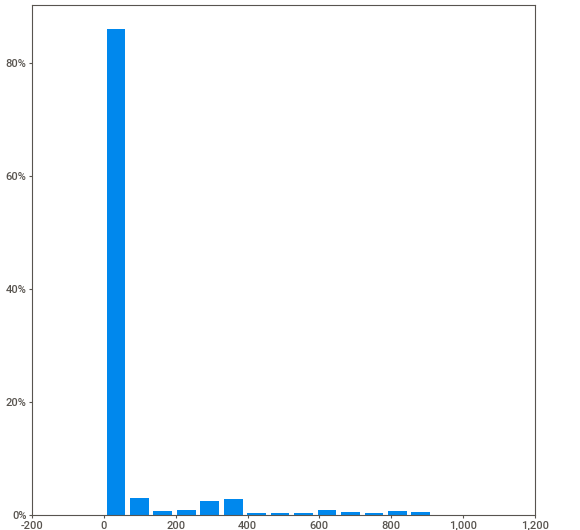
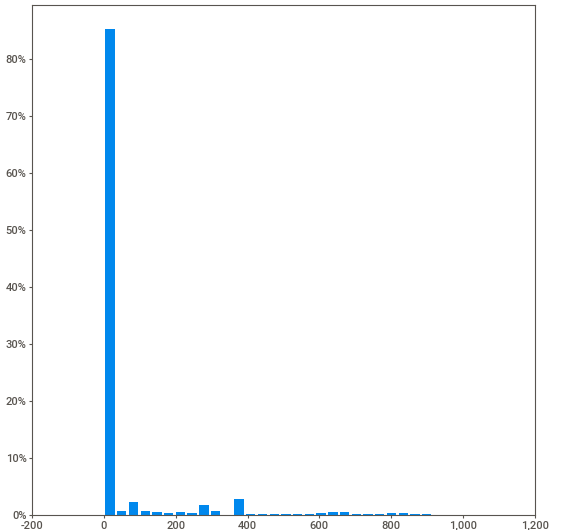
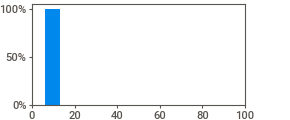
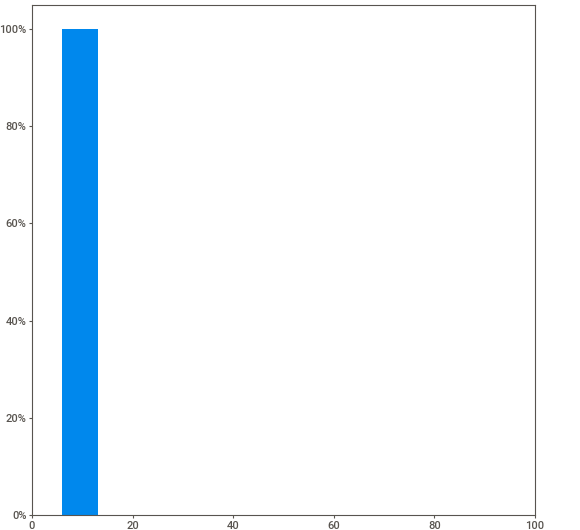
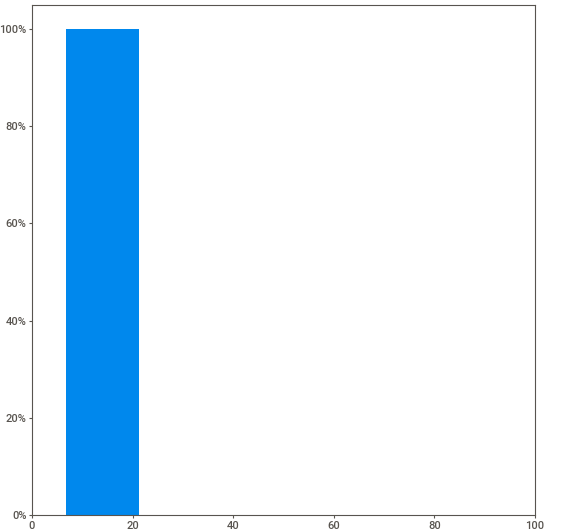
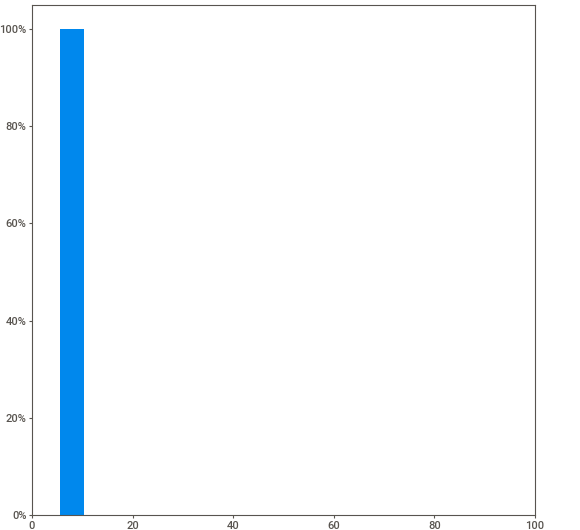
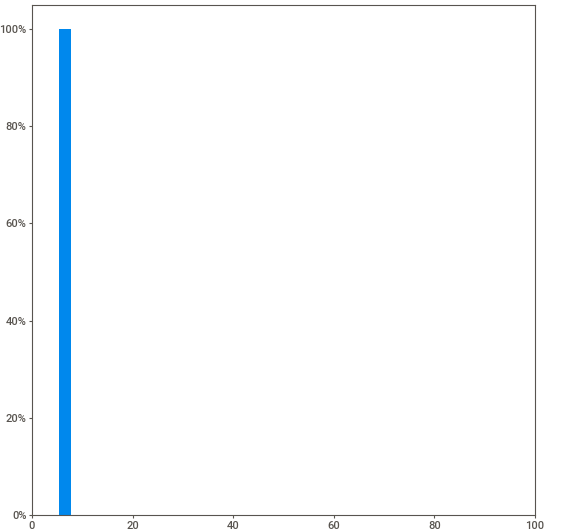
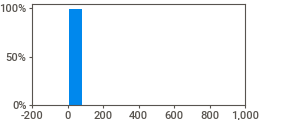
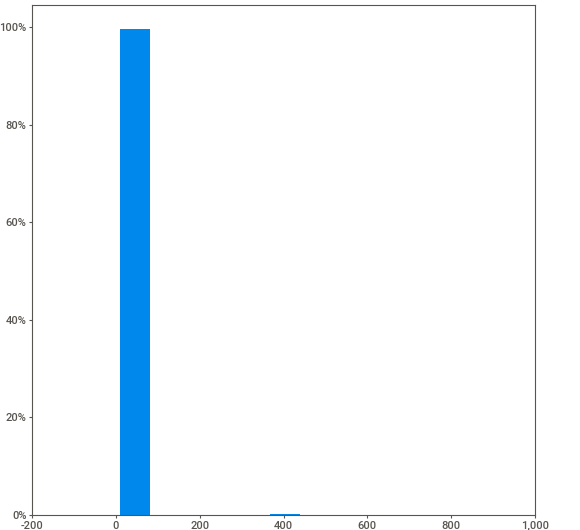
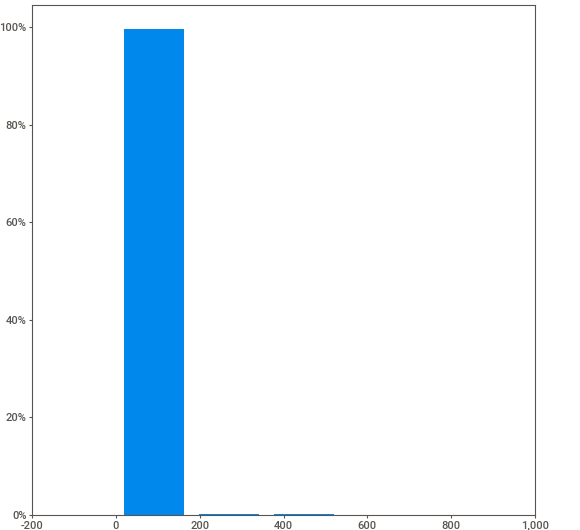
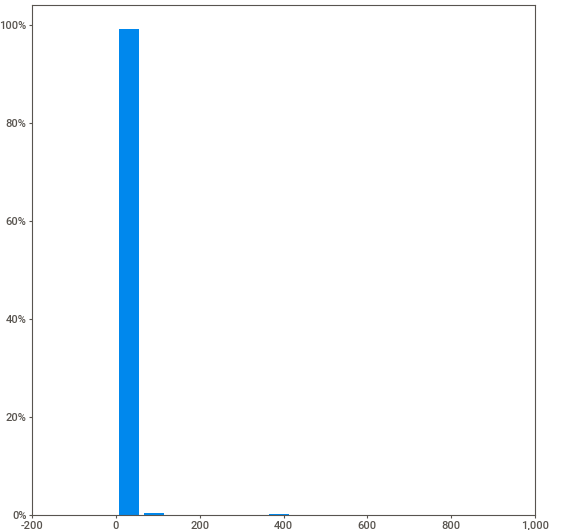
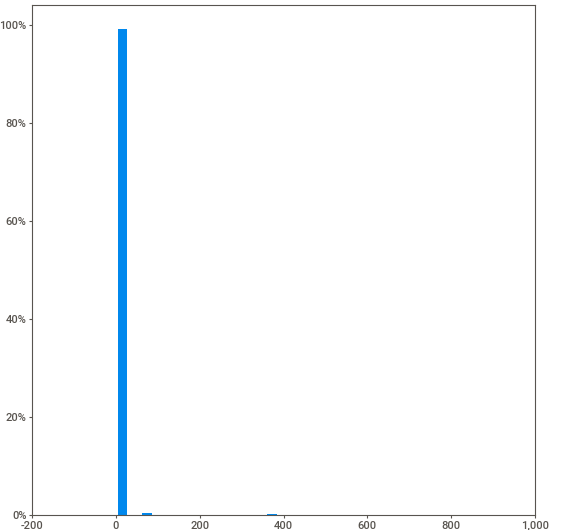
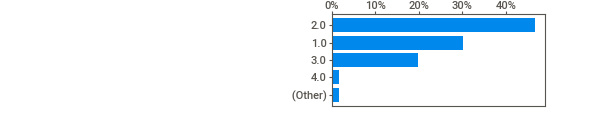
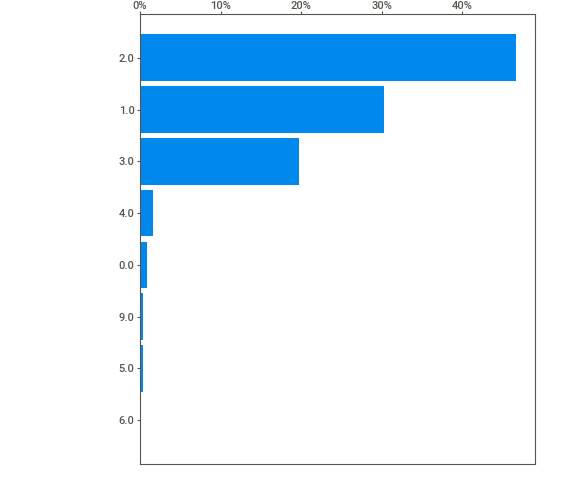
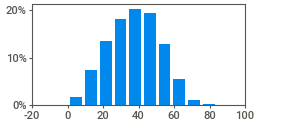
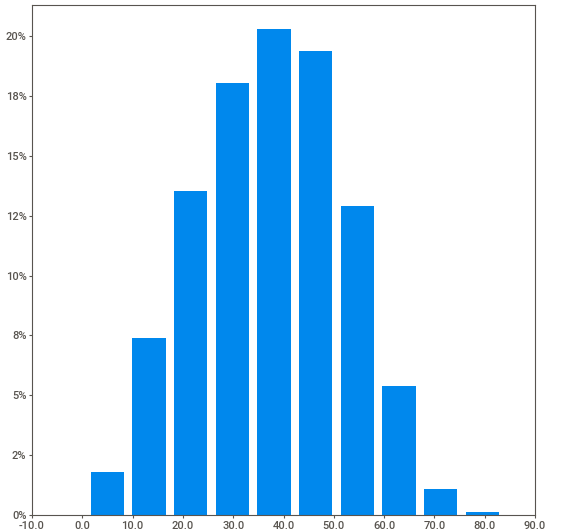
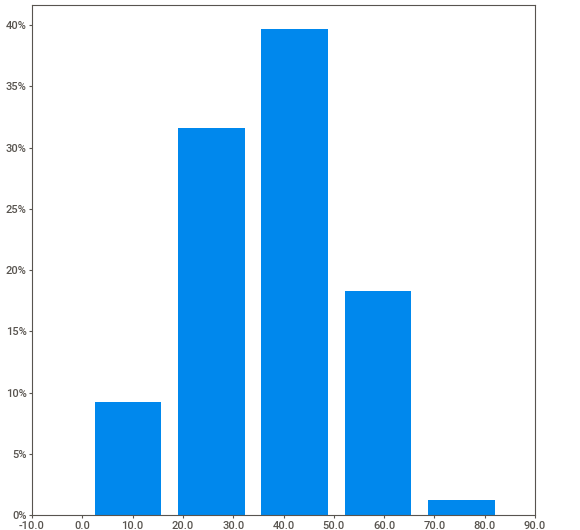
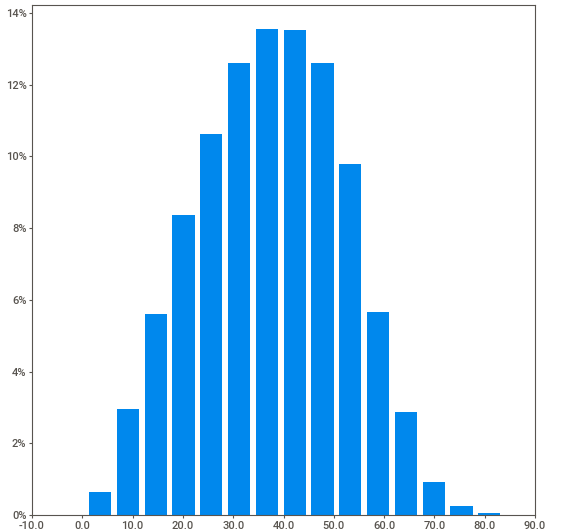
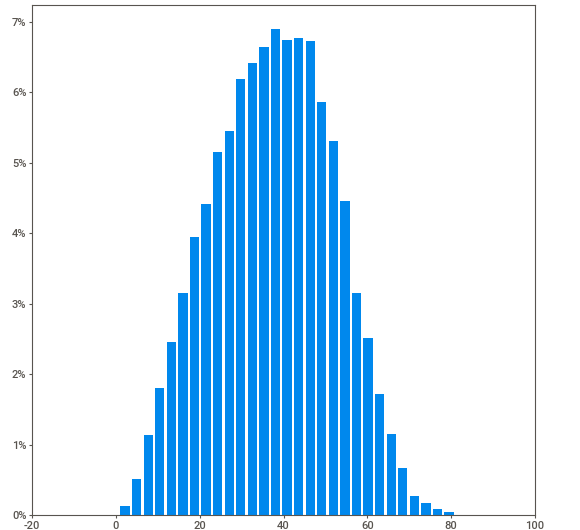
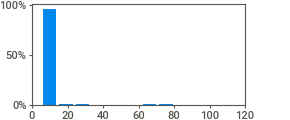
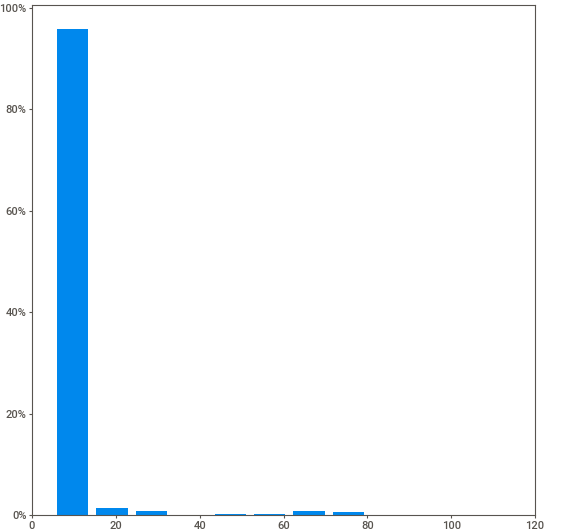
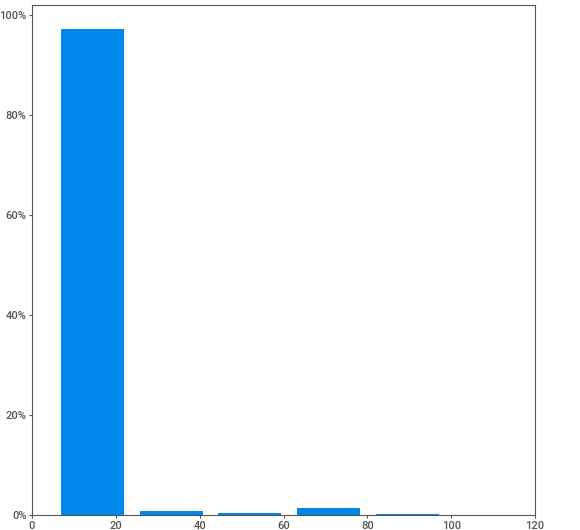
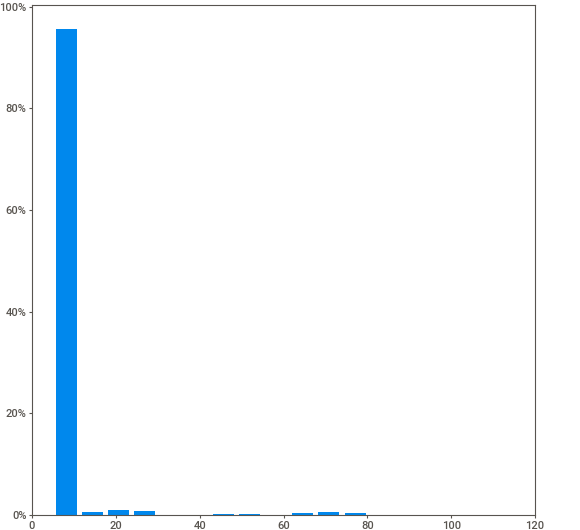
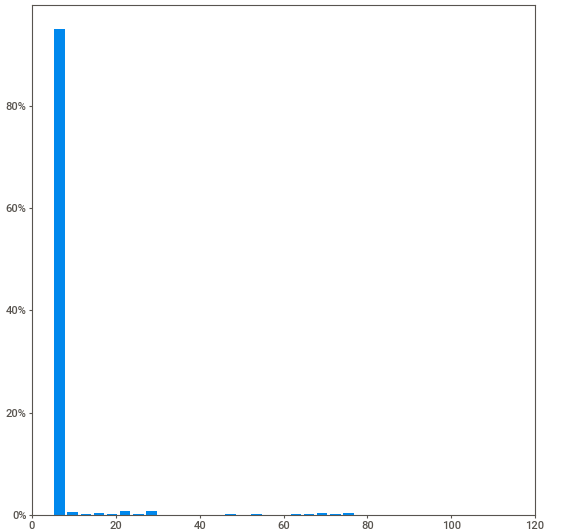
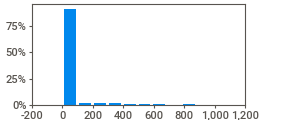
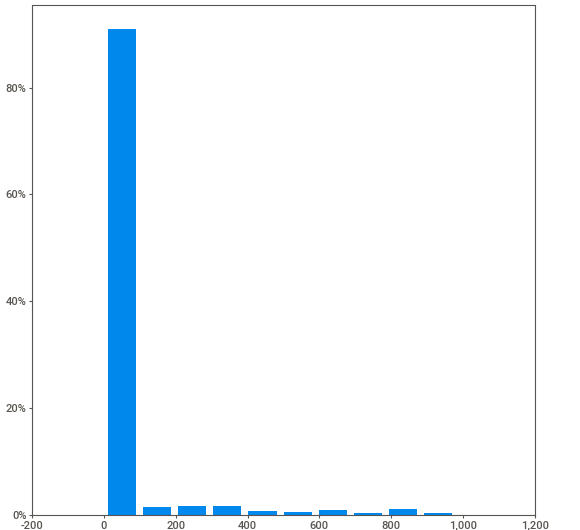
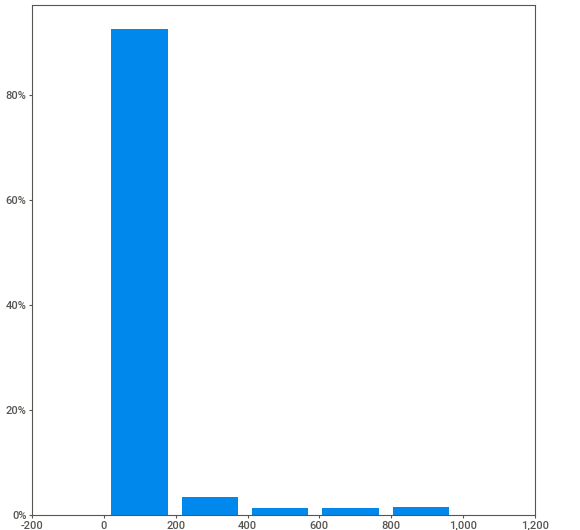
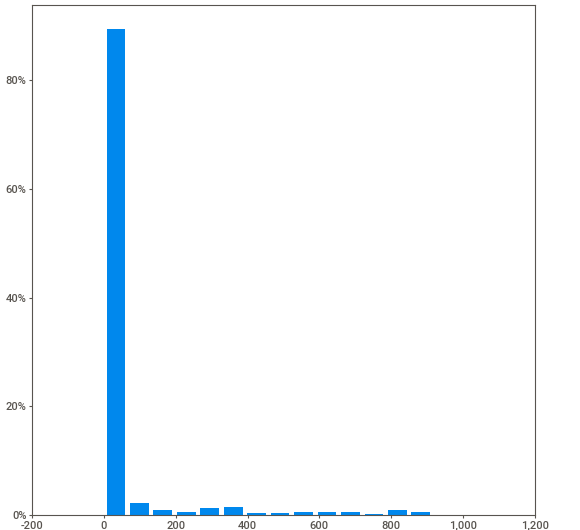
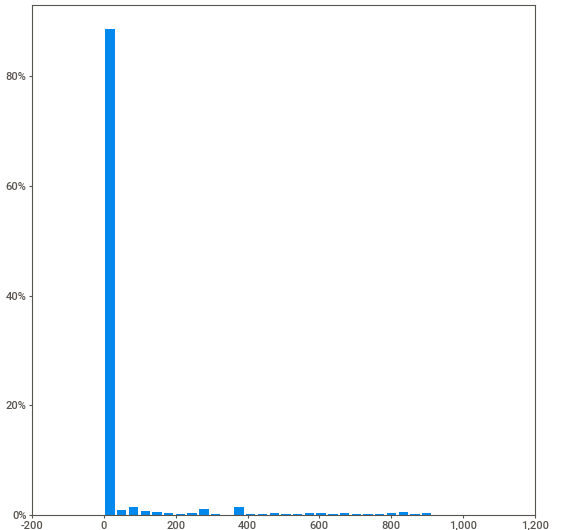
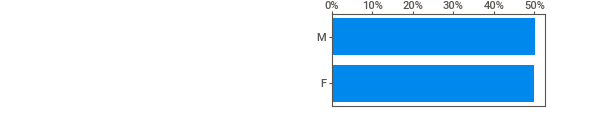
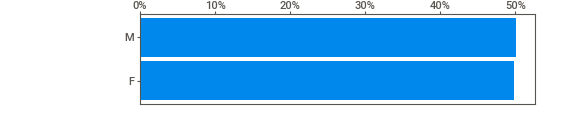
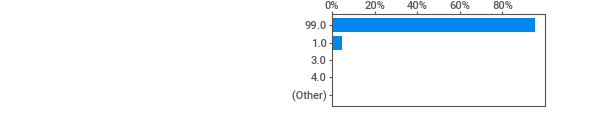
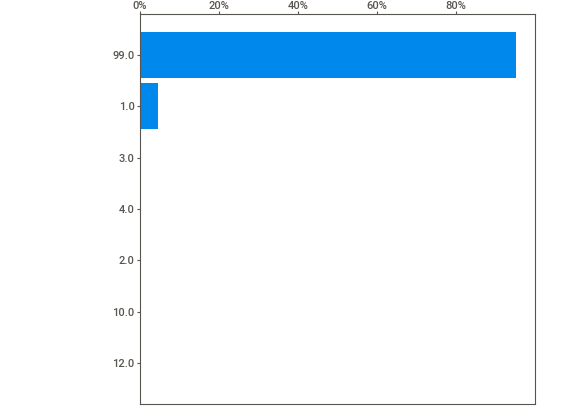
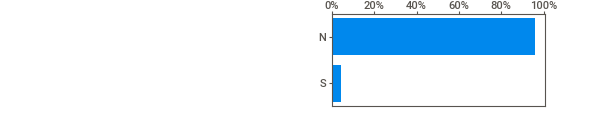
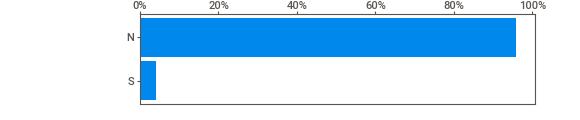
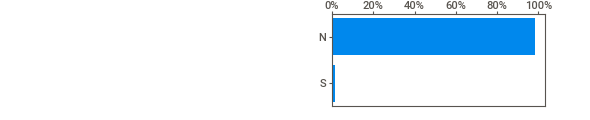
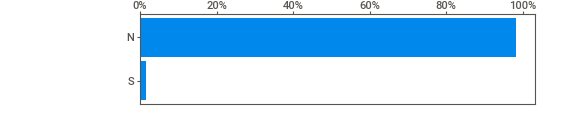
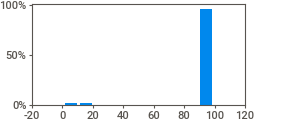
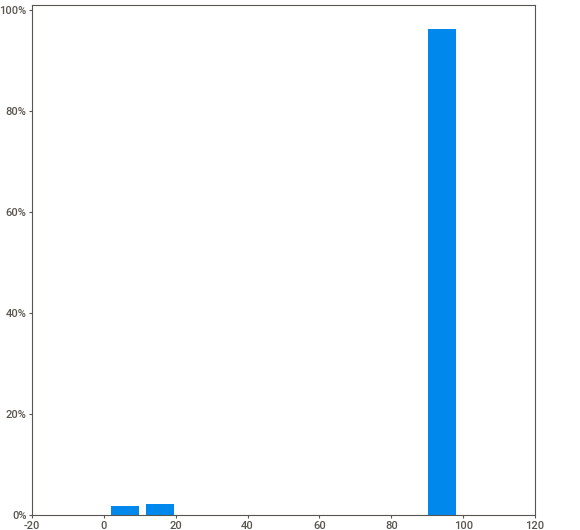
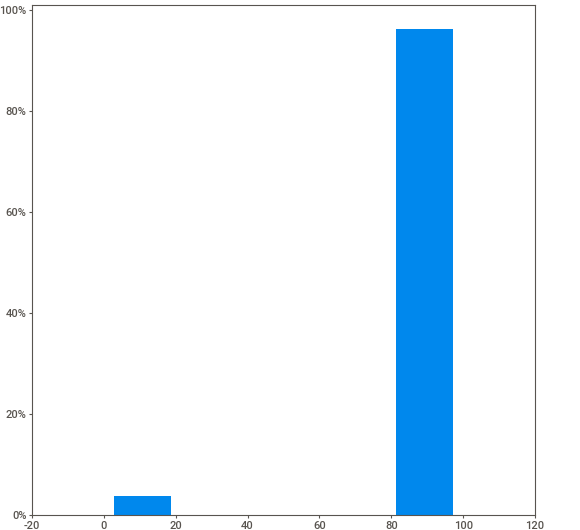
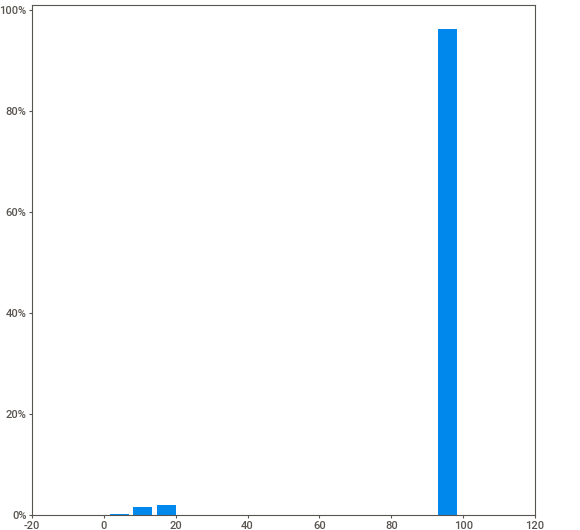
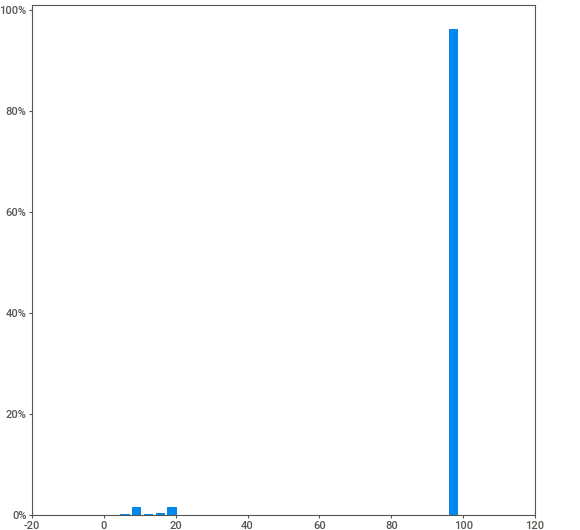
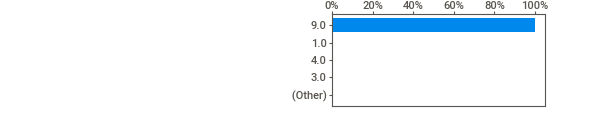
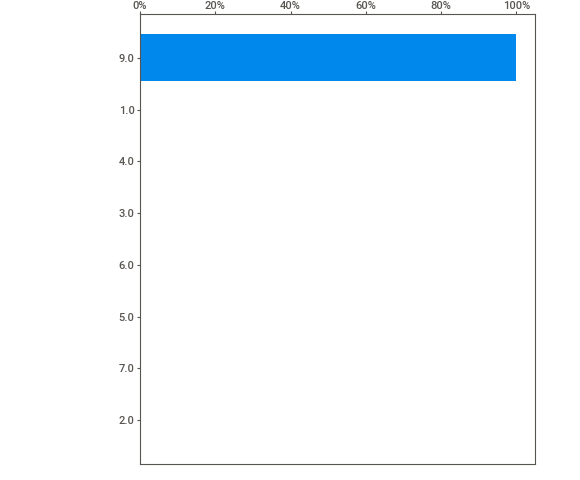
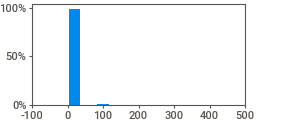
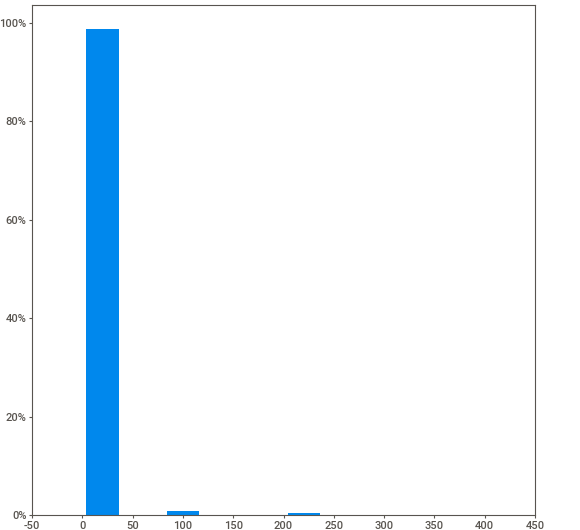
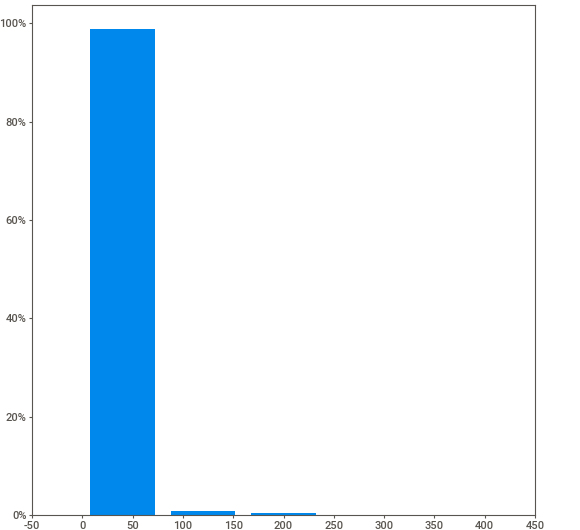
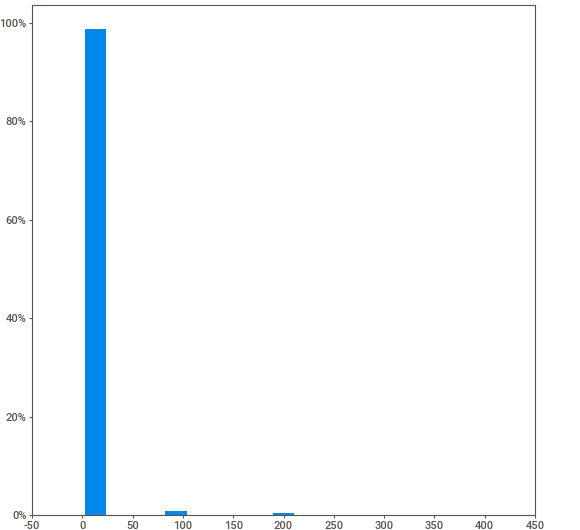
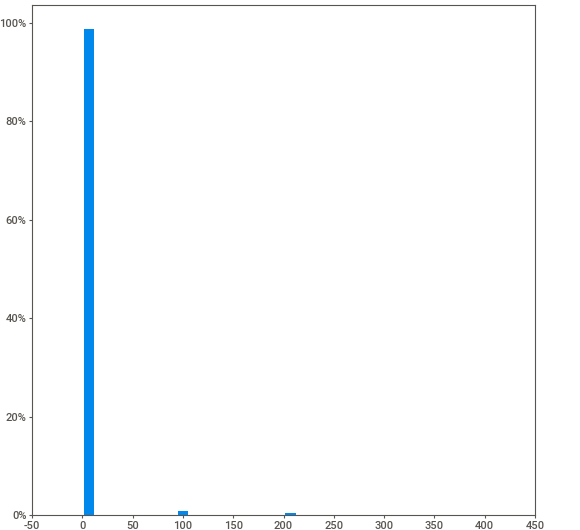
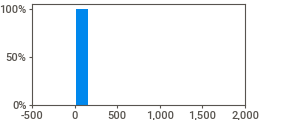
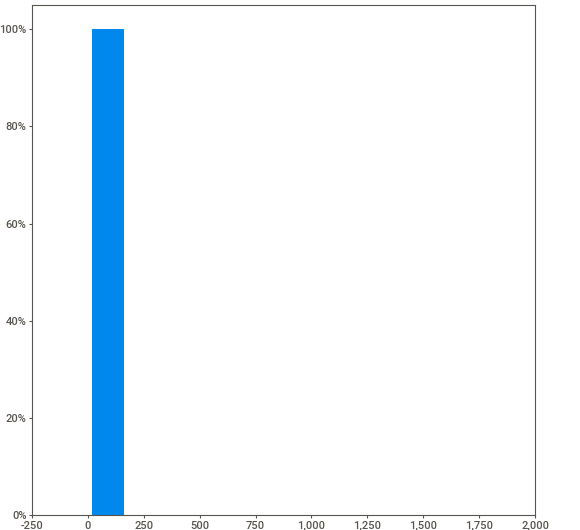
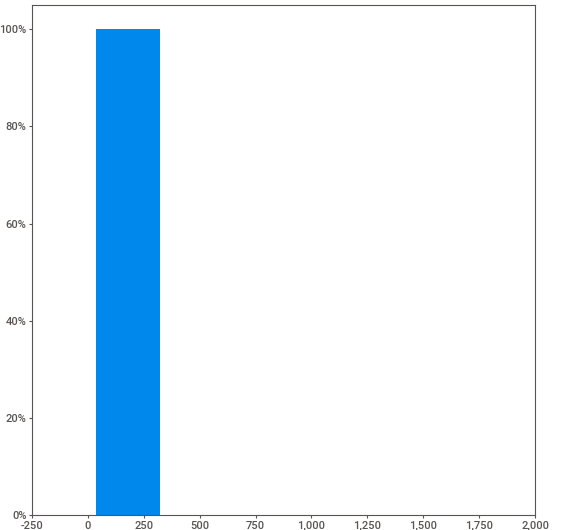
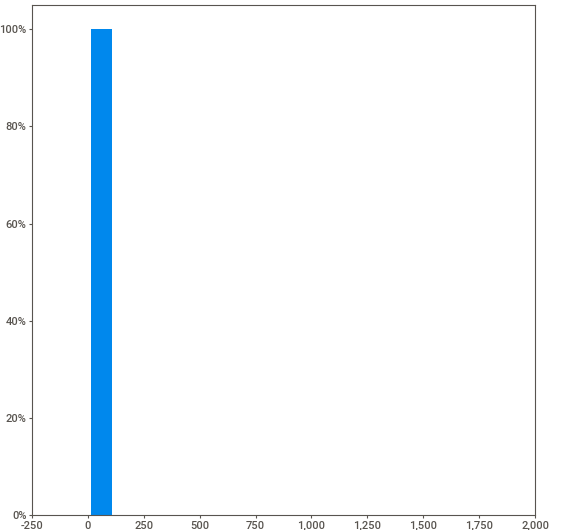
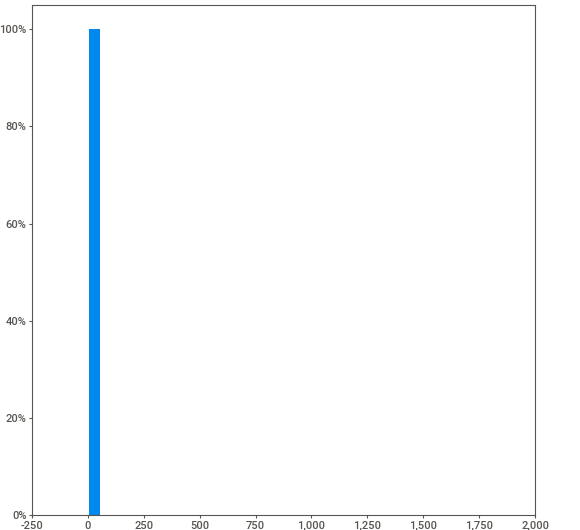
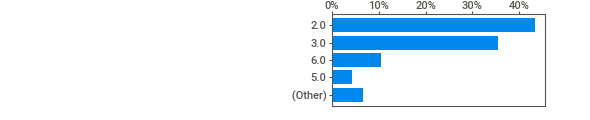
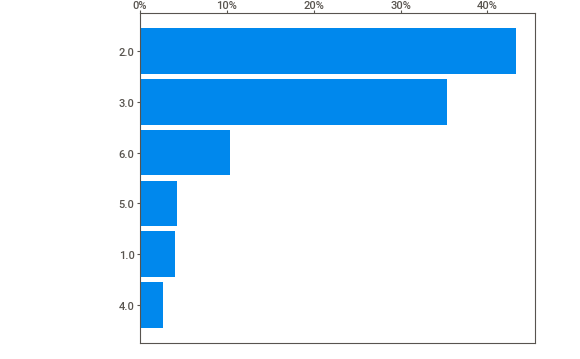
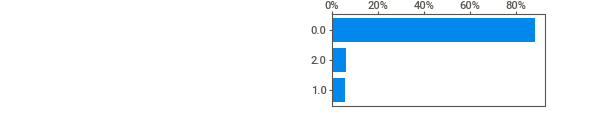
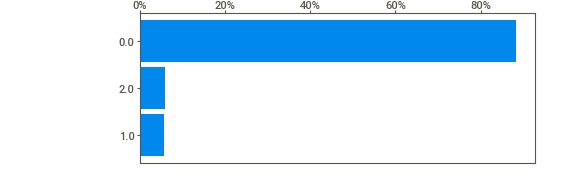
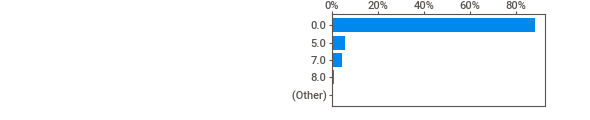
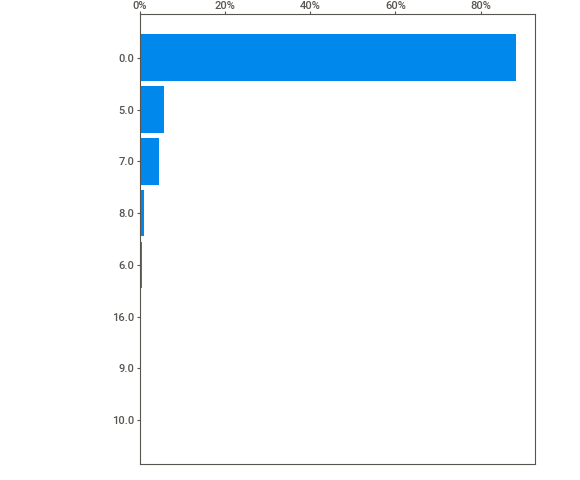
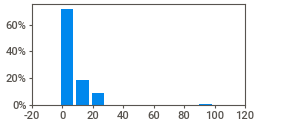
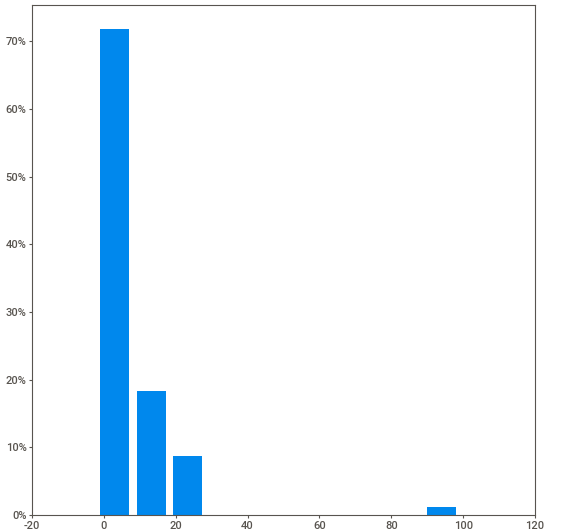
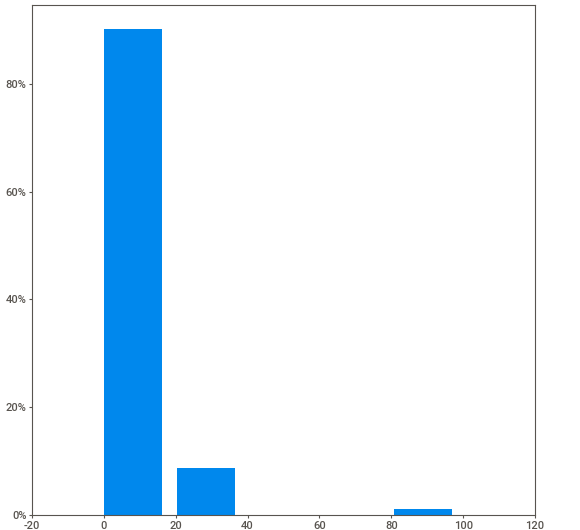
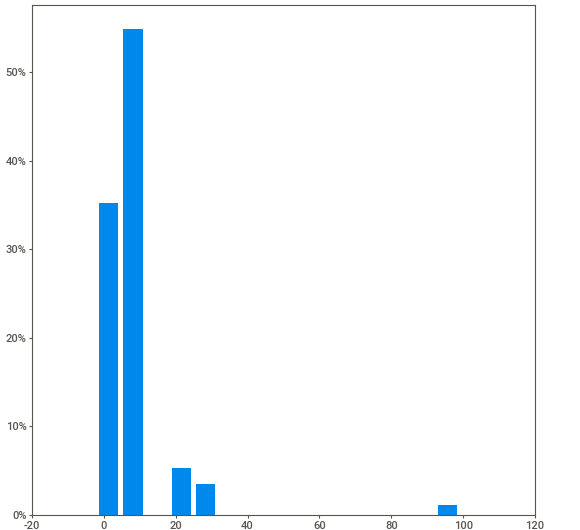
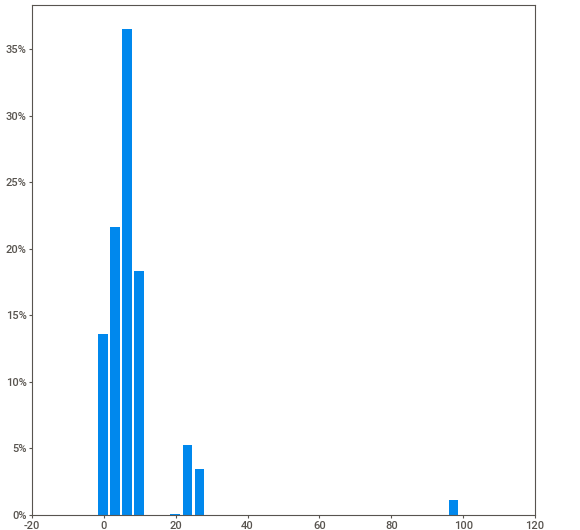
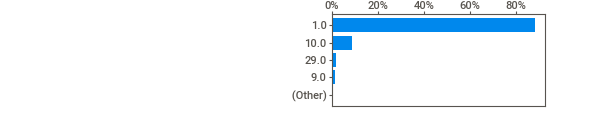
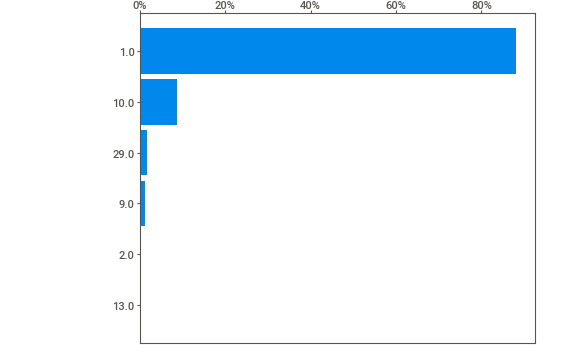
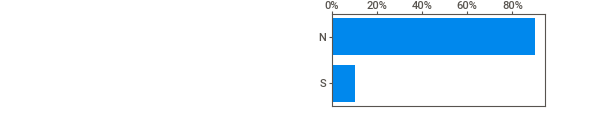
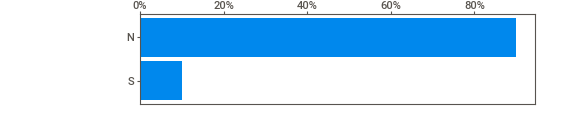
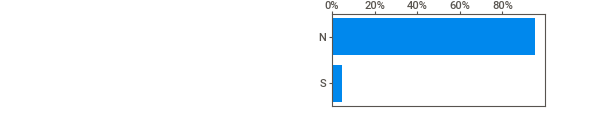
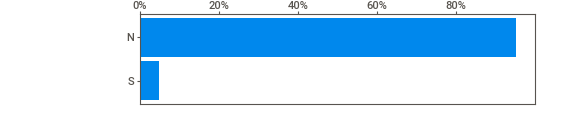
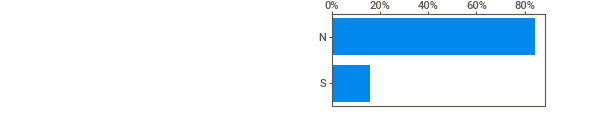
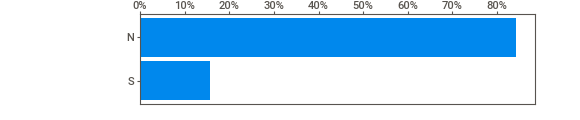
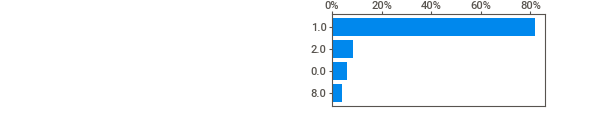
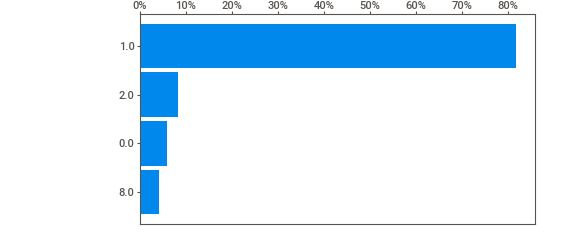
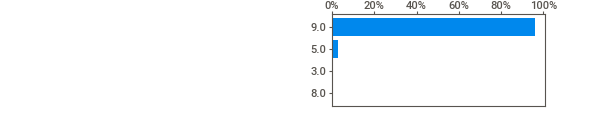
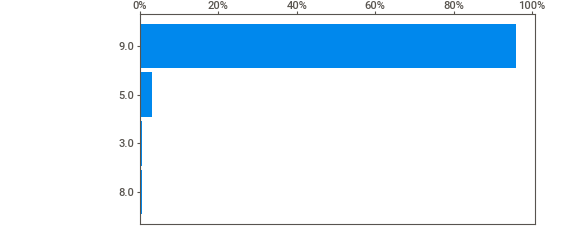
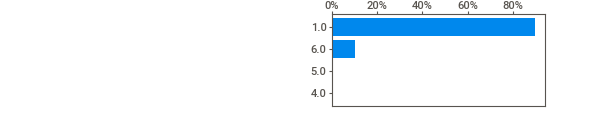
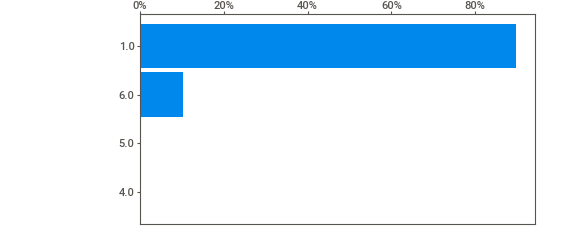
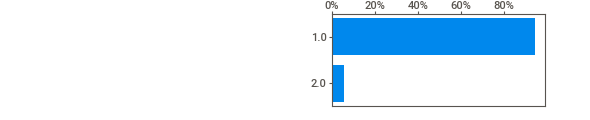
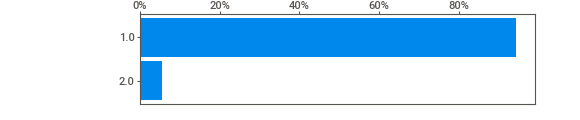
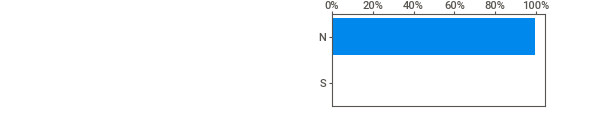
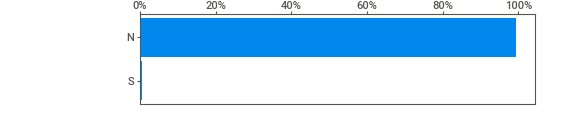
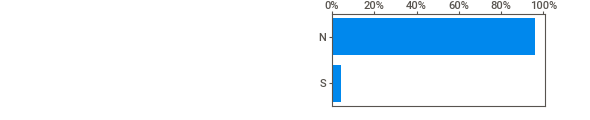
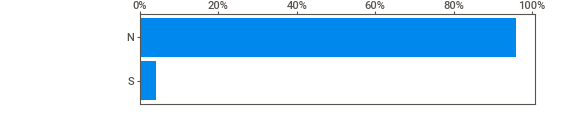
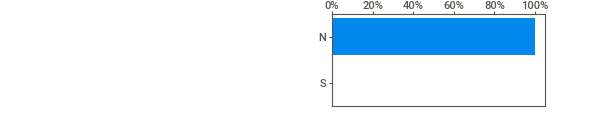
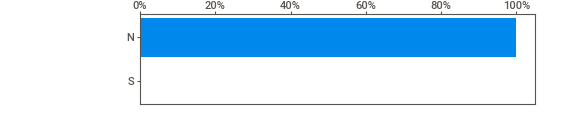
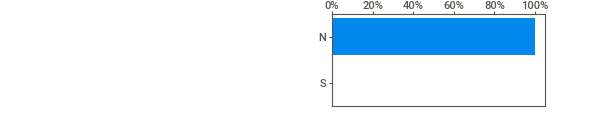
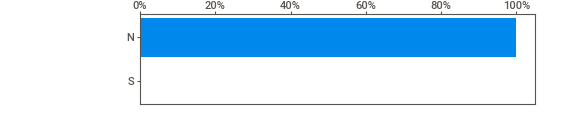
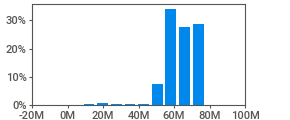
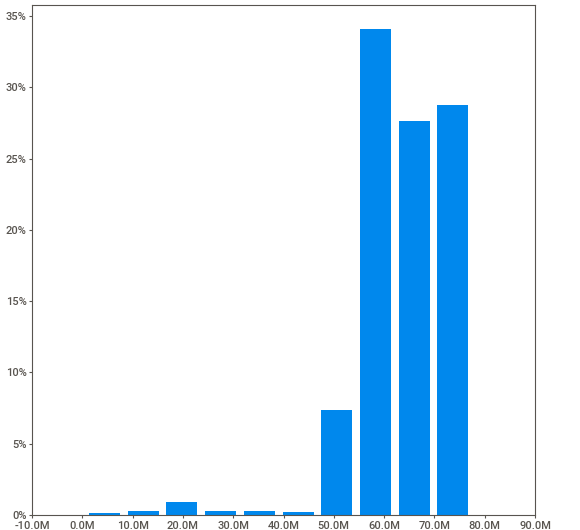
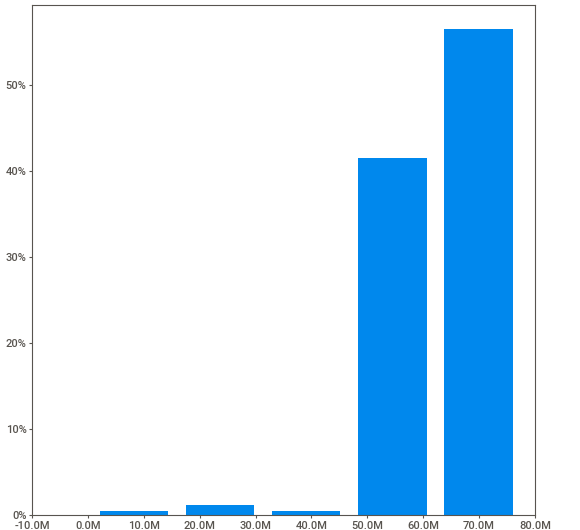
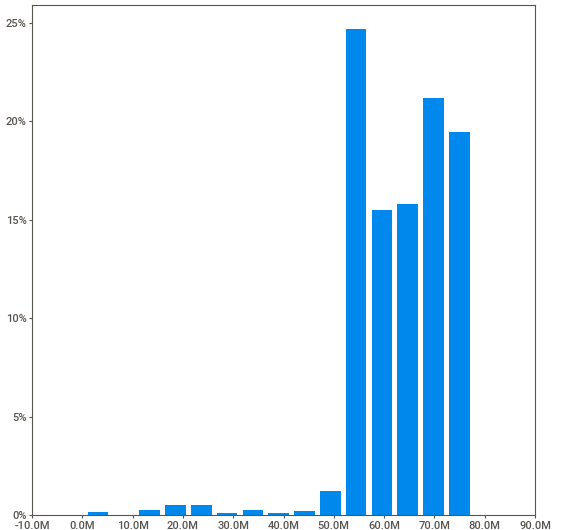
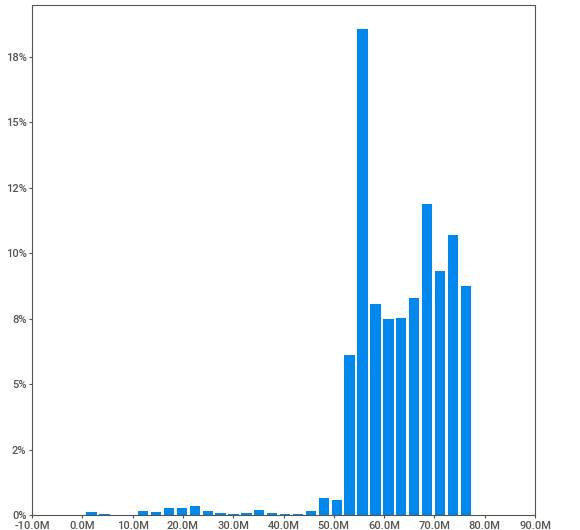
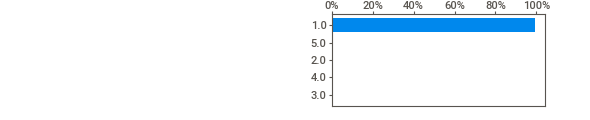
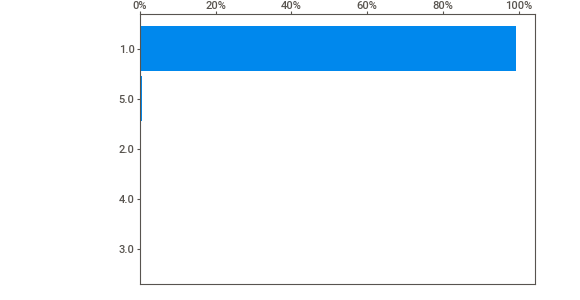
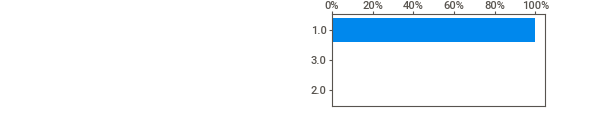
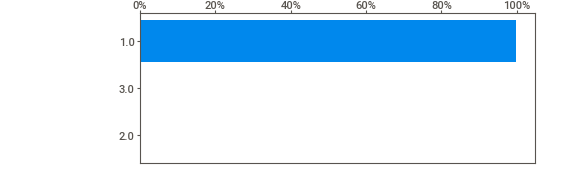
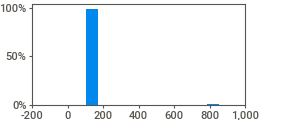
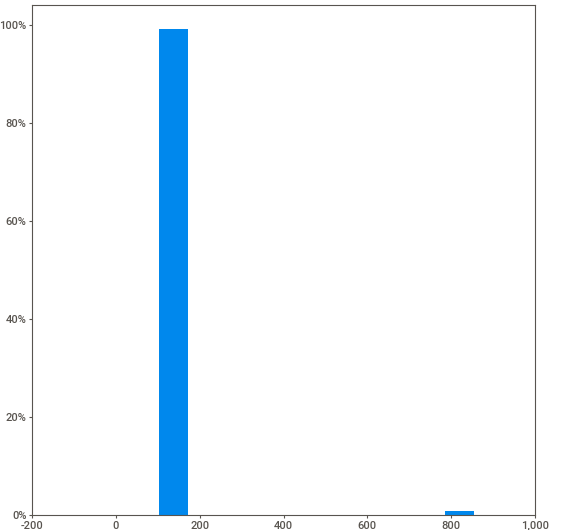
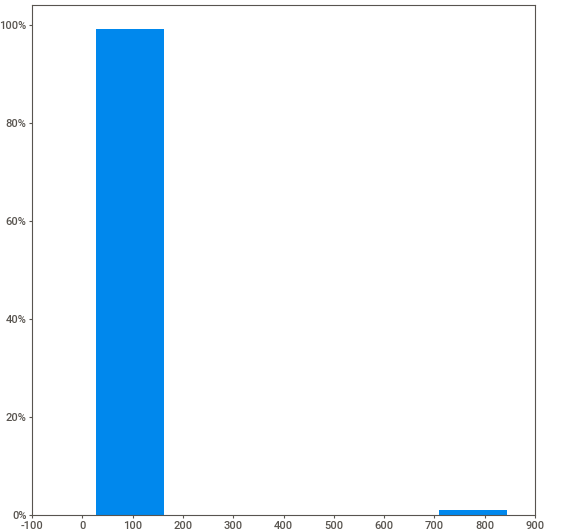
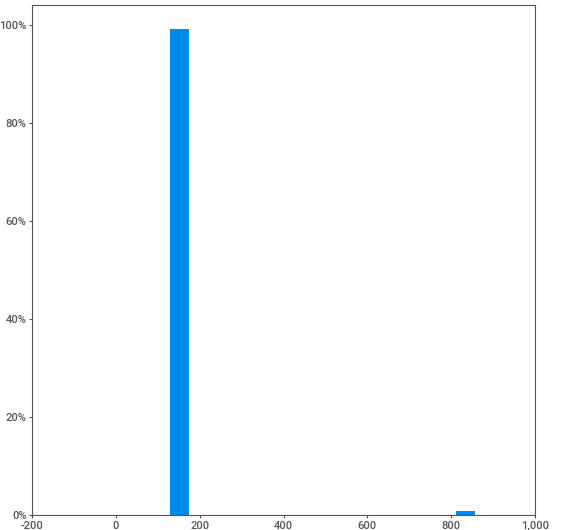
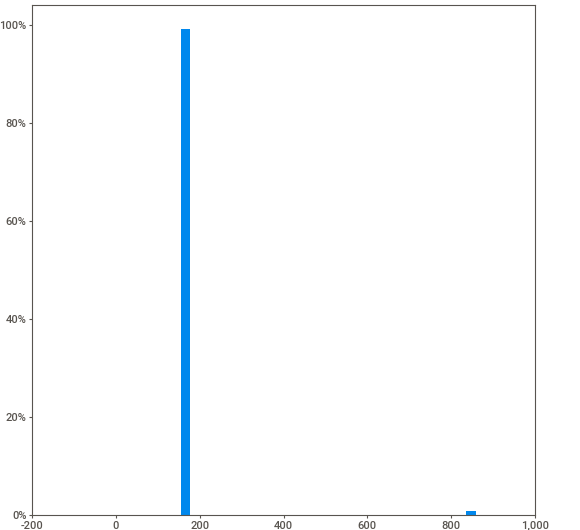
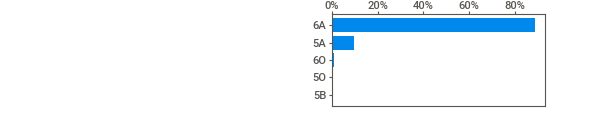
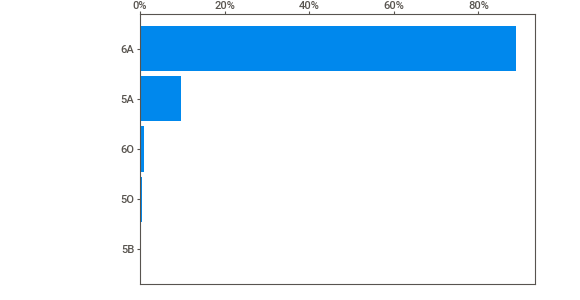
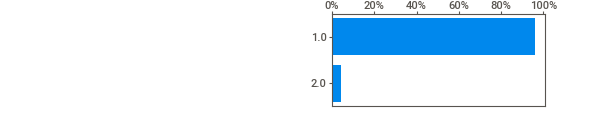
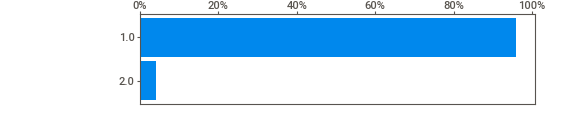
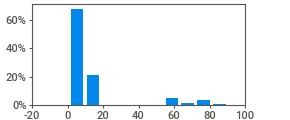
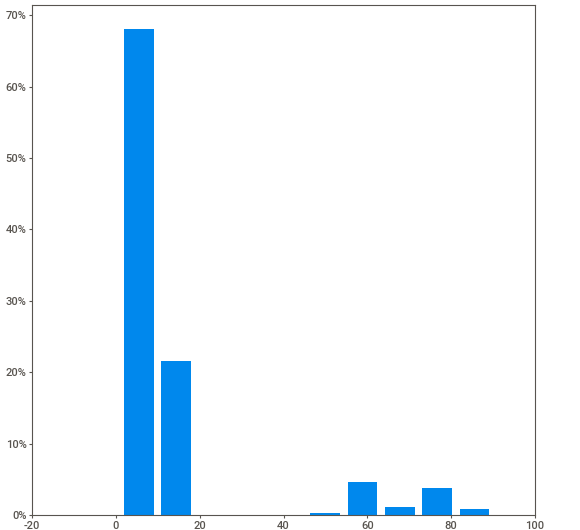
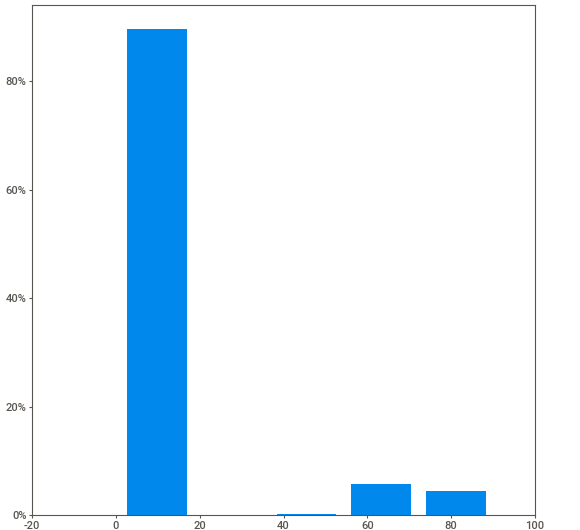
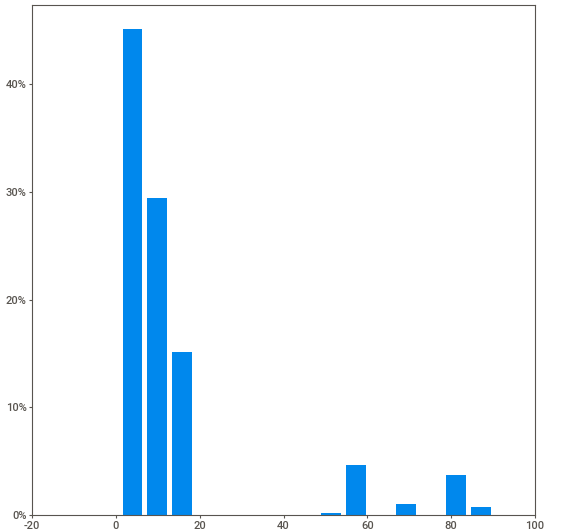
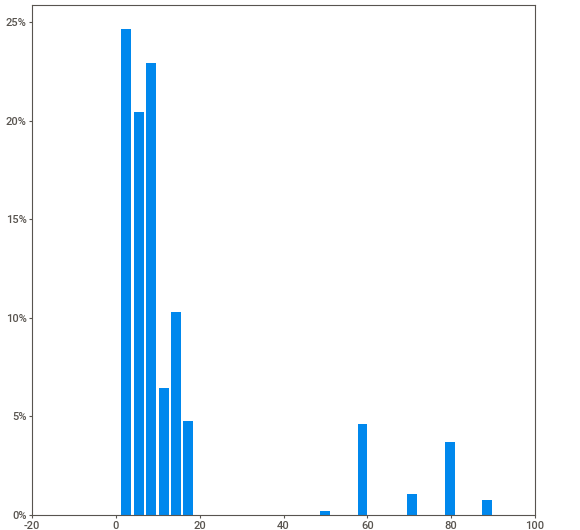
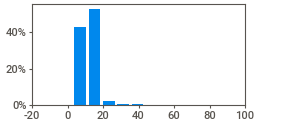
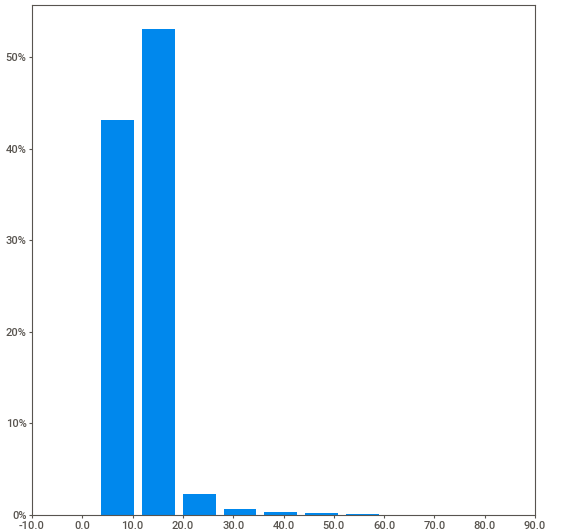
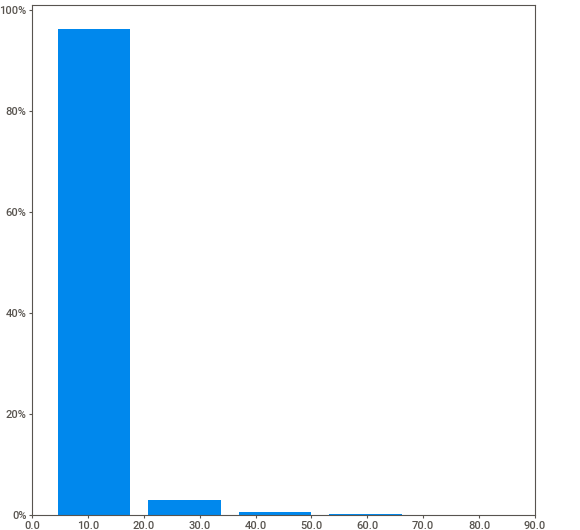
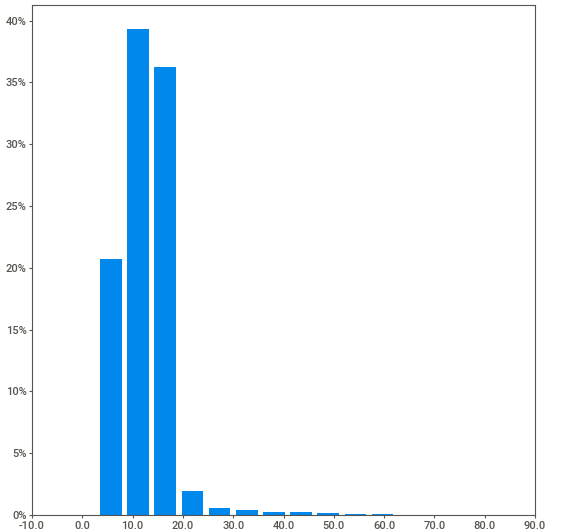
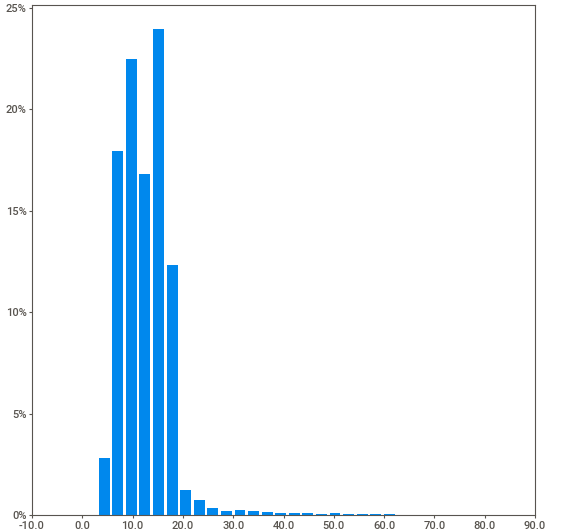
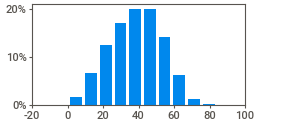
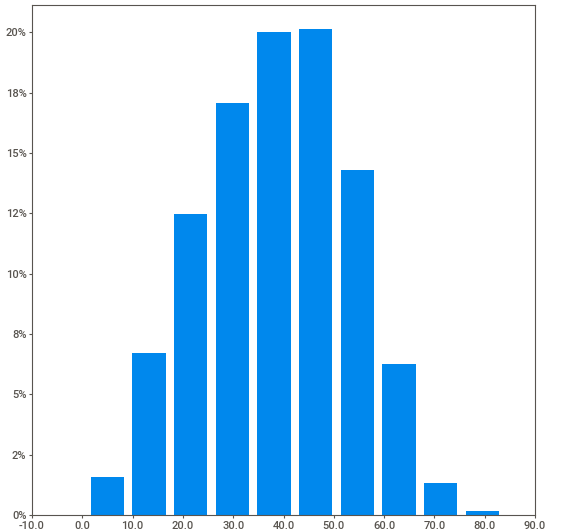
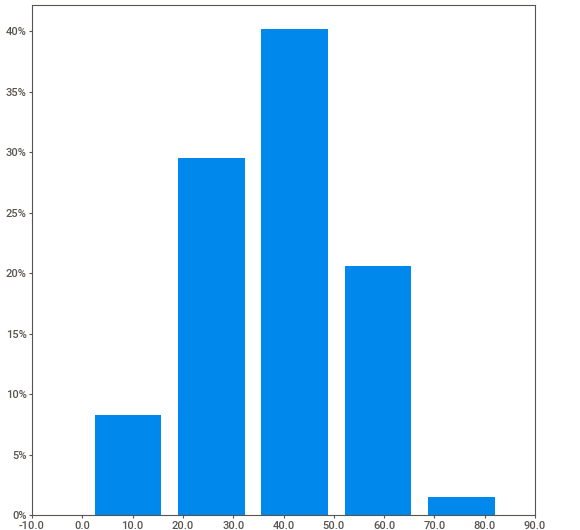
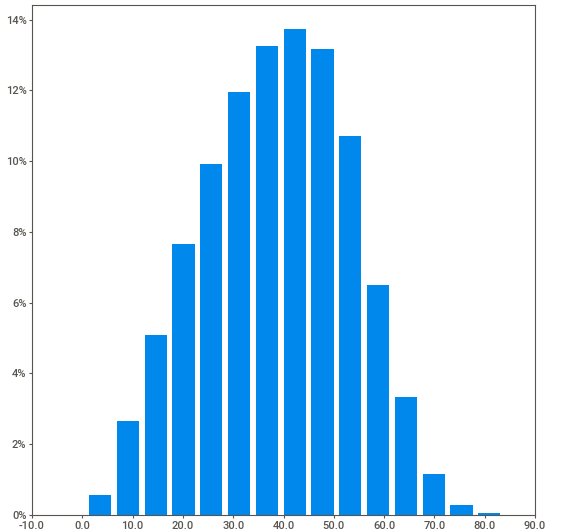
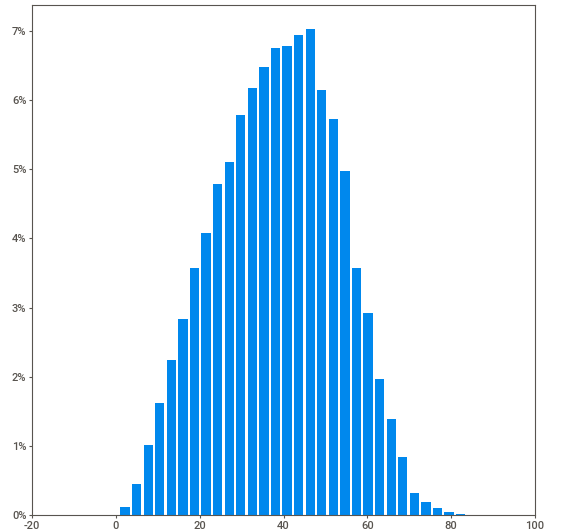
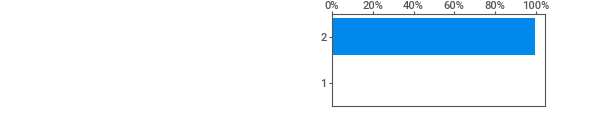
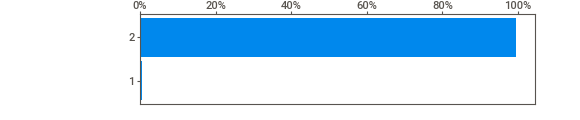
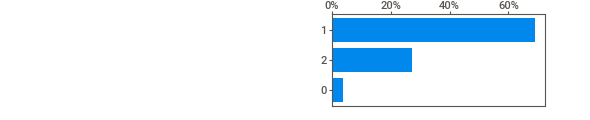
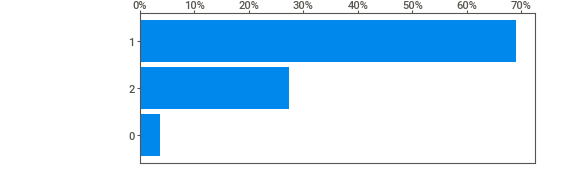
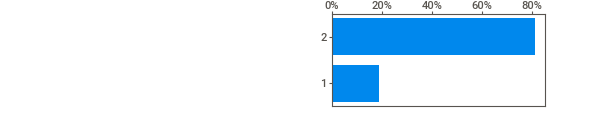
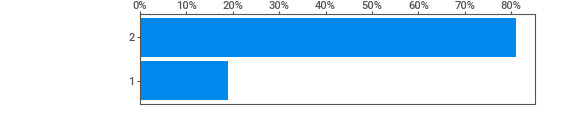
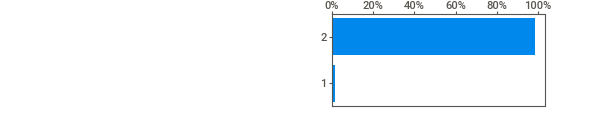
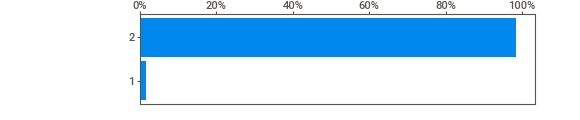
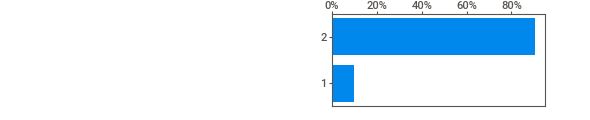
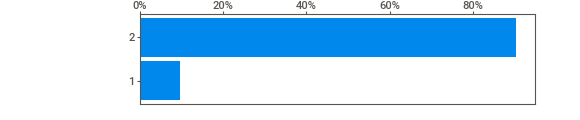
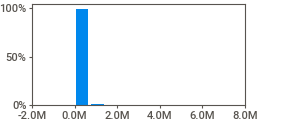
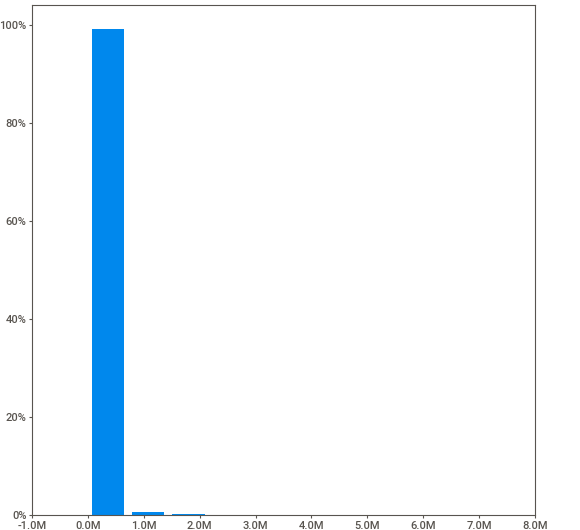
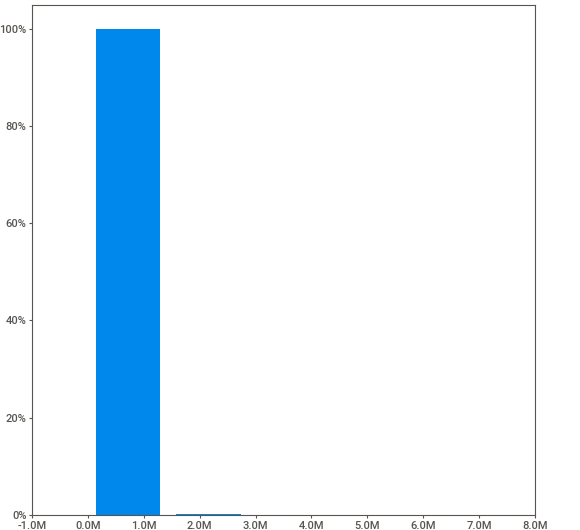
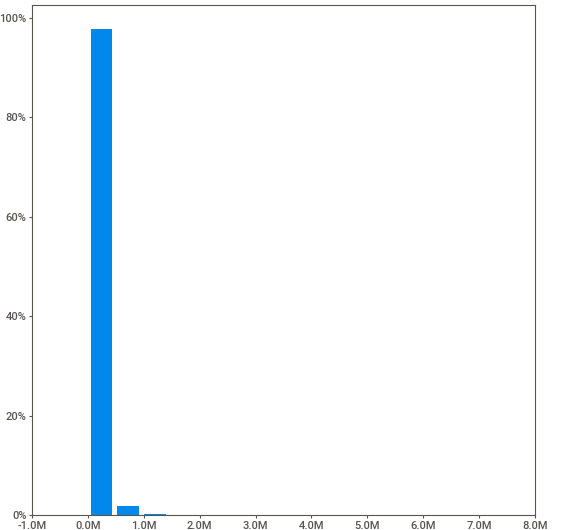
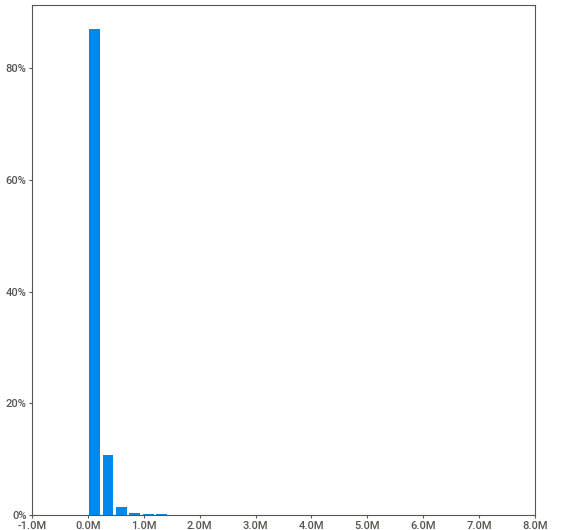
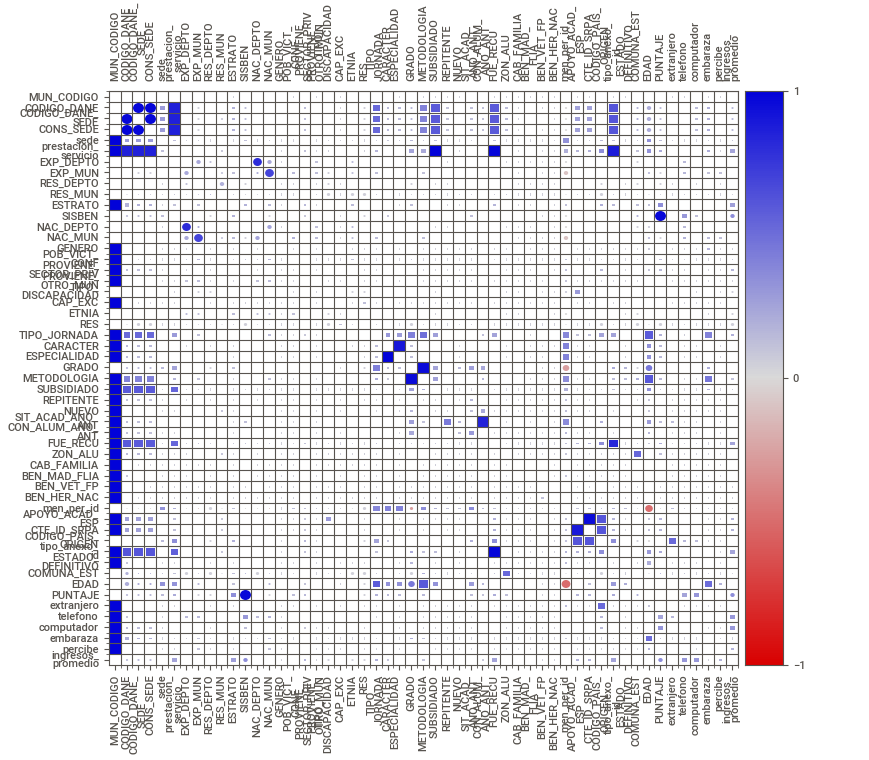
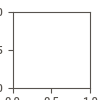

In [15]:
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='vertical')

## Extracción de características

### Depuración de variables

A partir de la identificación y análisis de cada una de las variables en la presente y pasadas iteraciones, se procede a depurar a aquellas que no se requieren para el modelo, dado a que son redundantes (están altamente correlacionadas con otras variables del Dataset que se mantiene) su nivel de importancia es muy bajo y/o contienen valores errados.

In [19]:
df_simat.drop(['index', 'MUN_CODIGO', 'CODIGO_DANE', 'CODIGO_DANE_SEDE', 'CONS_SEDE', 'GRUPO', 
               'sede', 'men_per_id','tipo_anexo_id', 'SISBEN', 'EXP_DEPTO', 'EXP_MUN', 'RES',
               'ESPECIALIDAD', 'FUE_RECU', 'RES_DEPTO', 'RES_MUN', 'NAC_DEPTO', 'NAC_MUN', 'CAP_EXC',
               'ETNIA', 'BEN_HER_NAC', 'BEN_VET_FP', 'CODIGO_PAIS_ORIGEN'], axis=1, inplace=True)

### Limpieza de los datos

Se realiza el análisis de las variables con valores nulos.

In [20]:
df_simat.isnull().sum()

prestacion_servicio         0
ESTRATO                     0
GENERO                      0
POB_VICT_CONF               0
PROVIENE_SECTOR_PRIV        0
PROVIENE_OTRO_MUN           0
TIPO_DISCAPACIDAD           0
TIPO_JORNADA                0
CARACTER                    0
GRADO                       0
METODOLOGIA                 0
SUBSIDIADO                  0
REPITENTE                   0
NUEVO                       0
SIT_ACAD_ANO_ANT            0
CON_ALUM_ANO_ANT            0
ZON_ALU                     0
CAB_FAMILIA                 0
BEN_MAD_FLIA                0
APOYO_ACAD_ESP          26116
CTE_ID_SRPA             26116
ESTADO_DEFINITIVO           0
COMUNA_EST                  0
EDAD                        0
PUNTAJE                     0
extranjero                  0
telefono                    0
computador                  0
embaraza                    0
percibe                     0
ingresos_promedio           0
dtype: int64

Se decide realizar la imputación de los valores nulos presentes en las columnas 'APOYO_ACAD_ESP' y 'CTE_ID_SRPA' por el valor de **0** dado a que este representa a los registros desconocidos.

In [21]:
columns_null_cero = ['APOYO_ACAD_ESP', 'CTE_ID_SRPA']
for i in columns_null_cero:
    df_simat[i] = df_simat[i].replace({np.nan: '0'})

Se valida que el Dataset ya no contenga valores nulos.

In [22]:
df_simat.isnull().sum()

prestacion_servicio     0
ESTRATO                 0
GENERO                  0
POB_VICT_CONF           0
PROVIENE_SECTOR_PRIV    0
PROVIENE_OTRO_MUN       0
TIPO_DISCAPACIDAD       0
TIPO_JORNADA            0
CARACTER                0
GRADO                   0
METODOLOGIA             0
SUBSIDIADO              0
REPITENTE               0
NUEVO                   0
SIT_ACAD_ANO_ANT        0
CON_ALUM_ANO_ANT        0
ZON_ALU                 0
CAB_FAMILIA             0
BEN_MAD_FLIA            0
APOYO_ACAD_ESP          0
CTE_ID_SRPA             0
ESTADO_DEFINITIVO       0
COMUNA_EST              0
EDAD                    0
PUNTAJE                 0
extranjero              0
telefono                0
computador              0
embaraza                0
percibe                 0
ingresos_promedio       0
dtype: int64

In [23]:
print("Luego de la depuración realizada, las variables que se mantienen son: ")
print(df_simat.columns)

Luego de la depuración realizada, las variables que se mantienen son: 
Index(['prestacion_servicio', 'ESTRATO', 'GENERO', 'POB_VICT_CONF',
       'PROVIENE_SECTOR_PRIV', 'PROVIENE_OTRO_MUN', 'TIPO_DISCAPACIDAD',
       'TIPO_JORNADA', 'CARACTER', 'GRADO', 'METODOLOGIA', 'SUBSIDIADO',
       'REPITENTE', 'NUEVO', 'SIT_ACAD_ANO_ANT', 'CON_ALUM_ANO_ANT', 'ZON_ALU',
       'CAB_FAMILIA', 'BEN_MAD_FLIA', 'APOYO_ACAD_ESP', 'CTE_ID_SRPA',
       'ESTADO_DEFINITIVO', 'COMUNA_EST', 'EDAD', 'PUNTAJE', 'extranjero',
       'telefono', 'computador', 'embaraza', 'percibe', 'ingresos_promedio'],
      dtype='object')


### Extracción del sector de estudio

Dado a que el estudio se realizará para el sector educativo Oficial incluido el sector privado subsidiado identificados actualmente como el tipo de prestación de servicio de Cobertura Contratada, es necesario eliminar aquellos registros correspondientes al sector educativo Privado y no subsidiado.   

Para ello en la variable **"prestacion_servicio"** que contiene la información del sector oficial, privado y cobertura contratada del establecimiento, se eliminarán los registros de **"Privado"**.

In [24]:
sector_no_oficial = df_simat[df_simat['prestacion_servicio'] == 'Privado']
print(f'La cantidad de registros correspondientes al sector "Privado" corresponden a {sector_no_oficial.shape[0]}, dado a que no son el objeto de estudio inicial, se procede a eliminarlos del Dataset df_simat.')

La cantidad de registros correspondientes al sector "Privado" corresponden a 23920, dado a que no son el objeto de estudio inicial, se procede a eliminarlos del Dataset df_simat.


In [25]:
df_simat.drop(sector_no_oficial.index, inplace=True)
df_simat.shape

(210097, 31)

Luego del filtro, se procede a eliminar la variable "prestacion_servicio" debido a que el tratamiento requerido con ella, ya fue realizado.

In [26]:
df_simat.drop(['prestacion_servicio'], axis=1, inplace=True)
print(f'El nuevo tamaño de registros (filas) de estudiantes a tratar corresponde a {df_simat.shape[0]} con {df_simat.shape[1]} características.')

El nuevo tamaño de registros (filas) de estudiantes a tratar corresponde a 210097 con 30 características.


### Extracción de población de estudio

Además de lo anterior, debido a que el modelo predictivo tiene como población de estudio los estudiantes de Educación Preescolar, Básica y Media, se procede a eliminar aquellos registros con grados escolares diferentes a los mencionados.

In [27]:
df_simat['GRADO'].unique()

array([ 4., 10.,  2.,  3., 24.,  1., 25., 23., 26., 11., 22.,  7.,  8.,
        9.,  6., 99., 21., 13.,  5., 12.,  0., -1., -2.])

In [28]:
grados_complementarios = df_simat[(df_simat['GRADO'] >= 12.) | (df_simat['GRADO'] < 0.)]
print(f'Los registros correspondientes a educación inicial (-1 y -2), ciclos complementarios (12, 13 y 99) y ciclo de adultos - CLEI (21, 22, 23, 24, 25, 26), los cuales no hacen parte de la población en estudio son {grados_complementarios.shape[0]}, por lo cual se procede a eliminarlos.')

Los registros correspondientes a educación inicial (-1 y -2), ciclos complementarios (12, 13 y 99) y ciclo de adultos - CLEI (21, 22, 23, 24, 25, 26), los cuales no hacen parte de la población en estudio son 20262, por lo cual se procede a eliminarlos.


In [29]:
df_simat.drop(grados_complementarios.index, inplace=True)
print(f'Obteniendo una nueva cantidad de registros (filas) de estudiantes a tratar correspondiente a {df_simat.shape[0]}.')

Obteniendo una nueva cantidad de registros (filas) de estudiantes a tratar correspondiente a 189835.


De nuevo tamaño de registros obtenido correspondiente a los estudiantes del sector oficial y de cobertura contratada, se procede a realizar un nuevo filtro para excluir a aquellos que su metodología de aprendizaje es de ciclo complementario (llamados caminar en secundaria), es decir, aquellos que en la variable 'METODOLOGIA' contengan valores diferentes a 1 (Educación tradicional) y 2 (Escuela nueva).

In [30]:
df_simat['METODOLOGIA'].unique()

array([ 1., 13., 29.,  2.])

In [31]:
metodologia_exc = df_simat[(df_simat['METODOLOGIA'] == 13.) | (df_simat['METODOLOGIA'] == 29.)]
print(f'Los registros correspondientes a las metodologías de caminar en secundaria son {metodologia_exc.shape[0]}, se procede a eliminarlos dado a que no hacen parte de la población en estudio.')

Los registros correspondientes a las metodologías de caminar en secundaria son 3941, se procede a eliminarlos dado a que no hacen parte de la población en estudio.


In [32]:
df_simat.drop(metodologia_exc.index, inplace=True)
print(f'Obteniendo una nueva cantidad de registros (filas) de estudiantes a tratar correspondiente a {df_simat.shape[0]}.')

Obteniendo una nueva cantidad de registros (filas) de estudiantes a tratar correspondiente a 185894.


Dado a que ya se filtró el Dataset con la variable 'METODOLOGIA' se procede a eliminarla.

In [33]:
df_simat.drop(columns=['METODOLOGIA'], inplace=True)

### Creación de nuevas características

Se decide establecer la variable **'POB_VICT_CONF'** como una variable binaria donde 1 corresponderá a la población victima del conflicto y 0 a los que no son victimas. Además de esto, se realiza el cambio de los registros con el valor de 9 por 99 que son los no aplica (0).

In [34]:
df_simat['POB_VICT_CONF'].value_counts()

99.0    176688
1.0       8981
3.0         93
4.0         67
2.0         49
10.0        15
12.0         1
Name: POB_VICT_CONF, dtype: int64

In [35]:
df_simat['POB_VICT_CONF'] = df_simat['POB_VICT_CONF'].replace({9.0: 99.0})
df_simat['POB_VICT_CONF'].unique()

array([99.,  1., 10.,  2.,  3.,  4., 12.])

Se crea una nueva variable 'POB_VICT_CONF_IMP' para clasificar en 0: no victimas y 1: victimas.

In [36]:
df_simat['POB_VICT_CONF_IMP'] = (df_simat['POB_VICT_CONF'] != 99.0).astype(int)

In [37]:
df_simat['POB_VICT_CONF_IMP'].value_counts()

0    176688
1      9206
Name: POB_VICT_CONF_IMP, dtype: int64

Debido a que se trató la variable 'POB_VICT_CONF' se procede a eliminarla del Dataset.

In [38]:
df_simat.drop(columns=['POB_VICT_CONF'], inplace=True)

Al igual que en el procedimiento anterior, se toma la decisión de establecer la variable **'TIPO_DISCAPACIDAD'** como una variable binaria donde 1 corresponderá a la población con algún tipo de discapacidad y 0 a los que no presentan una discapacidad.

In [39]:
df_simat['TIPO_DISCAPACIDAD'].value_counts()

99.0    178875
18.0      2934
8.0       2344
17.0       366
10.0       350
15.0       263
7.0        224
19.0       129
13.0       124
12.0       116
3.0        101
11.0        39
4.0         23
14.0         6
Name: TIPO_DISCAPACIDAD, dtype: int64

In [40]:
df_simat['TIPO_DISCAPACIDAD_IMP'] = (df_simat['TIPO_DISCAPACIDAD'] != 99.0).astype(int)

In [41]:
df_simat['TIPO_DISCAPACIDAD_IMP'].value_counts()

0    178875
1      7019
Name: TIPO_DISCAPACIDAD_IMP, dtype: int64

Debido a que se trató la variable 'TIPO_DISCAPACIDAD' se procede a eliminarla del Dataset.

In [42]:
df_simat.drop(columns=['TIPO_DISCAPACIDAD'], inplace=True)

Se agrega una nueva variable que sale a partir de la columna 'EDAD' convertida en número entero para establecer aquellos estudiantes que se encuentran en **EXTRAEDAD**, es decir, su edad supera la edad ideal. Para ello, inicialmente se procesa una variable 'EDAD_ideal' para establecer la edad correspondiente por cada grado.

In [43]:
df_simat['EDAD']=df_simat['EDAD'].astype(int)

In [44]:
var_edades = [(df_simat['GRADO'] == 0),
    (df_simat['GRADO'] == 1),
    (df_simat['GRADO'] == 2),
    (df_simat['GRADO'] == 3),
    (df_simat['GRADO'] == 4),
    (df_simat['GRADO'] == 5),
    (df_simat['GRADO'] == 6),
    (df_simat['GRADO'] == 7),
    (df_simat['GRADO'] == 8),
    (df_simat['GRADO'] == 9),
    (df_simat['GRADO'] == 10),
    (df_simat['GRADO'] == 11)]
var_edad_ideal = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

df_simat['EDAD_ideal'] = np.select(var_edades, var_edad_ideal, default='')
df_simat['EDAD_ideal'] = df_simat['EDAD_ideal'].astype(int)

In [45]:
df_simat['EXTRAEDAD'] = np.where(((df_simat['EDAD'] - df_simat['EDAD_ideal']) >= 3), 1, 0)
df_simat['EXTRAEDAD'].value_counts()

0    166404
1     19490
Name: EXTRAEDAD, dtype: int64

In [46]:
print(f'Se encuentran a {(df_simat[df_simat["EXTRAEDAD"] == 1]).shape[0]} estudiantes en Extraedad que cursan los grados en edad regular.')

Se encuentran a 19490 estudiantes en Extraedad que cursan los grados en edad regular.


Como la variable creada 'EDAD_ideal' fue utilizada para la creación de 'EXTRAEDAD' se produce a eliminarla del Dataset.

In [47]:
df_simat.drop(['EDAD_ideal'], axis=1, inplace=True)

### Transformación del tipo de variable

Con el fin de realizar un mejor procesamiento y tratamiento de los registros, es necesario cambiar el tipo de variable 'numérica' a 'object' o 'str' de algunas columnas como se muestra en la siguiente celda.

In [48]:
columns_str = ['GENERO', 'POB_VICT_CONF_IMP','TIPO_DISCAPACIDAD_IMP', 'TIPO_JORNADA', 
               'PROVIENE_SECTOR_PRIV', 'CARACTER', 'SUBSIDIADO', 'PROVIENE_OTRO_MUN',
               'REPITENTE', 'NUEVO', 'SIT_ACAD_ANO_ANT', 'CON_ALUM_ANO_ANT',
               'ZON_ALU', 'CAB_FAMILIA', 'BEN_MAD_FLIA','APOYO_ACAD_ESP', 'EXTRAEDAD',
               'CTE_ID_SRPA', 'COMUNA_EST', 'extranjero', 'telefono', 'computador', 
               'embaraza', 'percibe']
for i in columns_str:
    df_simat[i] = df_simat[i].astype(str)

Conversión de variables ESTRATO y GRADO Numérica tipo int.

In [49]:
df_simat['ESTRATO']=df_simat['ESTRATO'].astype(int)
df_simat['GRADO']=df_simat['GRADO'].astype(int)

### Tratamiento de valores atípicos (Outliers)

<AxesSubplot:xlabel='ingresos_promedio'>

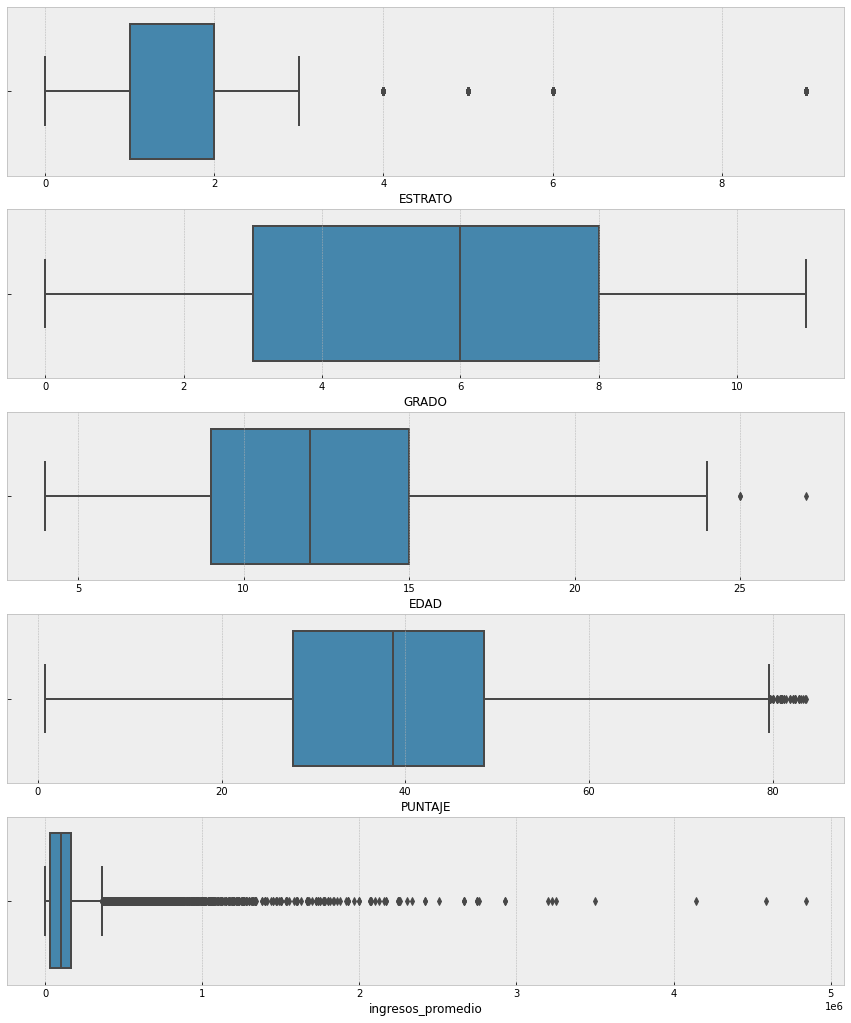

In [50]:
fig, axs = plt.subplots(5,1,figsize=(15,18))

sns.boxplot(ax=axs[0], x=df_simat.ESTRATO)
sns.boxplot(ax=axs[1], x=df_simat.GRADO)
sns.boxplot(ax=axs[2], x=df_simat.EDAD)
sns.boxplot(ax=axs[3], x=df_simat.PUNTAJE)
sns.boxplot(ax=axs[4], x=df_simat.ingresos_promedio)

In [51]:
df_simat.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.975])

ESTRATO          GRADO  ESTADO_DEFINITIVO           EDAD  \
count  185894.000000  185894.000000      185894.000000  185894.000000   
mean        1.892116       5.508462           1.026456      11.712578   
std         0.862202       3.203228           0.160487       3.527554   
min         0.000000       0.000000           1.000000       4.000000   
1%          1.000000       0.000000           1.000000       5.000000   
10%         1.000000       1.000000           1.000000       7.000000   
20%         1.000000       2.000000           1.000000       8.000000   
30%         1.000000       4.000000           1.000000      10.000000   
40%         2.000000       5.000000           1.000000      11.000000   
50%         2.000000       6.000000           1.000000      12.000000   
60%         2.000000       7.000000           1.000000      13.000000   
70%         2.000000       7.000000           1.000000      14.000000   
80%         2.000000       9.000000           1.000000      15.000000   
90%         3.000000      10.000000           1.000000      16.000000   
97.5%       3.000000      11.000000           2.000000      18.000000   
max         9.000000      11.000000           2.000000      27.000000   

             PUNTAJE  ingresos_promedio  
count  185894.000000       1.858940e+05  
mean       38.153345       1.179022e+05  
std        14.227256       1.245006e+05  
min         0.810000       0.000000e+00  
1%          7.799300       0.000000e+00  
10%        18.660000       0.000000e+00  
20%        25.110000       1.583300e+04  
30%        30.190000       5.000000e+04  
40%        34.560000       7.500000e+04  
50%        38.670000       9.938000e+04  
60%        42.640000       1.240000e+05  
70%        46.550000       1.473750e+05  
80%        50.830000       1.842250e+05  
90%        56.320000       2.500000e+05  
97.5%      64.660000       4.056012e+05  
max        83.650000       4.844000e+06

Se toma la decisión de realizar una imputación a los valores atípicos de las variables **'ingresos_promedio'**, **'PUNTAJE'** y **'EDAD'**, asignándole un valor por defecto. Este valor se toma basado en la construcción del boxplot, en donde determina que un dato se considera outlier en el límite superior si se cumple que:

$$ Lim_Sup = Cuartil_3 + 1.5 * IQR $$ 

Sin embargo, para la variable puntual de **'ingresos_promedio'**, se le imputa el doble al rango intercuartílico **(3*IQR)**, para no extraer información que podría ser importante analizar por el apilamiento de estos datos.

In [52]:
#Tratamiento variable 'ingresos_promedio'
perc1 = np.percentile(df_simat['ingresos_promedio'], 75)  + 3*(np.percentile(df_simat['ingresos_promedio'], 75) 
                                                               - np.percentile(df_simat['ingresos_promedio'], 25))
df_simat.loc[df_simat['ingresos_promedio'] > perc1, 'ingresos_promedio'] = perc1

#Tratamiento variable 'EDAD'
perc2 = np.percentile(df_simat['EDAD'], 75)  + 1.5*(np.percentile(df_simat['EDAD'], 75) - np.percentile(df_simat['EDAD'], 25))
df_simat.loc[df_simat['EDAD'] > perc2, 'EDAD'] = perc2

#Tratamiento variable 'PUNTAJE'
perc3 = np.percentile(df_simat['PUNTAJE'], 75)  + 1.5*(np.percentile(df_simat['PUNTAJE'], 75) 
                                                       - np.percentile(df_simat['PUNTAJE'], 25))
df_simat.loc[df_simat['PUNTAJE'] > perc3, 'PUNTAJE'] = perc3

### Definición de variable objetivo

La variable a predecir en la cual se tiene como propósito clasificar a aquellos posibles estudiantes desertores y no desertores, se encuentra implícita en la variable **'ESTADO_DEFINITIVO'** del dataset **df_simat** en la cual, los registros iguales a 1 corresponden a los no desertores y los registros iguales a 2 corresponden a los desertores a final de año.

Por lo anterior, se procede a crear una nueva columna llamada **'DESERTOR'** en el dataset a partir de la columna 'ESTADO_DEFINITIVO'.

In [53]:
df_simat['DESERTOR'] = (df_simat['ESTADO_DEFINITIVO']==2).astype(int)
df_simat.head(2)

ESTRATO GENERO PROVIENE_SECTOR_PRIV PROVIENE_OTRO_MUN TIPO_JORNADA  \
222         1      M                    N                 N          2.0   
1982        2      M                    N                 N          6.0   

     CARACTER  GRADO SUBSIDIADO REPITENTE NUEVO  ... extranjero telefono  \
222       0.0      4          S         N     N  ...          2        1   
1982      2.0     10          N         N     N  ...          2        0   

     computador embaraza percibe ingresos_promedio POB_VICT_CONF_IMP  \
222           2        2       2               0.0                 0   
1982          2        2       2          416666.0                 0   

      TIPO_DISCAPACIDAD_IMP EXTRAEDAD  DESERTOR  
222                       0         0         0  
1982                      0         0         0  

[2 rows x 31 columns]

Dado a que se hace un procesamiento con la columna 'ESTADO_DEFINITIVO' como variable a predecir, se procede a eliminarla del dataset.

In [54]:
df_simat.drop(columns=['ESTADO_DEFINITIVO'], inplace=True)

Se realiza una visualización de la estructura de la variable a predecir, en la cual se identifica el desbalanceo de los datos en el proceso de clasificación binaria.

In [55]:
df_simat['DESERTOR'].value_counts()

0    180976
1      4918
Name: DESERTOR, dtype: int64

In [56]:
print(f'El porcentaje correspondiente a los desertores es de {(df_simat[df_simat["DESERTOR"] == 1]).shape[0]} lo cual corresponde al {(((df_simat[df_simat["DESERTOR"] == 1]).shape[0])/(df_simat.shape[0]))*100}% de los datos.')

El porcentaje correspondiente a los desertores es de 4918 lo cual corresponde al 2.6455937254564432% de los datos.


Se puede observar que la variable a predecir tiene un gran desbalanceo.

## Visualización del comportamiento de las variables tratadas

Se realiza una representación gráfica de los datos para tener una contexto de su comportamiento frente a la variable a predecir.

Inicialmente se obtiene la correlación lineal entre las variables numéricas con la variable a predecir.

In [57]:
df_simat.corr()

ESTRATO     GRADO      EDAD   PUNTAJE  ingresos_promedio  \
ESTRATO            1.000000  0.009028 -0.014413  0.233543           0.131355   
GRADO              0.009028  1.000000  0.961004  0.129205           0.011742   
EDAD              -0.014413  0.961004  1.000000  0.086182          -0.013697   
PUNTAJE            0.233543  0.129205  0.086182  1.000000           0.361148   
ingresos_promedio  0.131355  0.011742 -0.013697  0.361148           1.000000   
DESERTOR          -0.028319  0.014173  0.051215 -0.044992          -0.029565   

                   DESERTOR  
ESTRATO           -0.028319  
GRADO              0.014173  
EDAD               0.051215  
PUNTAJE           -0.044992  
ingresos_promedio -0.029565  
DESERTOR           1.000000

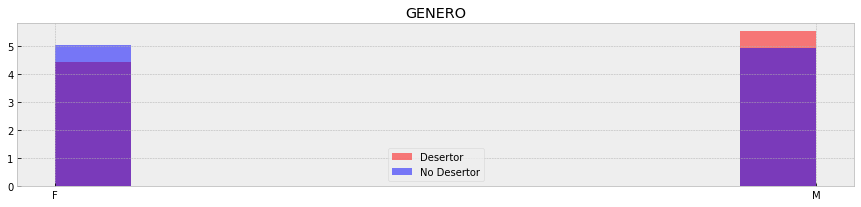

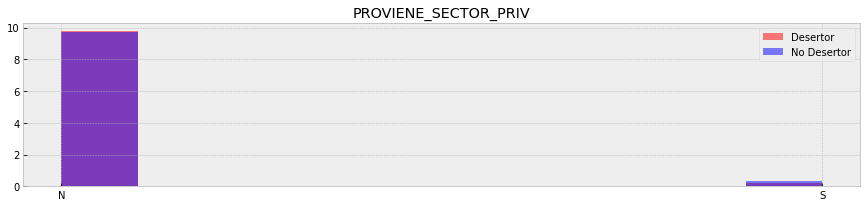

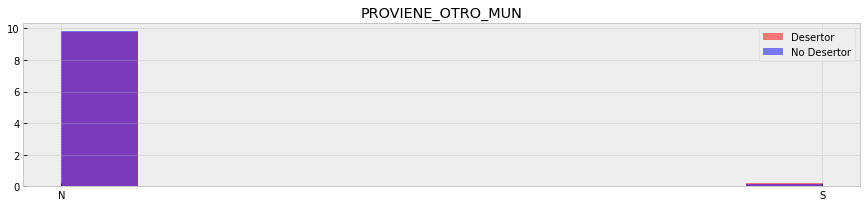

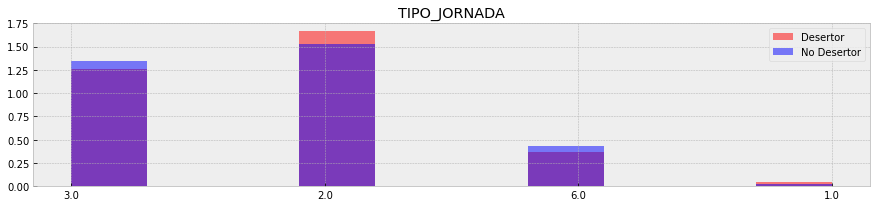

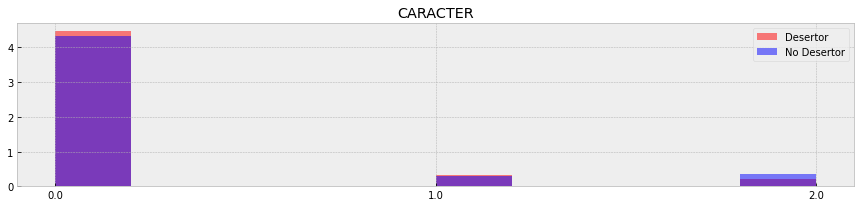

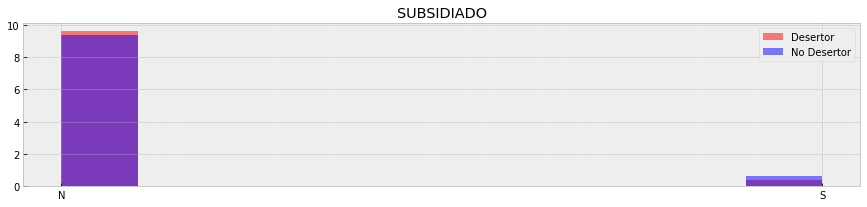

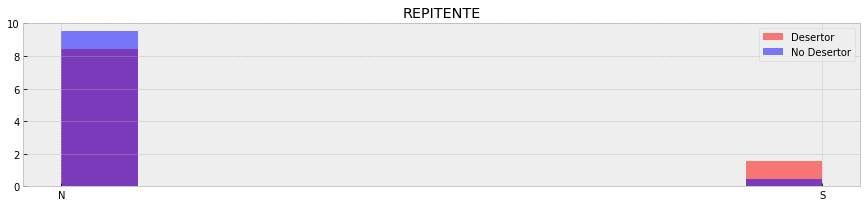

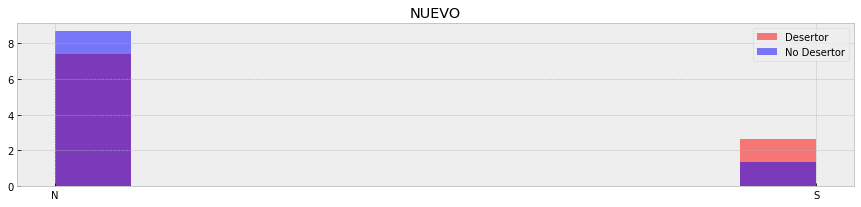

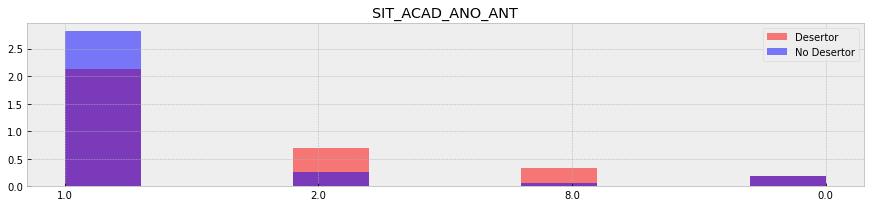

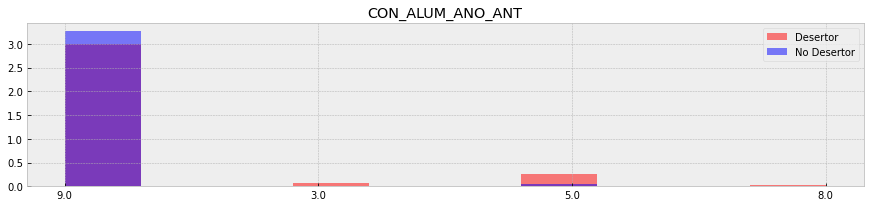

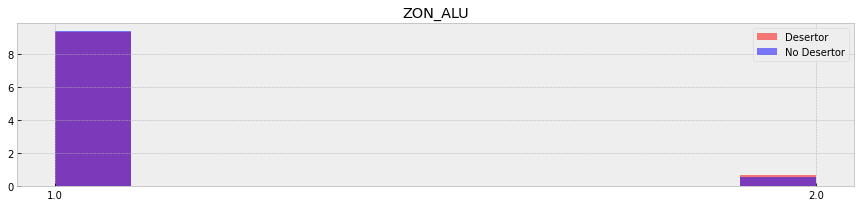

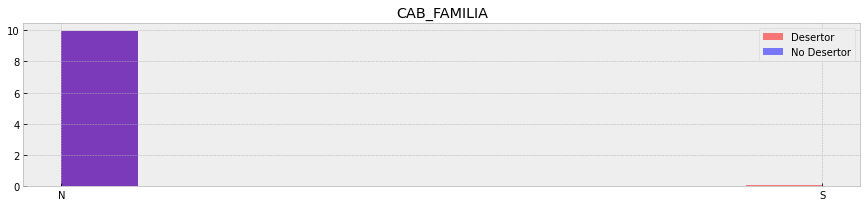

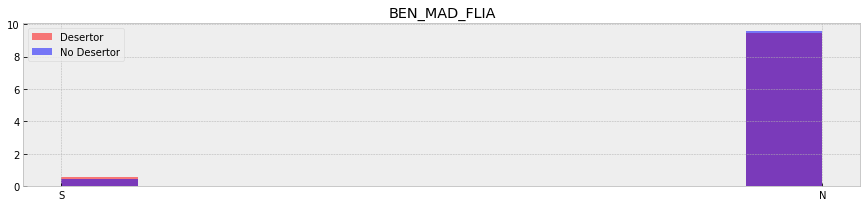

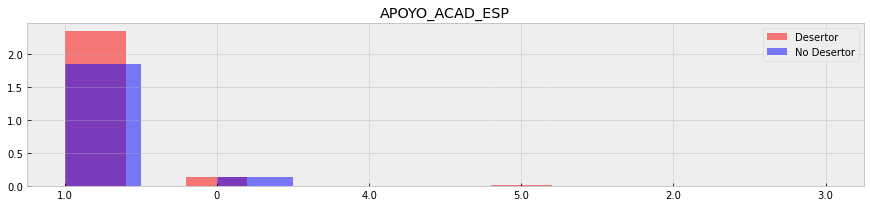

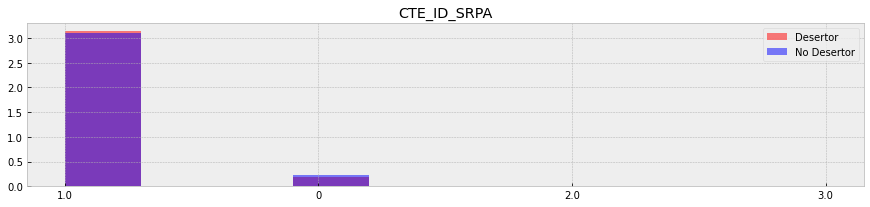

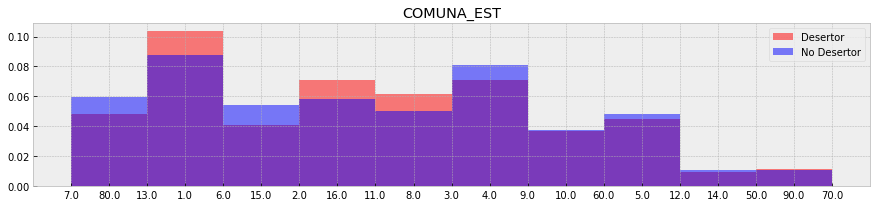

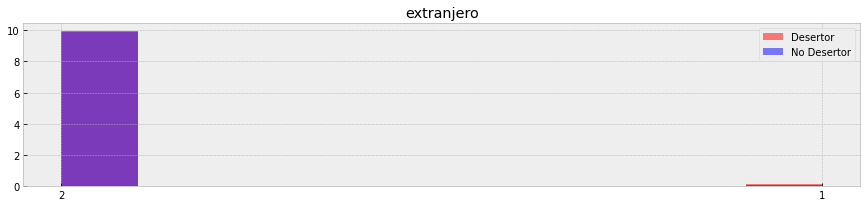

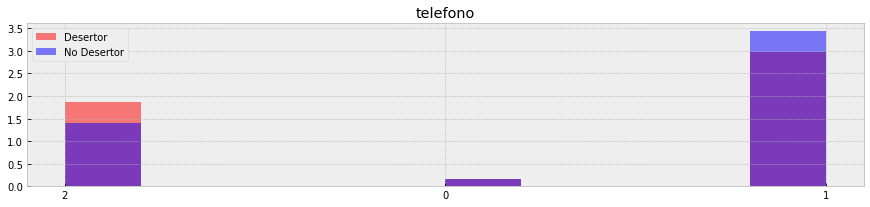

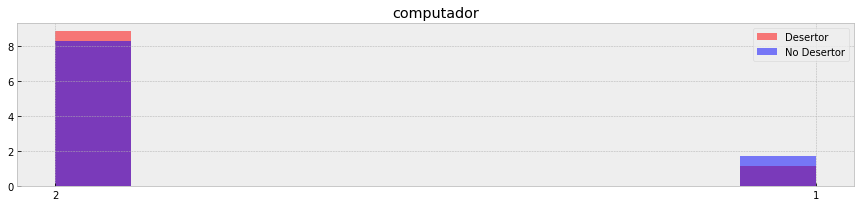

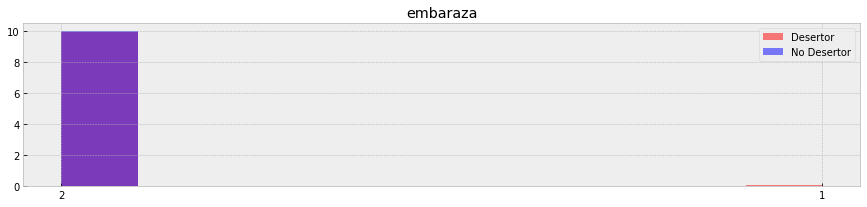

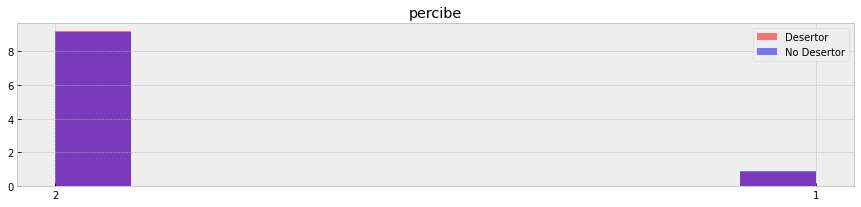

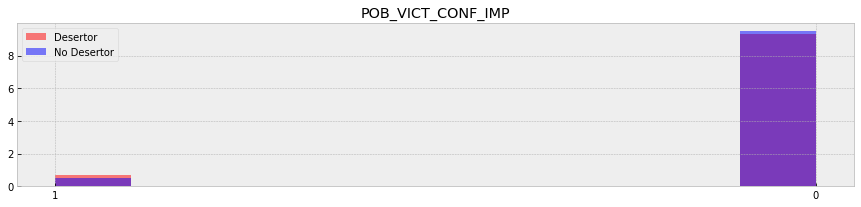

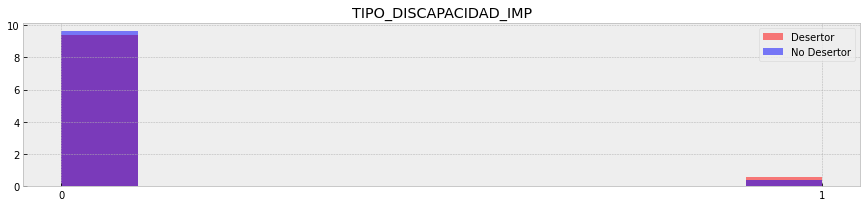

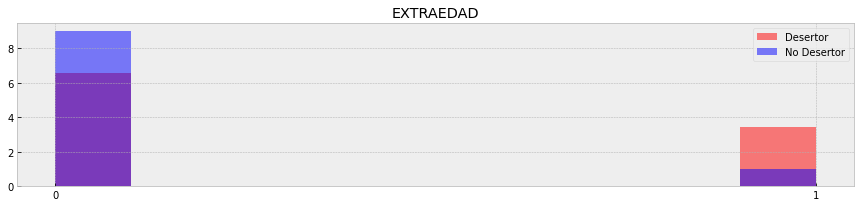

In [59]:
def make_hist(x_1,x_0,title):
  plt.figure(figsize=(15,3))
  plt.hist(x_1, color='r', label='Desertor', alpha=0.5, density=True)
  plt.hist(x_0, color='b', label='No Desertor', alpha=0.5, density=True)
  plt.title(title)
  plt.legend()
  plt.show()

cols_plt = [i for i in df_simat.columns if not i in df_simat._get_numeric_data()]

for i in cols_plt:
  x_0 = df_simat[df_simat['DESERTOR']==0][i]
  x_1 = df_simat[df_simat['DESERTOR']!=0][i]
  make_hist(x_1,x_0,i)

Visualización gráfica del comportamiento de las variables numéricas.

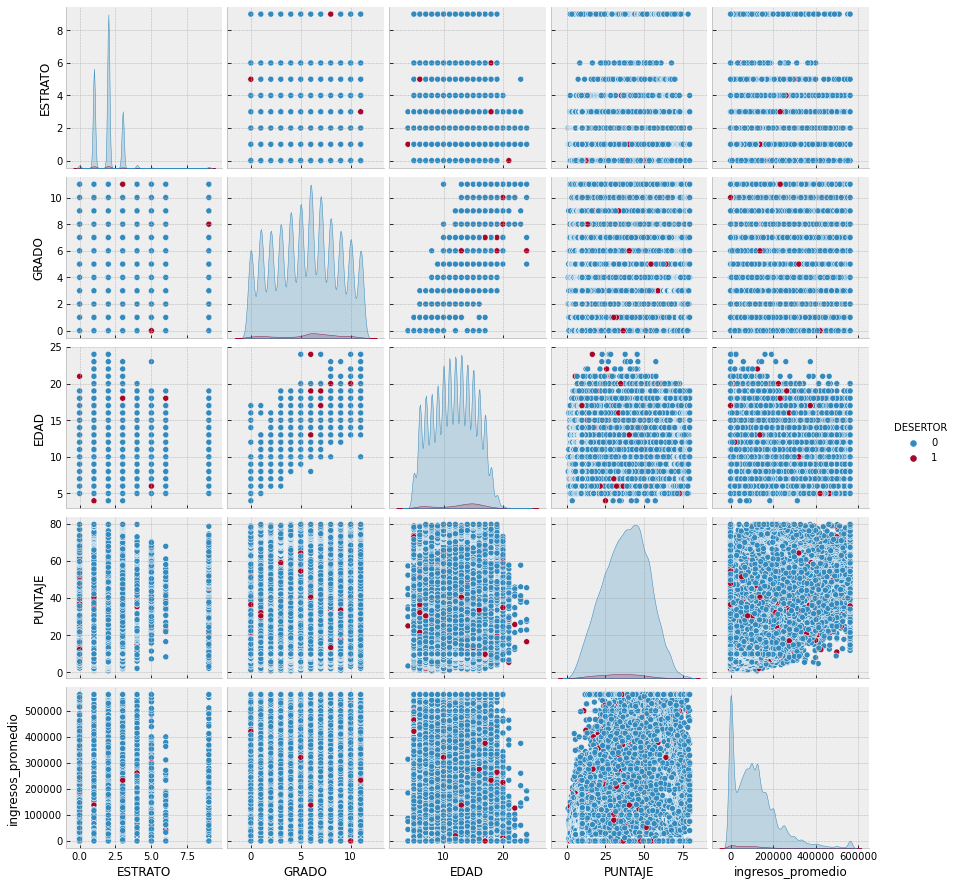

In [60]:
cols_numericas = [i for i in df_simat.columns if i in df_simat._get_numeric_data()]
grafica_num = sns.pairplot(df_simat[cols_numericas], hue='DESERTOR')
grafica_num.savefig("grafica_variables_num.jpg")

Se visualiza el comportamiento completo de todas las variables haciendo uso de SweetVIZ.

In [56]:
my_report_2 = sv.analyze(df_simat.iloc[:,1:])
my_report_2.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



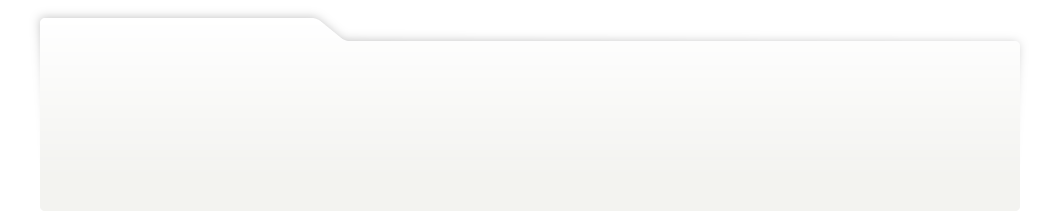
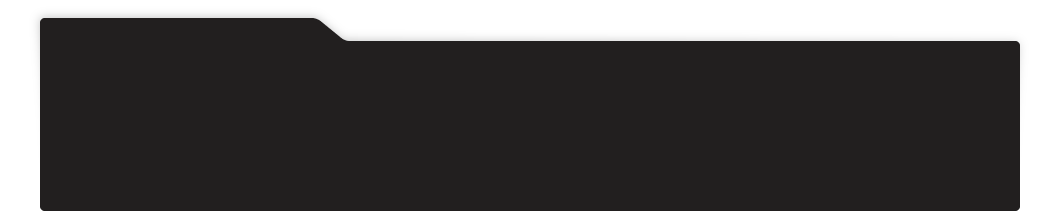
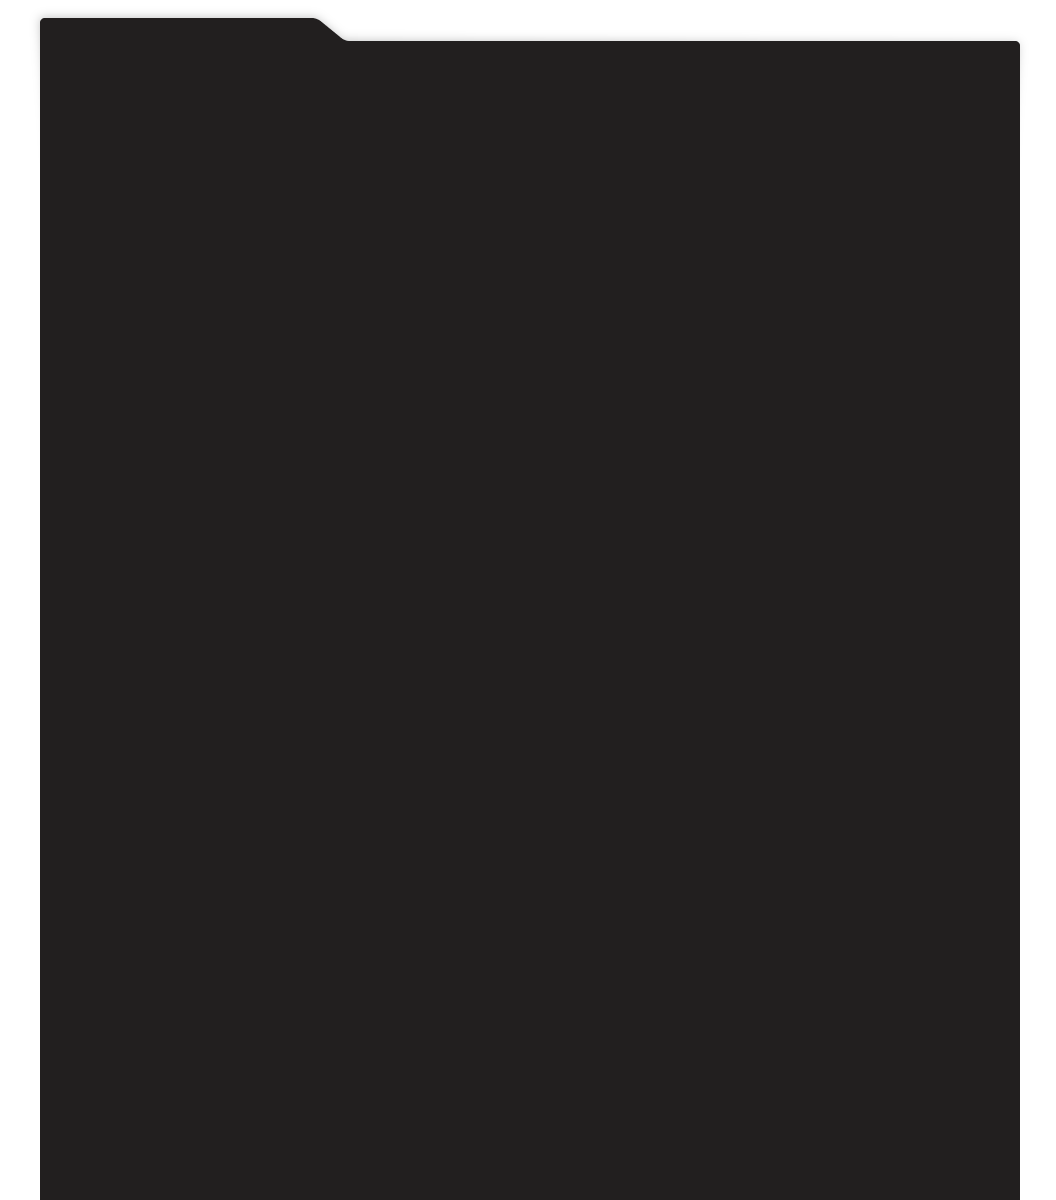
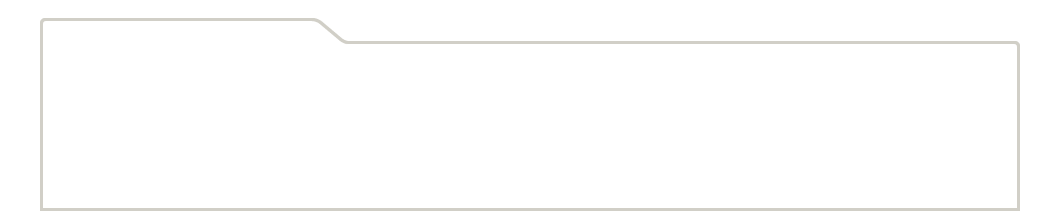
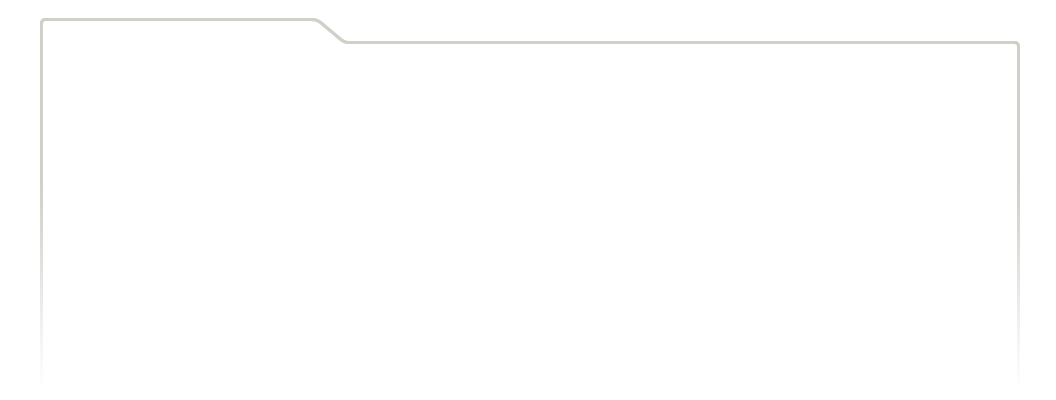
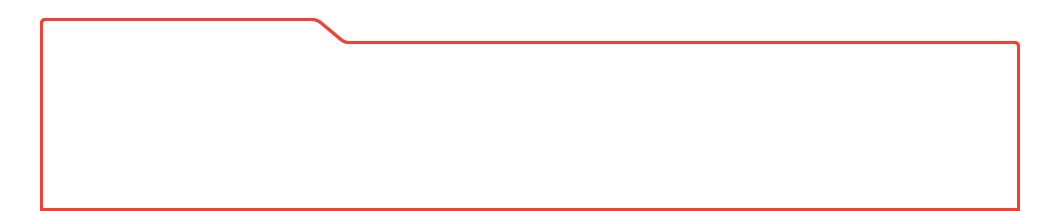
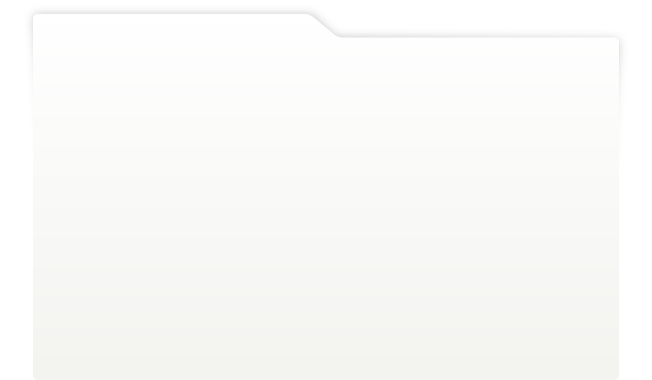
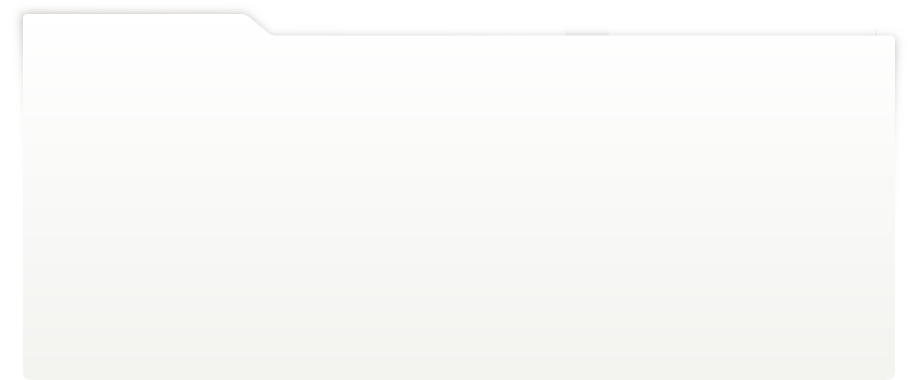
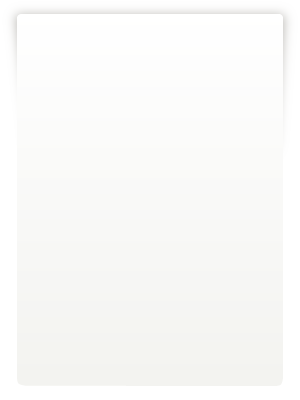
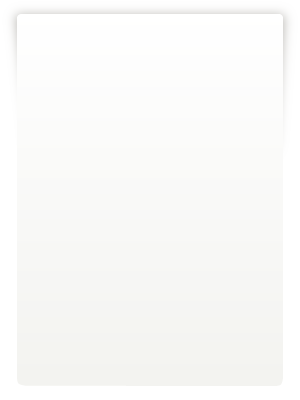
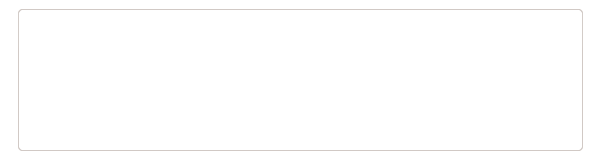
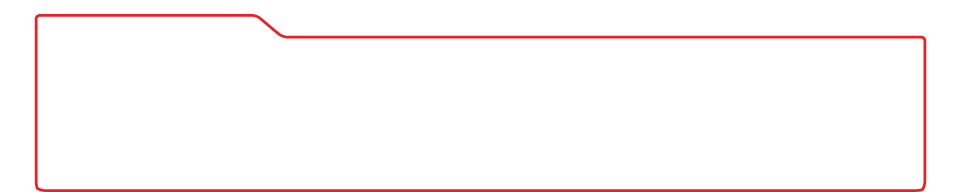
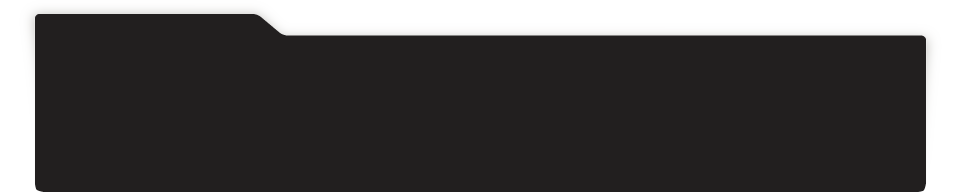
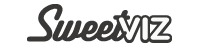
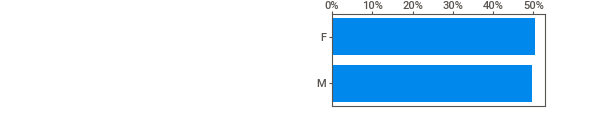
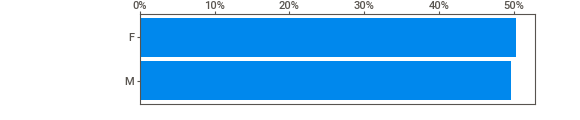
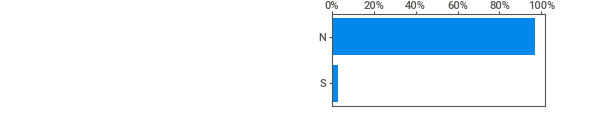
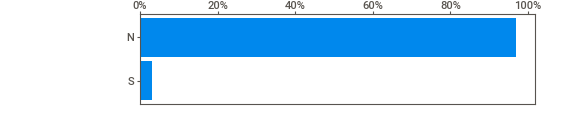
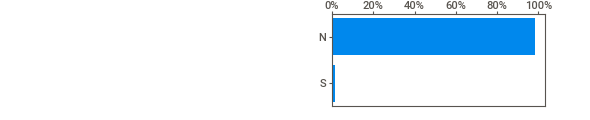
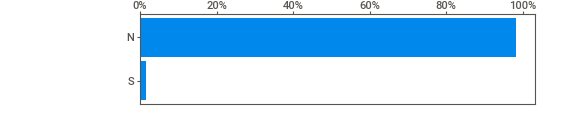
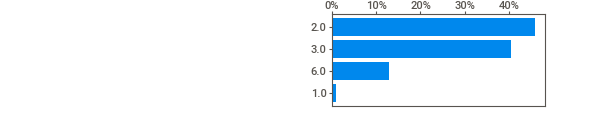
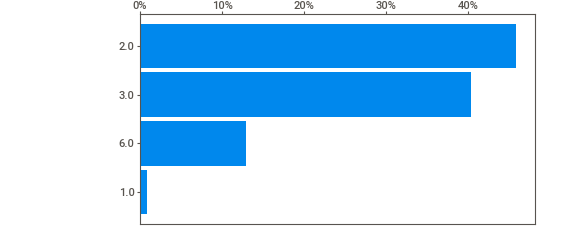
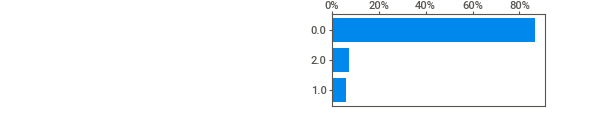
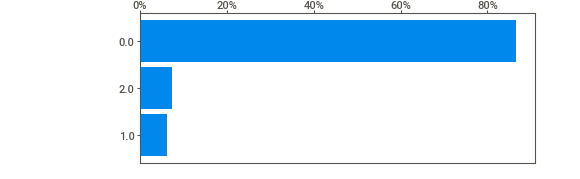
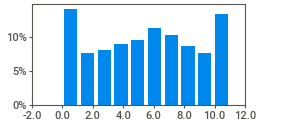
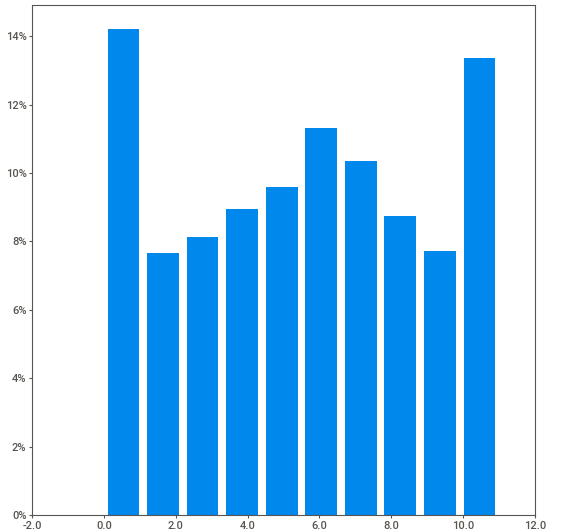
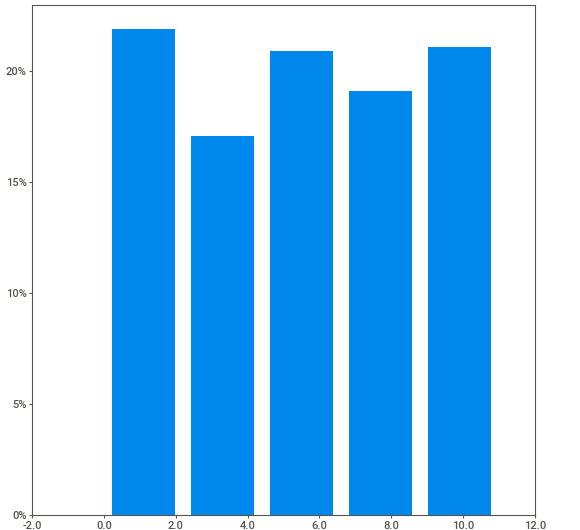
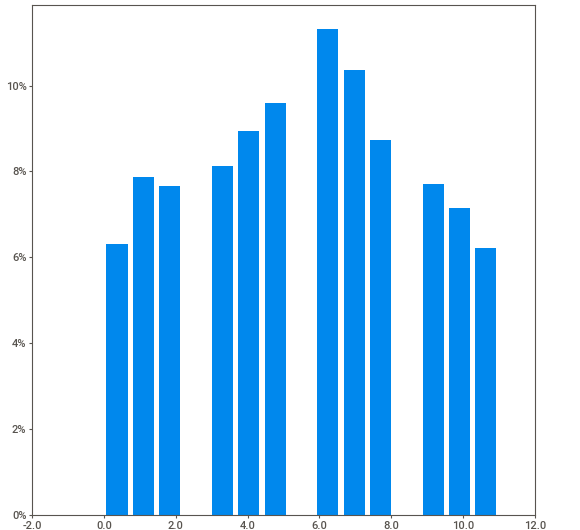
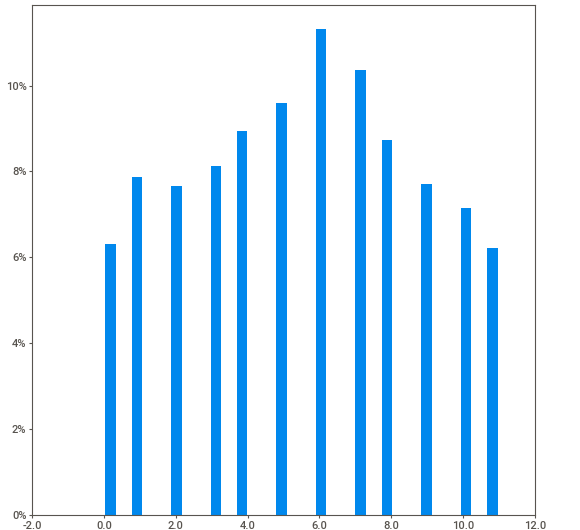
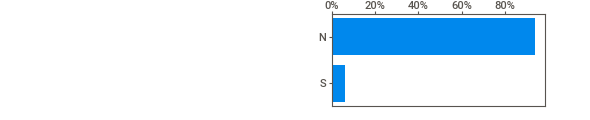
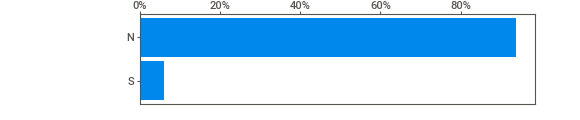
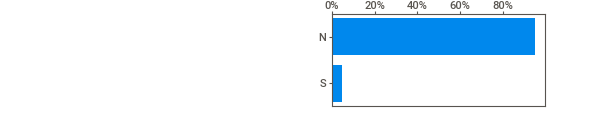
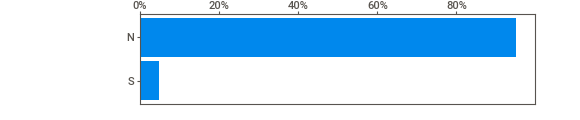
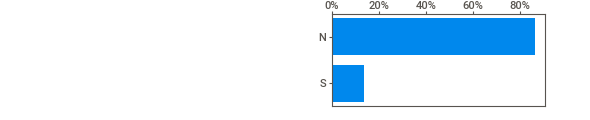
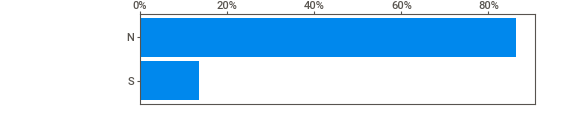
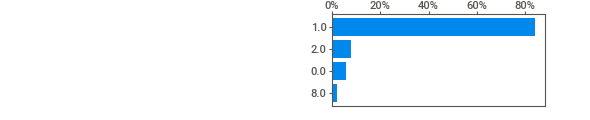
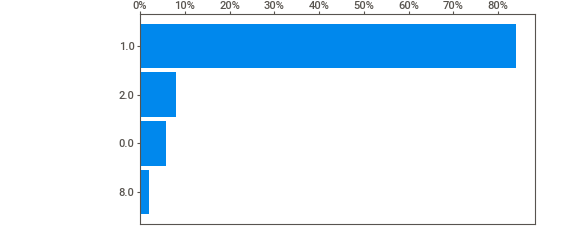
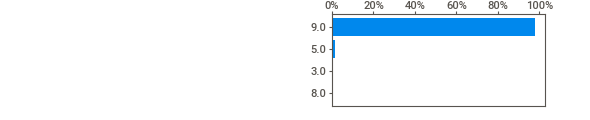
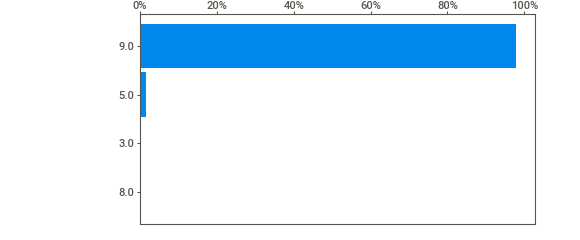
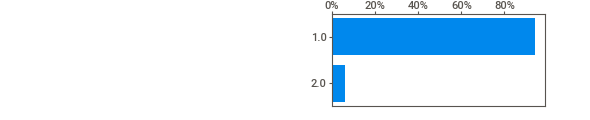
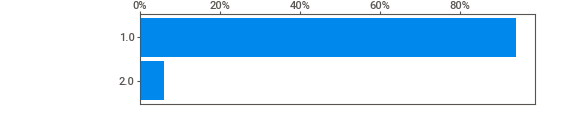
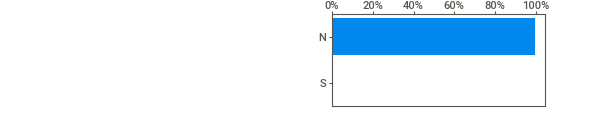
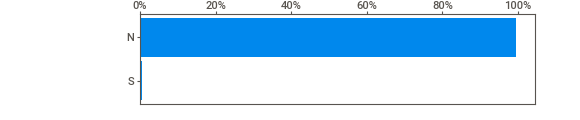
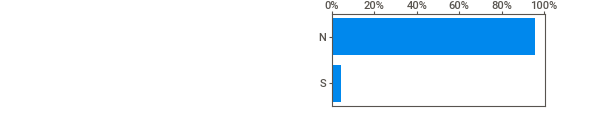
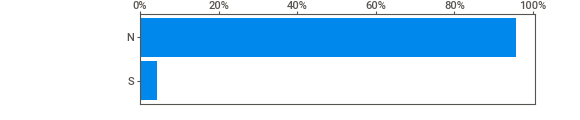
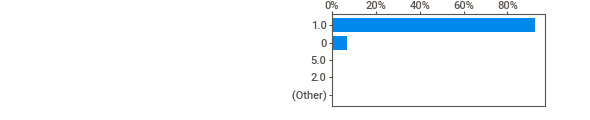
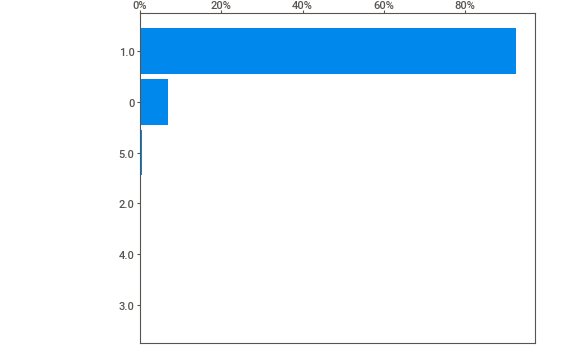
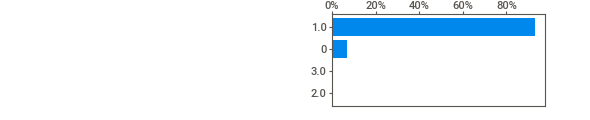
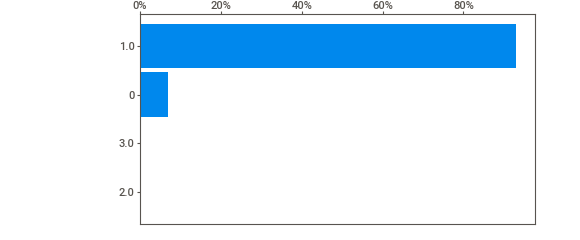
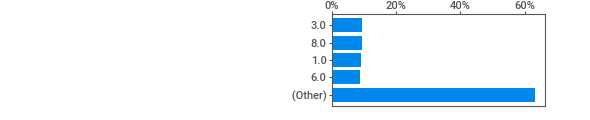
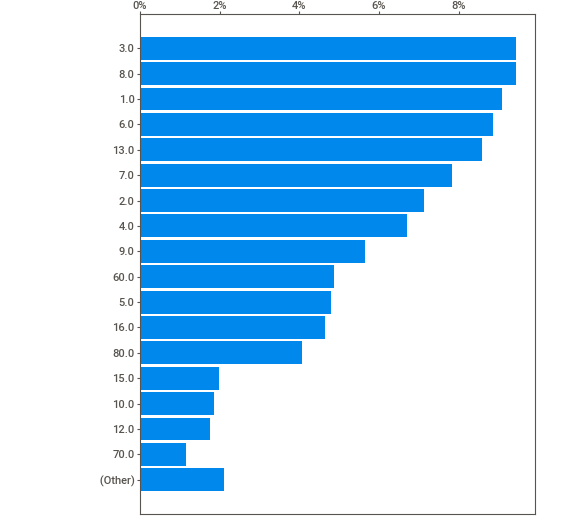
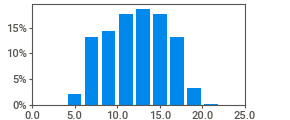
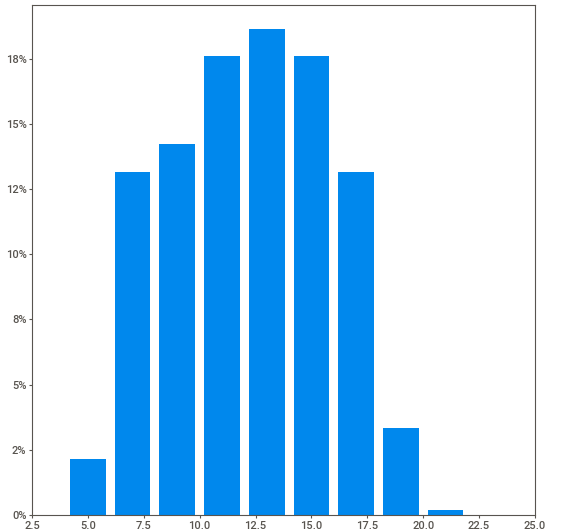
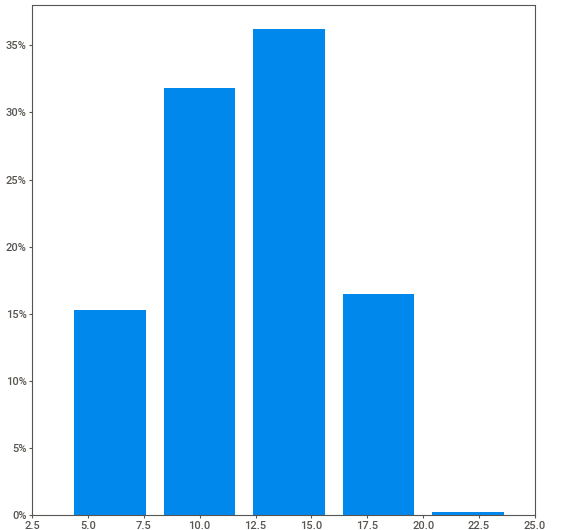
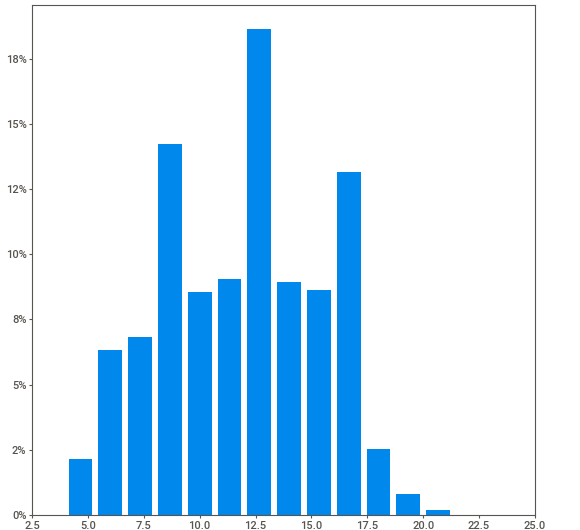
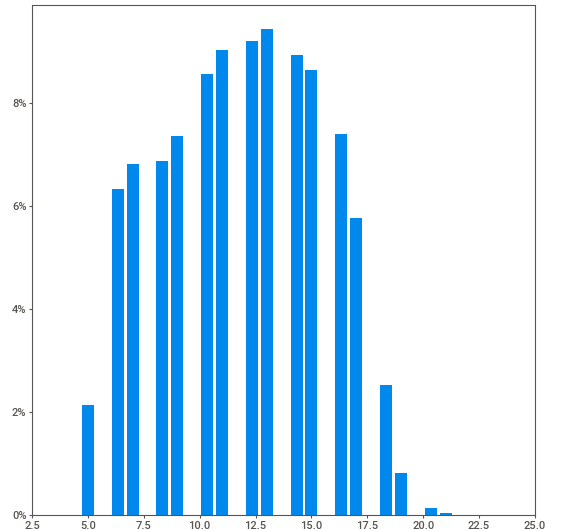
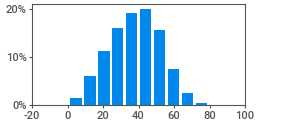
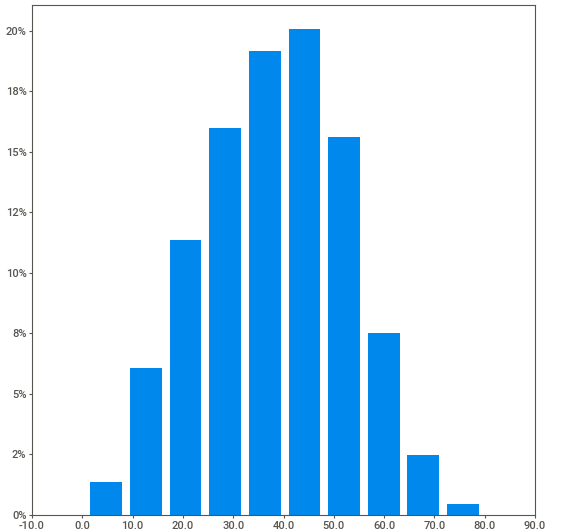
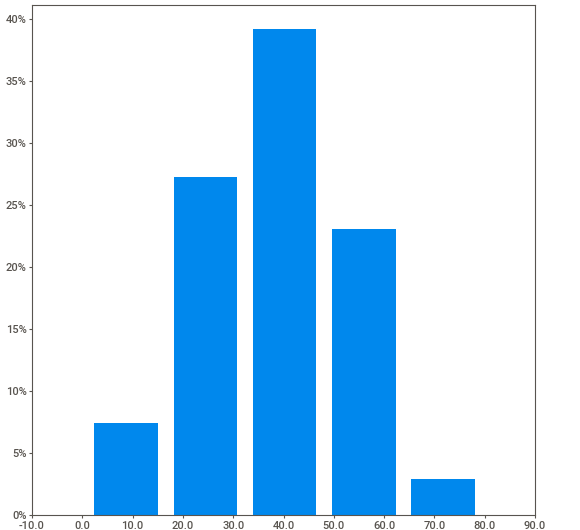
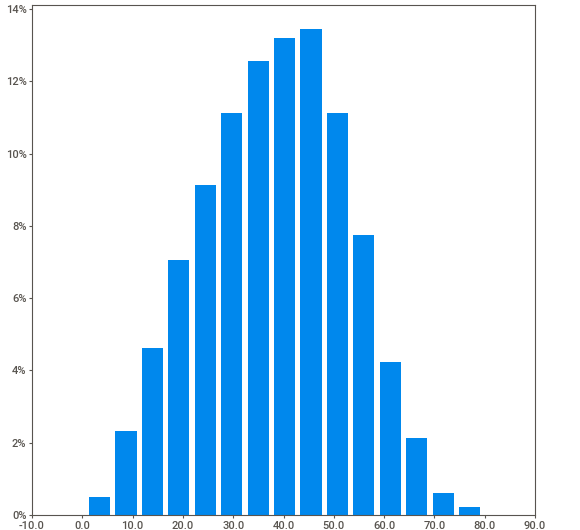
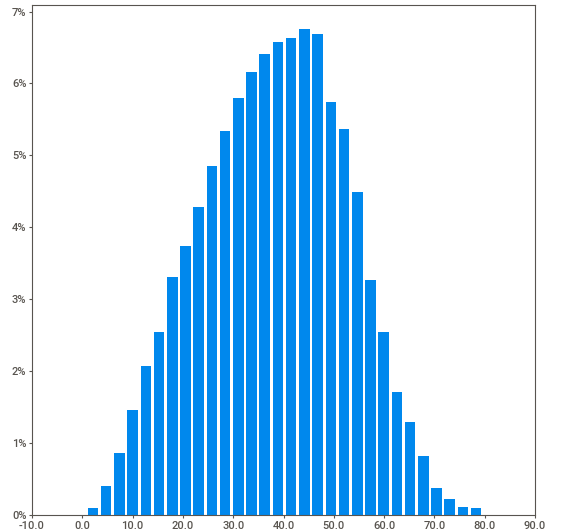
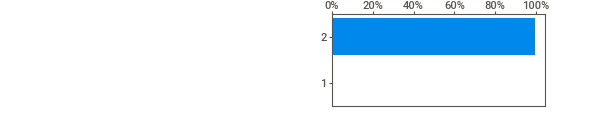
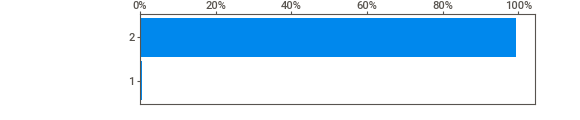
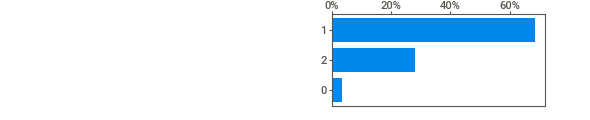
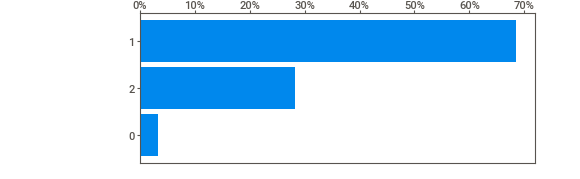
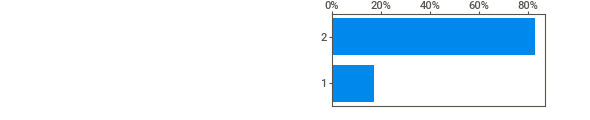
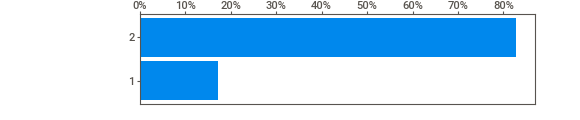
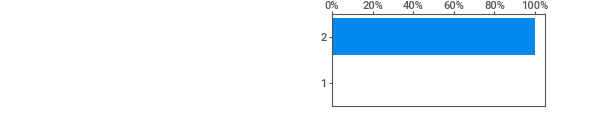
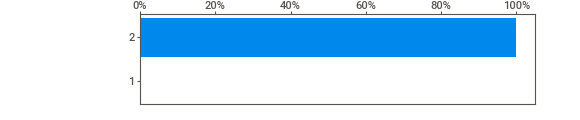
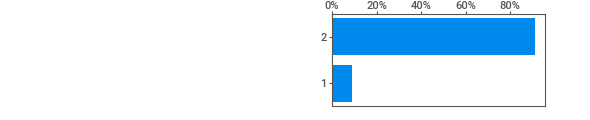
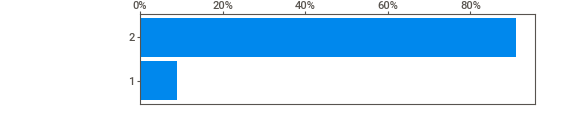
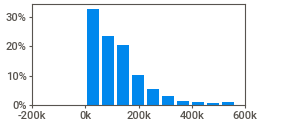
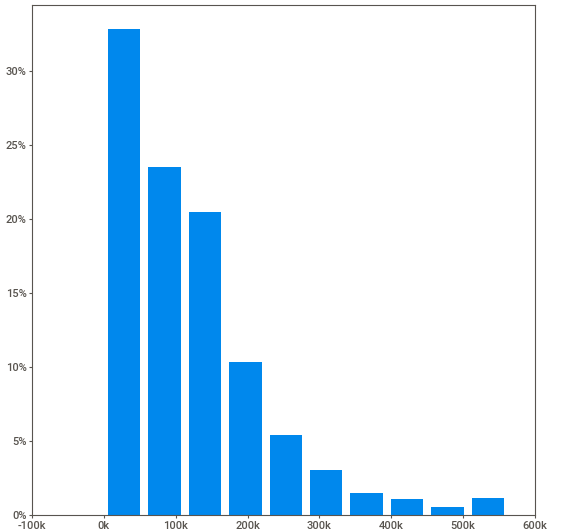
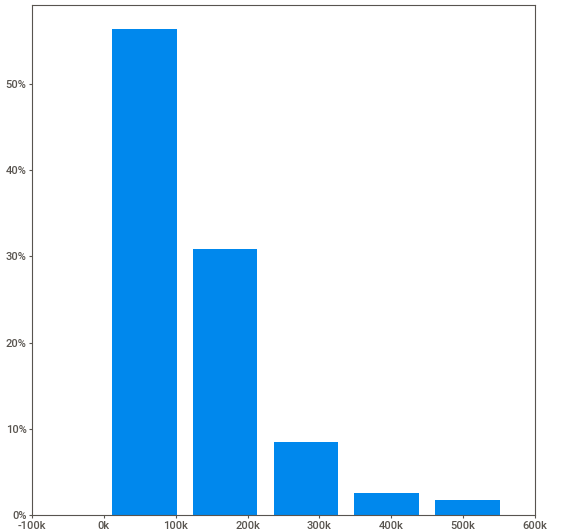
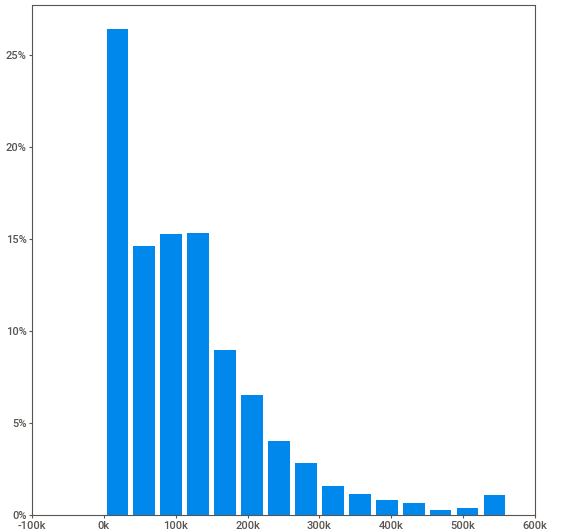
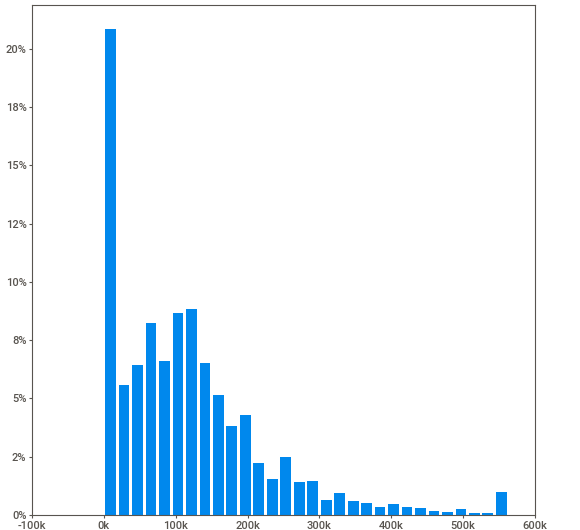
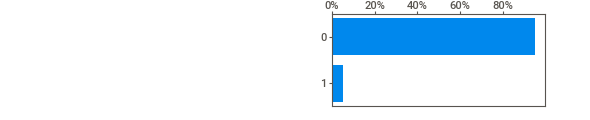
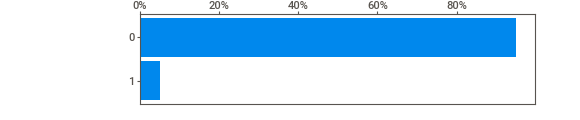
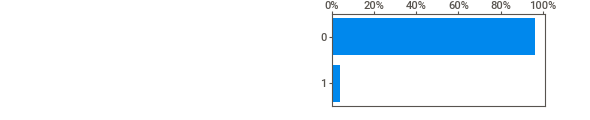
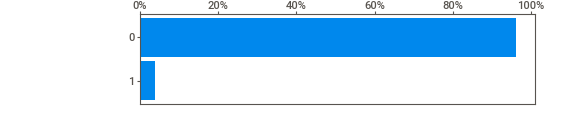
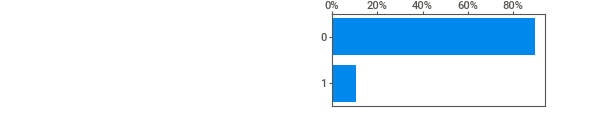
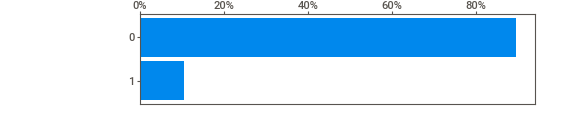
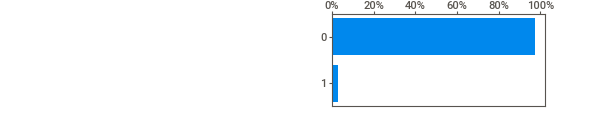
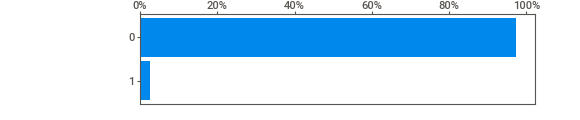
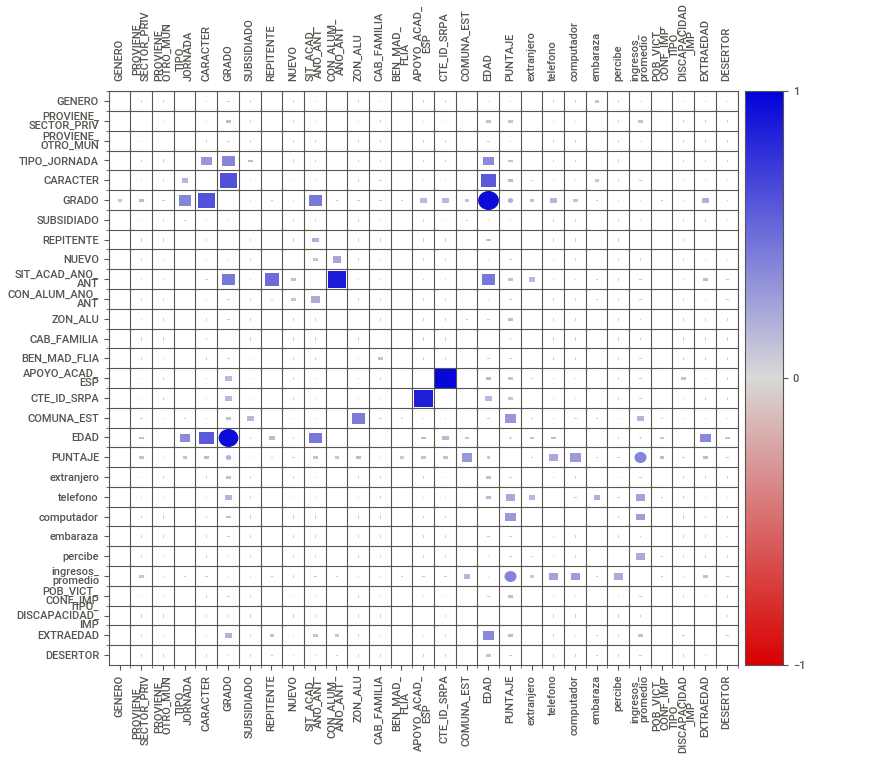
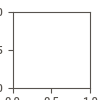

In [57]:
my_report_2.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='vertical')

## Métricas de desempeño

La métrica principal implementada para medir el desempeño del modelo es la **matriz de confusión** la cual permite evaluar la precisión de la predicción en el proceso de clasificación binaria, arrojando información relevante como verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

Función para obtener las métricas del modelo tales como; Accuracy, Balanced Accuracy, Recall, F1 y Confusion matrix.

In [58]:
def model_metrics(model, X_test, y_test):
 
  y_test_pred = model.predict(X_test)
  print(f"Accuracy = {accuracy_score(y_test,y_test_pred)}")
  print(f"Recall = {recall_score(y_test,y_test_pred)}")

  #Las métricas F1, precision and recall requieren que se establezca la convención de cuál es la clase positiva (1)
  print(f"F1 score = {f1_score(y_test,y_test_pred)}")
  
  disp = plot_confusion_matrix(model, X_test, y_test, display_labels=model.classes_,
                              cmap=plt.cm.Blues, 
                              normalize='true')
  disp.ax_.set_title('Matriz de confusión')
  plt.show()

In [59]:
def confusion_matrix_labels(model, X_test, y_test):
    '''
    Esta función permite graficar la matriz de confusión con los labels en valor predicho correspondientes a: 
    - Verdareros positivos
    - Falsos positivos
    - Verdaderos negativos
    - Falsos negativos
    '''
    predicciones = model.predict(X_test)

    df_predicciones = pd.DataFrame({"True": y_test, "Pred": predicciones})
    df_predicciones.head()

    cf_matrix = confusion_matrix(y_test, predicciones)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

Función para obtener la métrica de validación cruzada del modelo

In [60]:
def cross_val(model, X, y):
 
  kf = KFold(n_splits=10)
  scores = cross_val_score(model, X, y, cv=kf, scoring="f1")
  print(f"Metricas cross_validation \n{scores.round(2)}")
  print("Media de cross_validation", scores.mean().round(2))

Función para obtener la métrica del AUC; área bajo la curva ROC

In [61]:
def roc_auc_metrics(model, name_model, X_test, y_test):

    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)[:, 1]
    # Calculamos el AUC
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # Imprimimos en pantalla
    print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
    print(name_model,'ROC AUC=%.3f' % (lr_auc))
    # Calculamos las curvas ROC
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # Pintamos las curvas ROC
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name_model)
    # Etiquetas de los ejes
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    plt.show()

## Codificación variables categóricas

Debido al desbalanceo de la variable a predecir, se procede a utilizar una técnica de sobremuestreo "SMOTE" para poder balancear las clases y realizar el modelo.

Para iniciar el proceso de predicción, se realiza la separación de las variables del Dataset en **X** (Características) y **y** (Predicción).

In [62]:
X = df_simat.drop(columns=['DESERTOR'])
y = df_simat["DESERTOR"]
print (X.shape, y.shape)

(185894, 29) (185894,)


In [63]:
columns_str_dummies = ['GENERO', 'POB_VICT_CONF_IMP','TIPO_DISCAPACIDAD_IMP', 'TIPO_JORNADA', 
                       'PROVIENE_SECTOR_PRIV', 'CARACTER', 'SUBSIDIADO', 'PROVIENE_OTRO_MUN',
                       'REPITENTE', 'NUEVO', 'SIT_ACAD_ANO_ANT', 'CON_ALUM_ANO_ANT',
                       'ZON_ALU', 'CAB_FAMILIA', 'BEN_MAD_FLIA','APOYO_ACAD_ESP', 
                       'CTE_ID_SRPA', 'COMUNA_EST', 'extranjero', 'telefono', 'computador', 
                       'embaraza', 'percibe', 'EXTRAEDAD']
X = pd.get_dummies(X, columns = columns_str_dummies)

In [66]:
X.columns

Index(['ESTRATO', 'GRADO', 'EDAD', 'PUNTAJE', 'ingresos_promedio', 'GENERO_F',
       'GENERO_M', 'POB_VICT_CONF_IMP_0', 'POB_VICT_CONF_IMP_1',
       'TIPO_DISCAPACIDAD_IMP_0', 'TIPO_DISCAPACIDAD_IMP_1',
       'TIPO_JORNADA_1.0', 'TIPO_JORNADA_2.0', 'TIPO_JORNADA_3.0',
       'TIPO_JORNADA_6.0', 'PROVIENE_SECTOR_PRIV_N', 'PROVIENE_SECTOR_PRIV_S',
       'CARACTER_0.0', 'CARACTER_1.0', 'CARACTER_2.0', 'SUBSIDIADO_N',
       'SUBSIDIADO_S', 'PROVIENE_OTRO_MUN_N', 'PROVIENE_OTRO_MUN_S',
       'REPITENTE_N', 'REPITENTE_S', 'NUEVO_N', 'NUEVO_S',
       'SIT_ACAD_ANO_ANT_0.0', 'SIT_ACAD_ANO_ANT_1.0', 'SIT_ACAD_ANO_ANT_2.0',
       'SIT_ACAD_ANO_ANT_8.0', 'CON_ALUM_ANO_ANT_3.0', 'CON_ALUM_ANO_ANT_5.0',
       'CON_ALUM_ANO_ANT_8.0', 'CON_ALUM_ANO_ANT_9.0', 'ZON_ALU_1.0',
       'ZON_ALU_2.0', 'CAB_FAMILIA_N', 'CAB_FAMILIA_S', 'BEN_MAD_FLIA_N',
       'BEN_MAD_FLIA_S', 'APOYO_ACAD_ESP_0', 'APOYO_ACAD_ESP_1.0',
       'APOYO_ACAD_ESP_2.0', 'APOYO_ACAD_ESP_3.0', 'APOYO_ACAD_ESP_4.0',
       '

In [61]:
X.shape

(185894, 86)

### Balanceo de la variable objetivo

In [61]:
! pip install imbalanced-learn

In [62]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

#### Técnica SMOTE

Se aplica la técnica **SMOTE** para la realización de sobremuestreo debido al desbalanceo de los datos.

In [63]:
sm = SMOTE(random_state=20)
X_res, y_res = sm.fit_resample(X,y)

In [64]:
print('Forma del dataset sobremuestreado: %s' % Counter(y_res))

Forma del dataset sobremuestreado: Counter({0: 180976, 1: 180976})


In [65]:
val_correlacion = pd.concat([X_res, y_res], axis=1)
val_correlacion.corr()

ESTRATO     GRADO      EDAD   PUNTAJE  ingresos_promedio  \
ESTRATO            1.000000  0.008052 -0.068460  0.258077           0.132371   
GRADO              0.008052  1.000000  0.934447  0.125980          -0.002838   
EDAD              -0.068460  0.934447  1.000000  0.047769          -0.042488   
PUNTAJE            0.258077  0.125980  0.047769  1.000000           0.360770   
ingresos_promedio  0.132371 -0.002838 -0.042488  0.360770           1.000000   
...                     ...       ...       ...       ...                ...   
percibe_1          0.006530  0.013549 -0.014289  0.050633           0.149776   
percibe_2          0.078364 -0.006113 -0.029400 -0.001211          -0.161615   
EXTRAEDAD_0        0.185017 -0.156953 -0.411225  0.142874           0.077613   
EXTRAEDAD_1       -0.071074  0.148432  0.345132 -0.099910          -0.108296   
DESERTOR          -0.272919 -0.011522  0.167953 -0.142659          -0.095752   

                   GENERO_F  GENERO_M  POB_VICT_CONF_IMP_0  \
ESTRATO            0.087036  0.046017             0.139628   
GRADO              0.035707 -0.024947            -0.027207   
EDAD              -0.045105 -0.026735            -0.062485   
PUNTAJE            0.031202  0.025613             0.092354   
ingresos_promedio  0.008135  0.005550             0.032747   
...                     ...       ...                  ...   
percibe_1          0.046520  0.024230            -0.032073   
percibe_2          0.030871  0.017299             0.094061   
EXTRAEDAD_0        0.194958  0.019895             0.098259   
EXTRAEDAD_1       -0.073178  0.053702            -0.041971   
DESERTOR          -0.295342 -0.160001            -0.124899   

                   POB_VICT_CONF_IMP_1  TIPO_DISCAPACIDAD_IMP_0  ...  \
ESTRATO                      -0.044625                 0.015840  ...   
GRADO                         0.026325                 0.006225  ...   
EDAD                          0.011274                -0.058341  ...   
PUNTAJE                      -0.038938                 0.019759  ...   
ingresos_promedio            -0.015423                -0.017202  ...   
...                                ...                      ...  ...   
percibe_1                     0.086258                 0.025746  ...   
percibe_2                    -0.039908                 0.002198  ...   
EXTRAEDAD_0                   0.037898                 0.152559  ...   
EXTRAEDAD_1                   0.017979                -0.100710  ...   
DESERTOR                     -0.127168                -0.130480  ...   

                   telefono_2  computador_1  computador_2  embaraza_1  \
ESTRATO             -0.092813      0.203949     -0.143218    0.003661   
GRADO               -0.123209      0.054356     -0.056626    0.024466   
EDAD                -0.121169     -0.012906     -0.036420    0.022874   
PUNTAJE             -0.150060      0.232060     -0.242671   -0.019960   
ingresos_promedio   -0.038911      0.229122     -0.253480    0.010352   
...                       ...           ...           ...         ...   
percibe_1            0.088621      0.070180     -0.023080    0.012621   
percibe_2           -0.035172     -0.002925      0.035894   -0.009015   
EXTRAEDAD_0          0.054475      0.141212     -0.019875   -0.000678   
EXTRAEDAD_1          0.001340     -0.054522      0.042654    0.011705   
DESERTOR            -0.119245     -0.250688     -0.027171   -0.010943   

                   embaraza_2  percibe_1  percibe_2  EXTRAEDAD_0  EXTRAEDAD_1  \
ESTRATO              0.023152   0.006530   0.078364     0.185017    -0.071074   
GRADO               -0.040682   0.013549  -0.006113    -0.156953     0.148432   
EDAD                -0.062905  -0.014289  -0.029400    -0.411225     0.345132   
PUNTAJE              0.062420   0.050633  -0.001211     0.142874    -0.099910   
ingresos_promedio   -0.019548   0.149776  -0.161615     0.077613    -0.108296   
...                       ...        ...        ...          ...          ...   
perci

### Dataset Entrenamiento y prueba

Se realiza la separación en un 70% para el dataset de entrenamiento y 30% para el dataset de prueba a partir de las clases balanceadas.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size=0.3, random_state=12)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(253366, 86) (253366,) (108586, 86) (108586,)


In [67]:
y_train.value_counts()

0    126696
1    126670
Name: DESERTOR, dtype: int64

In [68]:
y_test.value_counts()

1    54306
0    54280
Name: DESERTOR, dtype: int64

## Modelos

### Modelo Random Forest Classifier

In [70]:
model_randomforest = RandomForestClassifier(max_depth=2, random_state=0, class_weight = 'balanced')
model_randomforest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [71]:
parameteres = {'n_estimators':[40,50,80], 'max_depth':[4,5,6], 'class_weight':['None','balanced']}

grid = GridSearchCV(model_randomforest, param_grid=parameteres, cv=10)
kf_hiper = KFold(n_splits=10)
model_randomforest = grid.fit(X_train, y_train).best_estimator_

In [72]:
model_randomforest

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=50,
                       random_state=0)

Accuracy = 0.8993516659606211
Recall = 0.8608809339667808
F1 score = 0.8953471670289473


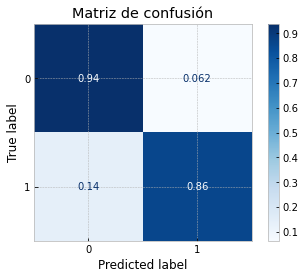

In [73]:
model_metrics(model=model_randomforest, X_test=X_test, y_test=y_test)

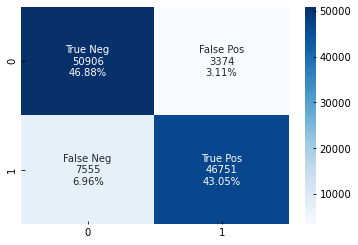

In [74]:
confusion_matrix_labels(model_randomforest, X_test, y_test)

In [75]:
cross_val(model_randomforest, X_test, y_test)

Metricas cross_validation 
[0.88 0.88 0.88 0.88 0.88 0.88 0.89 0.9  0.89 0.88]
Media de cross_validation 0.88


Sin entrenar: ROC AUC=0.500
Random Forest Classifier ROC AUC=0.966


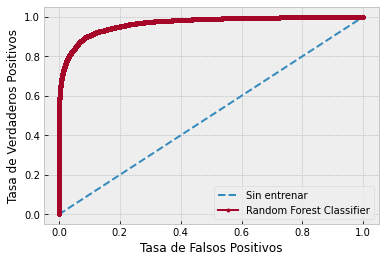

In [76]:
roc_auc_metrics(model_randomforest,"Random Forest Classifier",X_test, y_test)

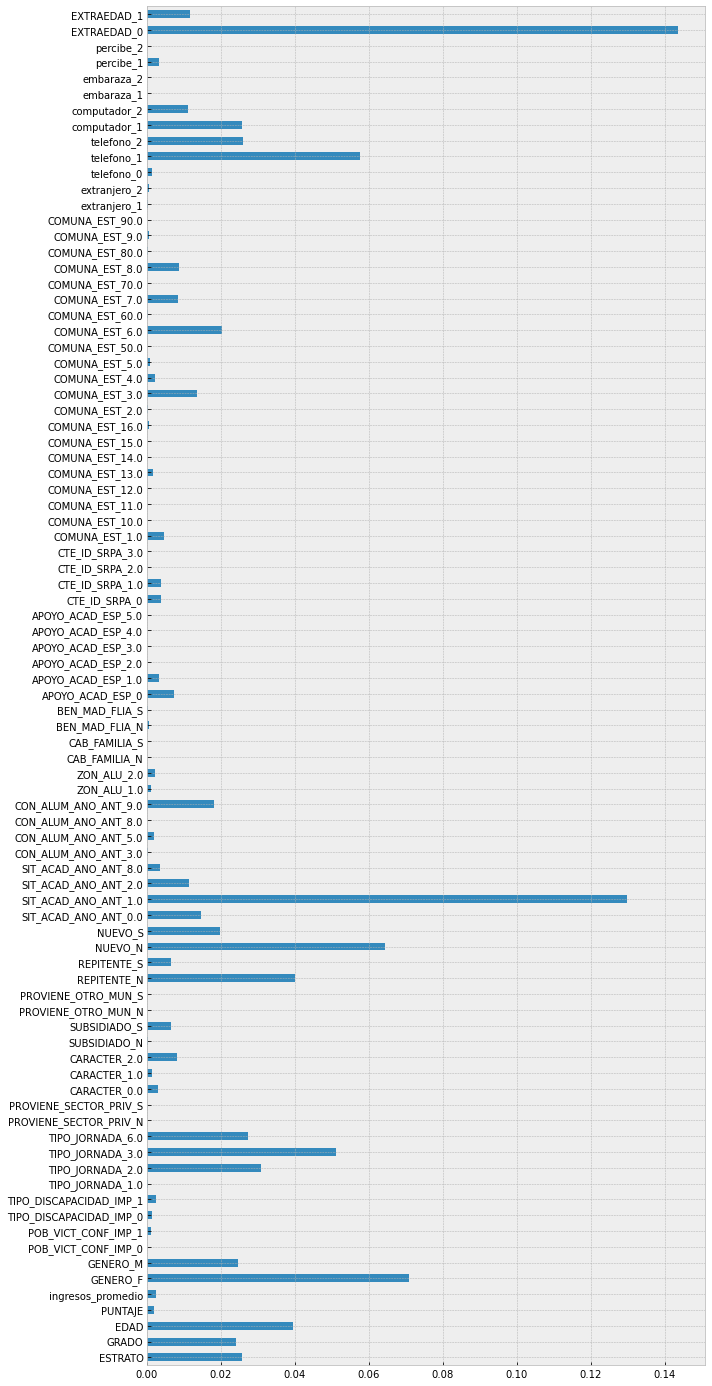

In [77]:
importances = model_randomforest.feature_importances_
features = pd.Series(importances, index=X_train.columns)
plt.figure(figsize=(10, 25))
features.plot(kind="barh")
plt.show()

### Modelo de Red Neuronal con Autoencoder

In [78]:
# Para un mejor ajuste en este modelo, se escalan los datos
t = MinMaxScaler()
t.fit(X_train)
X_train_RN = t.transform(X_train)
X_test_RN = t.transform(X_test)

In [79]:
# Se define el encoder
n_inputs = X_train.shape[1]
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [80]:
# Se define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# Capa de salida
output = Dense(n_inputs, activation='linear')(d)
# Se define el modelo del autoencoder
model_RN = Model(inputs=visible, outputs=output)

In [81]:
# Se realiza la compilacón del modelo de autoencoder
model_RN.compile(optimizer='adam', loss='mse')

In [82]:
model_RN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 86)]              0         
_________________________________________________________________
dense (Dense)                (None, 172)               14964     
_________________________________________________________________
batch_normalization (BatchNo (None, 172)               688       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 172)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 86)                14878     
_________________________________________________________________
batch_normalization_1 (Batch (None, 86)                344       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 86)                0     

In [83]:
# Se entrena el modelo de autoencoder para reconstruir la entrada
history = model_RN.fit(X_train_RN, X_train_RN, epochs=10, batch_size=16, verbose=2, validation_data=(X_test_RN,X_test_RN))

Epoch 1/10
15836/15836 - 41s - loss: 0.0135 - val_loss: 0.0040
Epoch 2/10
15836/15836 - 39s - loss: 0.0070 - val_loss: 0.0023
Epoch 3/10
15836/15836 - 39s - loss: 0.0049 - val_loss: 0.0021
Epoch 4/10
15836/15836 - 40s - loss: 0.0034 - val_loss: 0.0015
Epoch 5/10
15836/15836 - 40s - loss: 0.0026 - val_loss: 0.0011
Epoch 6/10
15836/15836 - 39s - loss: 0.0022 - val_loss: 0.0011
Epoch 7/10
15836/15836 - 41s - loss: 0.0020 - val_loss: 0.0013
Epoch 8/10
15836/15836 - 39s - loss: 0.0018 - val_loss: 0.0011
Epoch 9/10
15836/15836 - 40s - loss: 0.0016 - val_loss: 7.6036e-04
Epoch 10/10
15836/15836 - 44s - loss: 0.0015 - val_loss: 7.6939e-04


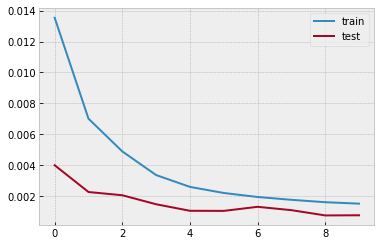

In [84]:
# Se grafica la función de pérdida
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

La diferencia obtenida en los resultados de train y test en la gráfica de la función de pérdida, indica que los datos del dataset de prueba es más sencillo de predecir que el de entrenamiento.

In [85]:
# Se define un modelo encoder (Sin el decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# Se guarda el archivo .h5 con el encoder
encoder.save('encoder-final.h5')

In [86]:
# Se carga el modelo del encoder a partir del archivo guardado
encoder = load_model('encoder-final.h5')
# encode train data
X_train_encode = encoder.predict(X_train_RN)
# encode test data
X_test_encode = encoder.predict(X_test_RN)

# Se define el modelo
model_RN_Autoencoder = LogisticRegression()
# Se entrena el modelo con los datos de entrenamiento
model_RN_Autoencoder.fit(X_train_encode, y_train)
# Se realizan las predicciones mediante el dataset de prueba
yhat = model_RN_Autoencoder.predict(X_test_encode)
# Se calcula la métrica accuracy
metrica_acc = accuracy_score(y_test, yhat)
print(metrica_acc)

0.9836258817895494


Accuracy = 0.9836258817895494
Recall = 0.968677494199536
F1 score = 0.9833813137922011


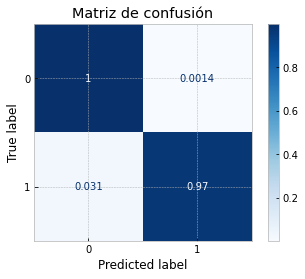

In [87]:
model_metrics(model=model_RN_Autoencoder, X_test=X_test_encode, y_test=y_test)

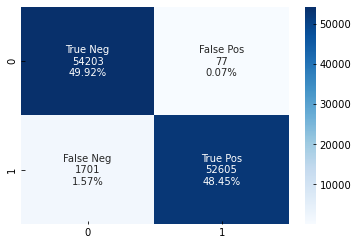

In [88]:
confusion_matrix_labels(model_RN_Autoencoder, X_test_encode, y_test)

### Modelo Stacking

In [89]:
# Definición de los modelos
model0 = list()
model0.append(('lr', LogisticRegression()))
model0.append(('knn', KNeighborsClassifier()))
model0.append(('cart', DecisionTreeClassifier()))

model1 = LogisticRegression()

model_stacking = StackingClassifier(estimators=model0, final_estimator=model1, cv=5)
model_stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()),
                               ('cart', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

Accuracy = 0.9757519385556149
Recall = 0.9686406658564432
F1 score = 0.975583972403305


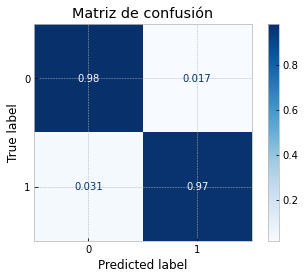

In [90]:
model_metrics(model=model_stacking, X_test=X_test, y_test=y_test)

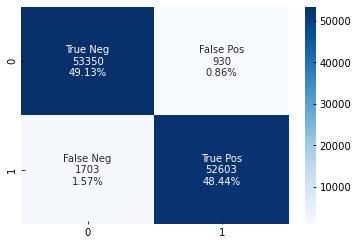

In [91]:
confusion_matrix_labels(model=model_stacking, X_test=X_test, y_test=y_test)

Sin entrenar: ROC AUC=0.500
Model Stacking ROC AUC=0.995


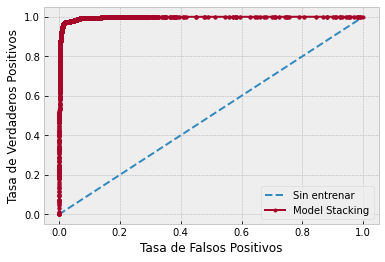

In [92]:
roc_auc_metrics(model_stacking,"Model Stacking",X_test, y_test)

### Modelo Bagging

Se implementa un modelo de ensemble BaggingClassifier con búsqueda de hiperparámetros.

In [69]:
params = {'base_estimator': [LogisticRegression(),
                           DecisionTreeClassifier()],
          'n_estimators': [4,8,10],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

model_bagging = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), param_grid =params, n_jobs=-1,cv=3)
model_bagging.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=BaggingClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'base_estimator': [LogisticRegression(),
                                            DecisionTreeClassifier()],
                         'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0],
                         'n_estimators': [4, 8, 10]})

In [70]:
print('Train R^2 Score : %.3f'%model_bagging.best_estimator_.score(X_train, y_train))
print('Test R^2 Score : %.3f'%model_bagging.best_estimator_.score(X_test, y_test))
print('Best R^2 Score Through Grid Search : %.3f'%model_bagging.best_score_)
print('Best Parameters : ',model_bagging.best_params_)

Train R^2 Score : 1.000
Test R^2 Score : 0.986
Best R^2 Score Through Grid Search : 0.986
Best Parameters :  {'base_estimator': DecisionTreeClassifier(), 'bootstrap': False, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10}


In [71]:
model_bagging = model_bagging.best_estimator_

In [73]:
model_bagging

BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=False,
                  bootstrap_features=True, n_jobs=-1, random_state=1)

Accuracy = 0.986029506566224
Recall = 0.9736677346886163
F1 score = 0.9858579832011112


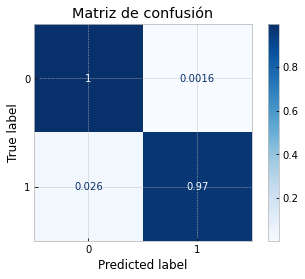

In [72]:
model_metrics(model=model_bagging, X_test=X_test, y_test=y_test)

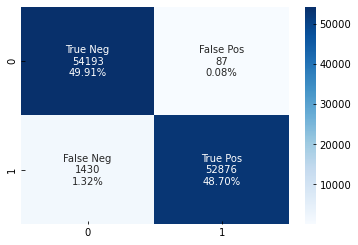

In [74]:
confusion_matrix_labels(model=model_bagging, X_test=X_test, y_test=y_test)

Sin entrenar: ROC AUC=0.500
Model Bagging ROC AUC=0.993


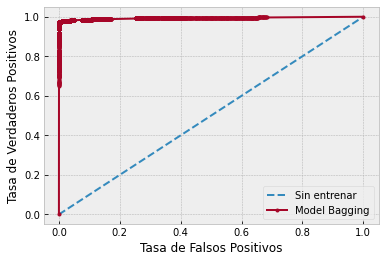

In [75]:
roc_auc_metrics(model_bagging,"Model Bagging",X_test, y_test)

In [77]:
cross_val(model_bagging, X_test, y_test)

Metricas cross_validation 
[0.99 0.98 0.98 0.98 0.99 0.99 0.98 0.98 0.98 0.98]
Media de cross_validation 0.98


### Modelo XGBOOST

Se implementa un modelo ensemble XGBClassifier de xgboost con búsqueda de hiperparámetros.

In [97]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [79]:
import xgboost as xgb

In [80]:
model_xgb = xgb.XGBClassifier(colsample_bytree=0.7, subsample=0.7, objective='binary:logistic', 
                              eval_metric='auc', min_child_weight=1, 
                              base_score = np.mean(y_train))
model_xgb = model_xgb.fit(X_train, np.ravel(y_train, order='C'))

In [87]:
parameteres = {'max_depth': [2,4,5], 'n_estimators': [80,100], 'colsample_bytree': [0.7], 'subsample': [0.7], 
               'objective':['binary:logistic'], 'eval_metric':['auc'], 'min_child_weight':[1], 'n_jobs': [-1]}

grid = GridSearchCV(model_xgb, param_grid=parameteres, cv=10)
kf_hiper = KFold(n_splits=10)
model_xgb = grid.fit(X_train, np.ravel(y_train, order='C')).best_estimator_
y_pred_x = model_xgb.predict(X_test)

In [88]:
model_xgb

XGBClassifier(base_score=0.4999486908267092, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [89]:
print(classification_report(y_test, y_pred_x))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     54280
           1       1.00      0.97      0.98     54306

    accuracy                           0.98    108586
   macro avg       0.98      0.98      0.98    108586
weighted avg       0.98      0.98      0.98    108586



Accuracy = 0.9843810435967805
Recall = 0.9691746768312893
F1 score = 0.9841436050860135


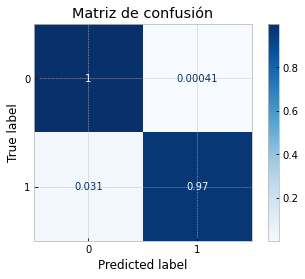

In [90]:
model_metrics(model=model_xgb, X_test=X_test, y_test=y_test)

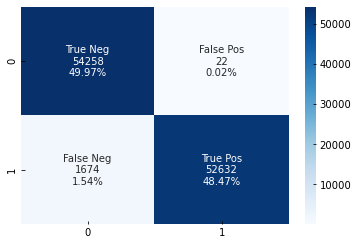

In [91]:
confusion_matrix_labels(model=model_xgb, X_test=X_test, y_test=y_test)

Sin entrenar: ROC AUC=0.500
XGBClassifier ROC AUC=0.993


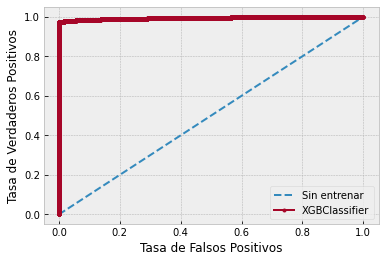

In [92]:
roc_auc_metrics(model_xgb,"XGBClassifier",X_test, y_test)

In [93]:
cross_val(model_xgb, X_test, y_test)

Metricas cross_validation 
[0.98 0.98 0.98 0.99 0.98 0.98 0.98 0.98 0.98 0.98]
Media de cross_validation 0.98


## Guardar modelos realizados

In [95]:
import joblib

In [245]:
# save Model Random Forest
joblib.dump(model_randomforest, "model_randomforest.joblib")

['model_randomforest.joblib']

In [250]:
# save Model Red Neuronal con Autoencoder
joblib.dump(model_RN_Autoencoder, "model_RN_Autoencoder.joblib")

['model_RN_Autoencoder.joblib']

In [ ]:
# save Model Stacking
joblib.dump(model_stacking, "model_stacking.joblib")

In [97]:
# save Model Bagging
joblib.dump(model_bagging, "model_bagging.joblib")

['model_bagging.joblib']

In [98]:
# save Model XGB
joblib.dump(model_xgb, "model_xgb.joblib")

['model_xgb.joblib']

In [ ]:
# load
#loaded_rf = joblib.load("model_randomforest.joblib")